# Expore data

## Import & definitions

In [635]:
import os
import hashlib
import sys
from pathlib import Path
import re
import random
import time
import math
import itertools
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json
import joblib
# Third Party
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from scipy.stats.mstats import mquantiles
# from helpers.ocean_helpers import save_list
'''import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import L1L2'''
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme("notebook")
mpl.style.use('seaborn-v0_8-ticks')
# definitions
DT_PAST = 5 # 5 min
PAST_HISTORY = int(6*60 / DT_PAST) #  6 hours in 5mins units : used to predict next values in future
FUTURE_TARGET = 12 + 3 # number of 5 min to predict  : 15 : 1h15
STEP = 1
BATCH_SIZE = 256 #128 #32
TRAIN_SPLIT_RATIO = 0.995 #0.8 #0.9891 # 1-(60/5*24)/50977
TARGET_NAME = "Close_ETH"
MODE_TRAIN_AE = True 
'''
#LIST_SEEDS = [1,2,3,4,5]
LIST_SEEDS = [1]
MODE_AUTO_SELECT = 0 #1 #   #0 # 0: False, 1: True, 2: from disk
MODE_TRAIN_PREDICTOR = True # False

EPOCHS_AE = 1#30
PATIENCE_AE = 0#10
LIST_UNITS_ENC_AE = [64]
LIST_UNITS_AE = [16]
LIST_DROPOUT_AE = [0.2]

EPOCHS_PRED = 100#30
PATIENCE_PRED = 0#10
LIST_UNITS_PRED = [128]
LIST_DROPOUT_PRED = [0.2]

MODE_TRAIN_LSTM = False
'''
# paths
path_data = "data"
path_save_df_feat = os.path.join(path_data, "df_features_05m.csv")

path_save_pred_vals = os.path.join(path_data, "pred_vals.csv")
path_save_auto_select = os.path.join(path_data, "list_auto_select.csv")

path_scaler = os.path.join(path_data, "scaler.bin")
path_scaler_y = os.path.join(path_data, "scaler_y.bin")
path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")
path_save_df_feat_std = os.path.join(path_data, "df_features_05m_std.csv")
path_X_train = os.path.join(path_data, 'X_train.dat')
path_X_train_sca = os.path.join(path_data, 'X_train_sca.dat')
path_df_prob_comb = os.path.join(path_data, 'df_prob_comb.csv')
path_arr_corr_matrix_targets = os.path.join(
    path_data, 'arr_corr_matrix_targets.npy'
)
'''
path_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")
path_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")
path_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")
path_mdl_predict_autoenc_lstm  =  os.path.join(
    path_data, "mdl_predict_autoenc_lstm")
'''

'\npath_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")\npath_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")\npath_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")\npath_mdl_predict_autoenc_lstm  =  os.path.join(\n    path_data, "mdl_predict_autoenc_lstm")\n'

In [2]:
PAST_HISTORY

72

In [3]:
21+9-24

6

In [4]:
print(60/5*24*2)
1-(60/5*24*2)/52981

576.0


0.9891281780260848

In [5]:
# helpers: save/load list
def save_list(list_: list, file_name: str):
    """Save a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    p.write_text(str(list_))
    
def load_list(file_name: str) -> list:
    """Load from a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    s = p.read_text()
    list_ = eval(s)
    return list_

In [6]:
def plot_train_history(history, title, saveFolder=None):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    fig = plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    ax = fig.gca()
    ax.set_xlabel("epoch[-]")
    if saveFolder is not None:
        title_clean = re.sub('[^-a-zA-Z0-9 \.]', ' ', title)
        plt.savefig(os.path.join(saveFolder, f"output_{title_clean}.jpg")) 
    plt.show()


def naming_plot(n_unit_enc, encoding_dim, dropout_autoenc):
    return f"TS {TRAIN_SPLIT_RATIO} - units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc}"

<>:19: SyntaxWarning: invalid escape sequence '\.'
<>:19: SyntaxWarning: invalid escape sequence '\.'
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_93901/2761487227.py:19: SyntaxWarning: invalid escape sequence '\.'
  title_clean = re.sub('[^-a-zA-Z0-9 \.]', ' ', title)


In [ ]:
# Helpers check update
def get_data_hash(data):
    data = str(data).encode('utf-8')
    return hashlib.sha256(data).hexdigest()

def load_hash(file_path):
    if not os.path.exists(file_path):
        return None
    with open(file_path, 'r') as file:
        data = file.read()
    return data

def check_hash_inputs(tuple_inputs, path_hash):
    hash_inputs = ""
    for curr_var in tuple_inputs:
        hash_inputs += get_data_hash(curr_var)

    # load old file hash
    hash_inputs_old = load_hash(path_hash)

    # compare hash
    if hash_inputs == hash_inputs_old:
        print("hash match: mode LOAD")
        return False, hash_inputs
    else:
        print("hash not match : mode REDO")
        return True, hash_inputs
    
def save_hash(path_hash, hash_inputs):
    with open(path_hash, 'w') as file:
            file.write(hash_inputs)


## Load raw features

In [8]:
# load
df_feat_raw = pd.read_csv(path_save_df_feat)
# keep target untouched
df_feat_raw[f"{TARGET_NAME}_raw"] = df_feat_raw[TARGET_NAME]
df_feat_raw

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_93901/2738736025.py:2: DtypeWarning: Columns (118,119,120,121,122,123,124,134) have mixed types. Specify dtype option on import or set low_memory=False.
  df_feat_raw = pd.read_csv(path_save_df_feat)


Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0       1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1       1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2       1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3       1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4       1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...               ...       ...       ...      ...        ...         ...   
255033  1749040800000   2621.71   2625.30  2621.20    2624.51   1106.7394   
255034  1749041100000   2624.50   2626.90  2623.30    2624.26    977.3830   
255035  1749041400000   2624.26   2624.27  2617.15    2620.24   2446.9130   
255036  1749041700000   2620.23   2621.73  2614.51    2616.73   2193.9711   
255037  1749042000000   2616.74   2619.75  2612.46    2614.27   2569.5278   

                   date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0       2023-01-01 00:00:00       2419.198618       2418.400385   
1       2023-01-01 00:05:00       2419.198618       2418.400385   
2       2023-01-01 00:10:00       2419.198618       2418.400385   
3       2023-01-01 00:15:00       2419.198618       2418.400385   
4       2023-01-01 00:20:00       2419.198618       2418.400385   
...                     ...               ...               ...   
255033  2025-06-04 12:40:00       2641.525000       2635.690000   
255034  2025-06-04 12:45:00       2641.525000       2635.690000   
255035  2025-06-04 12:50:00       2641.350000       2636.225000   
255036  2025-06-04 12:55:00       2641.350000       2636.225000   
255037  2025-06-04 13:00:00       2641.350000       2636.225000   

        ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0                  NaN  ...         NaN            NaN           NaN   
1                  NaN  ...         NaN            NaN           NaN   
2                  NaN  ...         NaN            NaN           NaN   
3                  NaN  ...         NaN            NaN           NaN   
4                  NaN  ...         NaN            NaN           NaN   
...                ...  ...         ...            ...           ...   
255033        2630.360  ...         NaN            NaN           NaN   
255034        2630.360  ...         NaN            NaN           NaN   
255035        2630.360  ...         NaN            NaN           NaN   
255036        2629.695  ...         NaN            NaN           NaN   
255037        2628.670  ...         NaN            NaN           NaN   

        delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                    NaN         0.0               NaN         0.0      0.0   
1                    NaN         0.0               NaN         0.0      0.0   
2                    NaN         0.0               NaN         0.0      0.0   
3                    NaN         0.0               NaN         0.0      0.0   
4                    NaN         0.0               NaN         0.0      0.0   
...                  ...         ...               ...         ...      ...   
255033               NaN         0.0               NaN         0.0      0.0   
255034               NaN         0.0               NaN         0.0      0.0   
255035               NaN         0.0               NaN         0.0      0.0   
255036               NaN         0.0               NaN         0.0      0.0   
255037               NaN         0.0               NaN         0.0      0.0   

        date  Close_ETH_raw  
0        NaN        1196.32  
1        NaN        1195.38  
2        NaN        1194.55  
3        NaN        1195.98  
4        NaN        1196.06  
...      ...            ...  
255033   NaN        2624.51  
255034   NaN        2624.26  
255035   NaN        2620.24  
255036   NaN        2616.73  
255037   NaN        2614.27  

[255038 rows x 136 columns]

### drop nan

In [9]:
def get_missing(df):
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    nb_missing = nb_missing[nb_missing.values > 0]
    print("missing data : ")
    print(nb_missing)
    print("")
    print("on {} samples".format(df.shape[0]))
    return nb_missing

nb_missing = get_missing(df_feat_raw)

missing data : 
vwap_z_score_ETH             1
vwap_z_score_BTC             1
ichi_tenkan_ETH              8
ichi_tenkan_BTC              8
rsi_h_ETH                   13
max_high_h_ETH              13
min_low_h_BTC               13
max_high_h_BTC              13
min_low_h_ETH               13
rsi_h_BTC                   13
chop_h_BTC                  14
chop_h_ETH                  14
ichi_kijun_ETH              25
ichi_cloud_a_ETH            25
ichi_kijun_BTC              25
ichi_cloud_a_BTC            25
ichi_tenkan_day_BTC        215
ichi_tenkan_day_ETH        215
dxy                        264
min_low_d_BTC              335
max_high_d_ETH             335
rsi_d_BTC                  335
max_high_d_BTC             335
rsi_d_ETH                  335
chop_d_ETH                 335
chop_d_BTC                 335
min_low_d_ETH              335
ichi_kijun_day_ETH         623
ichi_cloud_a_day_BTC       623
ichi_cloud_a_day_ETH       623
ichi_kijun_day_BTC         623
fvx                    

#### Cheat Backward Filling

In [10]:
df_feat = df_feat_raw.copy()

In [11]:
df_feat = df_feat.bfill(axis ='rows')

In [12]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0       1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1       1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2       1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3       1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4       1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...               ...       ...       ...      ...        ...         ...   
255033  1749040800000   2621.71   2625.30  2621.20    2624.51   1106.7394   
255034  1749041100000   2624.50   2626.90  2623.30    2624.26    977.3830   
255035  1749041400000   2624.26   2624.27  2617.15    2620.24   2446.9130   
255036  1749041700000   2620.23   2621.73  2614.51    2616.73   2193.9711   
255037  1749042000000   2616.74   2619.75  2612.46    2614.27   2569.5278   

                   date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0       2023-01-01 00:00:00       2419.198618       2418.400385   
1       2023-01-01 00:05:00       2419.198618       2418.400385   
2       2023-01-01 00:10:00       2419.198618       2418.400385   
3       2023-01-01 00:15:00       2419.198618       2418.400385   
4       2023-01-01 00:20:00       2419.198618       2418.400385   
...                     ...               ...               ...   
255033  2025-06-04 12:40:00       2641.525000       2635.690000   
255034  2025-06-04 12:45:00       2641.525000       2635.690000   
255035  2025-06-04 12:50:00       2641.350000       2636.225000   
255036  2025-06-04 12:55:00       2641.350000       2636.225000   
255037  2025-06-04 13:00:00       2641.350000       2636.225000   

        ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0             1194.710  ...         0.0            0.0           0.0   
1             1194.710  ...         0.0            0.0           0.0   
2             1194.710  ...         0.0            0.0           0.0   
3             1194.710  ...         0.0            0.0           0.0   
4             1194.710  ...         0.0            0.0           0.0   
...                ...  ...         ...            ...           ...   
255033        2630.360  ...         NaN            NaN           NaN   
255034        2630.360  ...         NaN            NaN           NaN   
255035        2630.360  ...         NaN            NaN           NaN   
255036        2629.695  ...         NaN            NaN           NaN   
255037        2628.670  ...         NaN            NaN           NaN   

        delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                    0.0         0.0               0.0         0.0      0.0   
1                    0.0         0.0               0.0         0.0      0.0   
2                    0.0         0.0               0.0         0.0      0.0   
3                    0.0         0.0               0.0         0.0      0.0   
4                    0.0         0.0               0.0         0.0      0.0   
...                  ...         ...               ...         ...      ...   
255033               NaN         0.0               NaN         0.0      0.0   
255034               NaN         0.0               NaN         0.0      0.0   
255035               NaN         0.0               NaN         0.0      0.0   
255036               NaN         0.0               NaN         0.0      0.0   
255037               NaN         0.0               NaN         0.0      0.0   

                       date  Close_ETH_raw  
0       2023-01-02 05:00:00        1196.32  
1       2023-01-02 05:00:00        1195.38  
2       2023-01-02 05:00:00        1194.55  
3       2023-01-02 05:00:00        1195.98  
4       2023-01-02 05:00:00        1196.06  
...                     ...            ...  
255033                  NaN        2624.51  
255034                  NaN        2624.26  
255035                  NaN        2620.24  
255036                 

In [13]:
nb_missing = get_missing(df_feat)

missing data : 
date                2688
delta_event_real    2688
delta_event_pred    2688
Previous_num        2688
Consensus_num       2688
keep                2688
Date                2688
Previous            2688
Consensus           2688
Event               2688
Country             2688
Time (ET)           2688
Actual_num          2688
Actual              2688
dtype: int64

on 255038 samples


In [14]:
#print(df_feat.shape)
#df_feat = df_feat.dropna(subset=["Consensus_num"]).copy()
#df_feat.reset_index(inplace=True)
#df_feat.shape

## Features Selection

### Proportional to the Price

In [15]:
list_col = df_feat.columns.to_list()
list_col

['Time',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'spx',
 'dxy',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'hour',
 'hour_cos',
 'hour_sin',
 'weekday',
 'weekday_cos',
 'weekday_sin',
 'day',
 'days_in_month',
 'day_ratio',
 'da

In [16]:
list_col_ETH = [col for col in list_col if re.search("_ETH", col) is not None]
list_col_ETH

['Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'Close_ETH_raw']

In [17]:
df_feat[list_col_ETH]

Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0        1196.13   1196.32  1195.65    1196.32    334.5592   
1        1196.31   1196.69  1194.90    1195.38    682.3876   
2        1195.38   1195.81  1194.55    1194.55    228.9387   
3        1194.55   1195.98  1194.31    1195.98    601.8903   
4        1195.98   1196.37  1195.97    1196.06    144.8048   
...          ...       ...      ...        ...         ...   
255033   2621.71   2625.30  2621.20    2624.51   1106.7394   
255034   2624.50   2626.90  2623.30    2624.26    977.3830   
255035   2624.26   2624.27  2617.15    2620.24   2446.9130   
255036   2620.23   2621.73  2614.51    2616.73   2193.9711   
255037   2616.74   2619.75  2612.46    2614.27   2569.5278   

                   date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0       2023-01-01 00:00:00       2419.198618       2418.400385   
1       2023-01-01 00:05:00       2419.198618       2418.400385   
2       2023-01-01 00:10:00       2419.198618       2418.400385   
3       2023-01-01 00:15:00       2419.198618       2418.400385   
4       2023-01-01 00:20:00       2419.198618       2418.400385   
...                     ...               ...               ...   
255033  2025-06-04 12:40:00       2641.525000       2635.690000   
255034  2025-06-04 12:45:00       2641.525000       2635.690000   
255035  2025-06-04 12:50:00       2641.350000       2636.225000   
255036  2025-06-04 12:55:00       2641.350000       2636.225000   
255037  2025-06-04 13:00:00       2641.350000       2636.225000   

        ichi_kijun_ETH  ichi_tenkan_ETH  ...  vwap_3m_ETH  vwap_6m_ETH  \
0             1194.710         1194.710  ...  1196.096667  1196.096667   
1             1194.710         1194.710  ...  1195.801420  1195.801420   
2             1194.710         1194.710  ...  1195.648641  1195.648641   
3             1194.710         1194.710  ...  1195.575250  1195.575250   
4             1194.710         1194.710  ...  1195.615807  1195.615807   
...                ...              ...  ...          ...          ...   
255033        2630.360         2627.260  ...  2215.946820  2112.080395   
255034        2630.360         2627.260  ...  2215.970478  2112.079173   
255035        2630.360         2627.260  ...  2216.016378  2112.083189   
255036        2629.695         2624.810  ...  2216.072494  2112.088060   
255037        2628.670         2620.525  ...  2216.123423  2112.097985   

         vwap_y_ETH  vwap_all_ETH  vwap_z_score_ETH  nupl_ETH    supply_ETH  \
0       1196.096667   1196.096667         -0.634018  0.000187  1.205290e+08   
1       1195.801420   1195.801420         -0.634018 -0.000353  1.205290e+08   
2       1195.648641   1195.648641         -1.240604 -0.000920  1.205290e+08   
3       1195.575250   1195.575250          0.521593  0.000338  1.205290e+08   
4       1195.615807   1195.615807          0.626856  0.000371  1.205290e+08   
...             ...           ...               ...       ...           ...   
255033  2465.963959   2449.429165          0.244601  0.066710  1.207159e+08   
255034  2465.992103   2449.429616          0.244251  0.066621  1.207159e+08   
255035  2466.034614   2449.430717          0.238634  0.065188  1.207159e+08   
255036  2466.071410   2449.431688          0.233729  0.063934  1.207159e+08   
255037  2466.111540   2449.432810          0.230291  0.063053  1.207159e+08   

        act_addr_ETH  market_dom_ETH  Close_ETH_raw  
0             522460       17.409118        1196.32  
1             522460       17.409118        1195.38  
2             522460       17.409118        1194.55  
3             522460       17.409118        1195.98  
4             522460       17.409118        1196.06  
...              ...             ...            ...  
255033        587140        9.110644        2624.51  
255034        587140        9.110644        2624.26  
255035        587140        9.110644        2620.24  
255036        587140        9.110644        2616.73  
255037        587140      

In [18]:
list_price_dep_ETH = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
    'ichi_cloud_a_ETH',
    'ichi_cloud_b_ETH',
    'ichi_kijun_ETH',
    'ichi_tenkan_ETH',
    'ichi_cloud_a_day_ETH',
    'ichi_cloud_b_day_ETH',
    'ichi_kijun_day_ETH',
    'ichi_tenkan_day_ETH',
    'ichi_cloud_a_week_ETH',
    'ichi_cloud_b_week_ETH',
    'ichi_kijun_week_ETH',
    'ichi_tenkan_week_ETH',
    'max_high_h_ETH',
    'min_low_h_ETH',
    'max_high_d_ETH',
    'min_low_d_ETH',
    'max_high_w_ETH',
    'min_low_w_ETH',
    'vwap_h_ETH',
    'vwap_d_ETH',
    'vwap_w_ETH',
    'vwap_m_ETH',
    'vwap_3m_ETH',
    'vwap_6m_ETH',
    'vwap_y_ETH',
    'vwap_all_ETH',
]


#    'max_high_h_ETH',
#    'ichi_tenkan_week_ETH',

In [19]:
list_col_BTC = [col for col in list_col if re.search("_BTC", col) is not None]
list_col_BTC

['Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'Volume_BTC',
 'date_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'rsi_h_BTC',
 'rsi_d_BTC',
 'rsi_w_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'atr_h_BTC',
 'chop_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'atr_d_BTC',
 'chop_d_BTC',
 'max_high_w_BTC',
 'min_low_w_BTC',
 'atr_w_BTC',
 'chop_w_BTC',
 'vwap_h_BTC',
 'vwap_d_BTC',
 'vwap_w_BTC',
 'vwap_m_BTC',
 'vwap_3m_BTC',
 'vwap_6m_BTC',
 'vwap_y_BTC',
 'vwap_all_BTC',
 'vwap_z_score_BTC',
 'nupl_BTC',
 'supply_BTC',
 'act_addr_BTC',
 'market_dom_BTC']

In [20]:
list_price_dep_BTC = [
    'Open_BTC',
    'High_BTC',
    'Low_BTC',
    'Close_BTC',
    'ichi_cloud_a_BTC',
    'ichi_cloud_b_BTC',
    'ichi_kijun_BTC',
    'ichi_tenkan_BTC',
    'ichi_cloud_a_day_BTC',
    'ichi_cloud_b_day_BTC',
    'ichi_kijun_day_BTC',
    'ichi_tenkan_day_BTC',
    'ichi_cloud_a_week_BTC',
    'ichi_cloud_b_week_BTC',
    'ichi_kijun_week_BTC',
    'ichi_tenkan_week_BTC',
    'max_high_h_BTC',
    'min_low_h_BTC',
    'max_high_d_BTC',
    'min_low_d_BTC',
    'max_high_w_BTC',
    'min_low_w_BTC',
    'vwap_h_BTC',
    'vwap_d_BTC',
    'vwap_w_BTC',
    'vwap_m_BTC',
    'vwap_3m_BTC',
    'vwap_6m_BTC',
    'vwap_y_BTC',
    'vwap_all_BTC',
    'vwap_z_score_BTC',
]

In [21]:
list_col_BNB = [col for col in list_col if re.search("_BNB", col) is not None]
list_col_BNB

['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB', 'Volume_BNB', 'date_BNB']

In [22]:
list_price_dep_BNB = ['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB']

#### add special indices

In [23]:
df_feat[["fvx", "spx", "dxy"]]

fvx          spx         dxy
0       3.910  3823.179932  103.494003
1       3.910  3823.179932  103.494003
2       3.910  3823.179932  103.494003
3       3.910  3823.179932  103.494003
4       3.910  3823.179932  103.494003
...       ...          ...         ...
255033  3.979  5970.529785   98.964996
255034  3.979  5970.529785   98.964996
255035  3.979  5970.529785   98.964996
255036  3.979  5970.529785   98.964996
255037  3.979  5970.529785   98.956001

[255038 rows x 3 columns]

In [24]:
list_price_dep_special = ["fvx", "spx", "dxy"]

### Not proportional to the Price 

In [25]:
set(list_col) - set(list_price_dep_ETH) - set(list_price_dep_BTC) - set(list_price_dep_BNB) - set(list_price_dep_special)

{'Actual',
 'Actual_num',
 'Close_ETH_raw',
 'Consensus',
 'Consensus_num',
 'Country',
 'Date',
 'Event',
 'Previous',
 'Previous_num',
 'Time',
 'Time (ET)',
 'Volume_BNB',
 'Volume_BTC',
 'Volume_ETH',
 'act_addr_BTC',
 'act_addr_ETH',
 'atr_d_BTC',
 'atr_d_ETH',
 'atr_h_BTC',
 'atr_h_ETH',
 'atr_w_BTC',
 'atr_w_ETH',
 'chop_d_BTC',
 'chop_d_ETH',
 'chop_h_BTC',
 'chop_h_ETH',
 'chop_w_BTC',
 'chop_w_ETH',
 'date',
 'date_BNB',
 'date_BTC',
 'date_ETH',
 'day',
 'day_in_month_cos',
 'day_in_month_sin',
 'day_off',
 'day_ratio',
 'days_in_month',
 'delta_event_pred',
 'delta_event_real',
 'event_pred',
 'event_real',
 'fear_greed',
 'fear_greed_class',
 'hour',
 'hour_cos',
 'hour_sin',
 'keep',
 'market_dom_BTC',
 'market_dom_ETH',
 'month',
 'month_cos',
 'month_sin',
 'nupl_BTC',
 'nupl_ETH',
 'rsi_d_BTC',
 'rsi_d_ETH',
 'rsi_h_BTC',
 'rsi_h_ETH',
 'rsi_w_BTC',
 'rsi_w_ETH',
 'supply_BTC',
 'supply_ETH',
 'vwap_z_score_ETH',
 'weekday',
 'weekday_cos',
 'weekday_sin'}

In [26]:
list_col_other = [
    'Volume_BNB',
    'Volume_BTC',
    'Volume_ETH',
    'chop_d_BTC',
    'chop_d_ETH',
    'chop_h_BTC',
    'chop_h_ETH',
    'chop_w_BTC',
    'chop_w_ETH',
    'rsi_d_BTC',
    'rsi_d_ETH',
    'rsi_h_BTC',
    'rsi_h_ETH',
    'rsi_w_BTC',
    'rsi_w_ETH',
    'vwap_z_score_ETH',
    #'dxy',
    #'spx',
    #'fvx',
    'act_addr_BTC',
    'act_addr_ETH',
    'market_dom_BTC',
    'market_dom_ETH',
    'nupl_BTC',
    'nupl_ETH',
    'fear_greed',
    'supply_BTC',
    'supply_ETH',
    'hour_cos',
    'hour_sin',
    'weekday_cos',
    'weekday_sin',
    'day_in_month_cos',
    'day_in_month_sin',
    #'month_cos',
    #'month_sin',
    'day_off',
    'event_pred',
    'event_real',
]

### Final selection

In [27]:
list_col_select_simple = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
]

list_col_select_global = (
    list_price_dep_ETH +
    list_price_dep_BTC +
    list_price_dep_BNB +  
    list_price_dep_special +  
    list_col_other +
    [f"{TARGET_NAME}_raw"]
)

# selection
list_col_select = list_col_select_global

# only col in df_feat
list_col_select = [feat for feat in list_col_select if feat in df_feat.columns]
print("num features : ", len(list_col_select))

num features :  103


In [28]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [29]:
get_missing(df_feat.filter(list_col_select))

missing data : 
Series([], dtype: int64)

on 255038 samples


Series([], dtype: int64)

## Features preparation

df_feat [selected features]   
--> X_train_raw, X_test_raw, y_train_raw, y_test_raw  
--> X_train (with prices ratio of ETH Close price at last lag) <-- used by autoencoder 


X [nb samples, nb lags, nb features]


In [30]:
df_feat.shape[0]

255038

In [305]:
TRAIN_SPLIT_RATIO

0.995

In [31]:
TRAIN_SPLIT = round(TRAIN_SPLIT_RATIO * df_feat.shape[0])
TRAIN_SPLIT

253763

In [32]:
bol_train = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat.shape[0])]
df_feat["train"] = bol_train
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0       1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1       1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2       1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3       1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4       1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...               ...       ...       ...      ...        ...         ...   
255033  1749040800000   2621.71   2625.30  2621.20    2624.51   1106.7394   
255034  1749041100000   2624.50   2626.90  2623.30    2624.26    977.3830   
255035  1749041400000   2624.26   2624.27  2617.15    2620.24   2446.9130   
255036  1749041700000   2620.23   2621.73  2614.51    2616.73   2193.9711   
255037  1749042000000   2616.74   2619.75  2612.46    2614.27   2569.5278   

                   date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0       2023-01-01 00:00:00       2419.198618       2418.400385   
1       2023-01-01 00:05:00       2419.198618       2418.400385   
2       2023-01-01 00:10:00       2419.198618       2418.400385   
3       2023-01-01 00:15:00       2419.198618       2418.400385   
4       2023-01-01 00:20:00       2419.198618       2418.400385   
...                     ...               ...               ...   
255033  2025-06-04 12:40:00       2641.525000       2635.690000   
255034  2025-06-04 12:45:00       2641.525000       2635.690000   
255035  2025-06-04 12:50:00       2641.350000       2636.225000   
255036  2025-06-04 12:55:00       2641.350000       2636.225000   
255037  2025-06-04 13:00:00       2641.350000       2636.225000   

        ichi_kijun_ETH  ...  Consensus_num  Previous_num  delta_event_pred  \
0             1194.710  ...            0.0           0.0               0.0   
1             1194.710  ...            0.0           0.0               0.0   
2             1194.710  ...            0.0           0.0               0.0   
3             1194.710  ...            0.0           0.0               0.0   
4             1194.710  ...            0.0           0.0               0.0   
...                ...  ...            ...           ...               ...   
255033        2630.360  ...            NaN           NaN               NaN   
255034        2630.360  ...            NaN           NaN               NaN   
255035        2630.360  ...            NaN           NaN               NaN   
255036        2629.695  ...            NaN           NaN               NaN   
255037        2628.670  ...            NaN           NaN               NaN   

        event_pred  delta_event_real  event_real  day_off  \
0              0.0               0.0         0.0      0.0   
1              0.0               0.0         0.0      0.0   
2              0.0               0.0         0.0      0.0   
3              0.0               0.0         0.0      0.0   
4              0.0               0.0         0.0      0.0   
...            ...               ...         ...      ...   
255033         0.0               NaN         0.0      0.0   
255034         0.0               NaN         0.0      0.0   
255035         0.0               NaN         0.0      0.0   
255036         0.0               NaN         0.0      0.0   
255037         0.0               NaN         0.0      0.0   

                       date  Close_ETH_raw  train  
0       2023-01-02 05:00:00        1196.32   True  
1       2023-01-02 05:00:00        1195.38   True  
2       2023-01-02 05:00:00        1194.55   True  
3       2023-01-02 05:00:00        1195.98   True  
4       2023-01-02 05:00:00        1196.06   True  
...                     ...            ...    ...  
255033                  NaN        2624.51  False  
255034                  NaN        2624.26  False  
255035                  NaN        2620.24  False  
255036                  NaN        2616.73  False  
255037                  NaN        2614.27  F

In [33]:
df_feat[df_feat["train"] == True]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0       1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1       1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2       1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3       1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4       1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...               ...       ...       ...      ...        ...         ...   
253759  1748658600000   2504.91   2505.00  2492.22    2495.20   4235.1902   
253760  1748658900000   2495.21   2503.27  2494.44    2502.12   2576.0733   
253761  1748659200000   2502.11   2502.60  2498.13    2498.60   1382.7143   
253762  1748659500000   2498.60   2500.40  2496.37    2498.75   1450.5001   
253763  1748659800000   2498.75   2502.00  2485.40    2492.50   3607.3172   

                   date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0       2023-01-01 00:00:00       2419.198618       2418.400385   
1       2023-01-01 00:05:00       2419.198618       2418.400385   
2       2023-01-01 00:10:00       2419.198618       2418.400385   
3       2023-01-01 00:15:00       2419.198618       2418.400385   
4       2023-01-01 00:20:00       2419.198618       2418.400385   
...                     ...               ...               ...   
253759  2025-05-31 02:30:00       2528.067500       2546.470000   
253760  2025-05-31 02:35:00       2526.930000       2546.470000   
253761  2025-05-31 02:40:00       2525.150000       2546.470000   
253762  2025-05-31 02:45:00       2525.150000       2546.470000   
253763  2025-05-31 02:50:00       2524.310000       2546.470000   

        ichi_kijun_ETH  ...  Consensus_num  Previous_num  delta_event_pred  \
0              1194.71  ...            0.0           0.0               0.0   
1              1194.71  ...            0.0           0.0               0.0   
2              1194.71  ...            0.0           0.0               0.0   
3              1194.71  ...            0.0           0.0               0.0   
4              1194.71  ...            0.0           0.0               0.0   
...                ...  ...            ...           ...               ...   
253759         2505.22  ...            NaN           NaN               NaN   
253760         2505.22  ...            NaN           NaN               NaN   
253761         2505.22  ...            NaN           NaN               NaN   
253762         2505.22  ...            NaN           NaN               NaN   
253763         2505.22  ...            NaN           NaN               NaN   

        event_pred  delta_event_real  event_real  day_off  \
0              0.0               0.0         0.0      0.0   
1              0.0               0.0         0.0      0.0   
2              0.0               0.0         0.0      0.0   
3              0.0               0.0         0.0      0.0   
4              0.0               0.0         0.0      0.0   
...            ...               ...         ...      ...   
253759         0.0               NaN         0.0      0.0   
253760         0.0               NaN         0.0      0.0   
253761         0.0               NaN         0.0      0.0   
253762         0.0               NaN         0.0      0.0   
253763         0.0               NaN         0.0      0.0   

                       date  Close_ETH_raw  train  
0       2023-01-02 05:00:00        1196.32   True  
1       2023-01-02 05:00:00        1195.38   True  
2       2023-01-02 05:00:00        1194.55   True  
3       2023-01-02 05:00:00        1195.98   True  
4       2023-01-02 05:00:00        1196.06   True  
...                     ...            ...    ...  
253759                  NaN        2495.20   True  
253760                  NaN        2502.12   True  
253761                  NaN        2498.60   True  
253762                  NaN        2498.75   True  
253763                  NaN        2492.50   

In [34]:
df_feat[df_feat["train"] == False]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
253764  1748660100000   2492.49   2493.17  2487.12    2490.22   2272.6386   
253765  1748660400000   2490.21   2496.84  2489.04    2491.71   1715.3111   
253766  1748660700000   2491.71   2496.80  2485.23    2490.01   1743.7758   
253767  1748661000000   2490.00   2496.59  2488.06    2496.04   1652.4027   
253768  1748661300000   2496.04   2499.85  2486.99    2490.40   2457.9952   
...               ...       ...       ...      ...        ...         ...   
255033  1749040800000   2621.71   2625.30  2621.20    2624.51   1106.7394   
255034  1749041100000   2624.50   2626.90  2623.30    2624.26    977.3830   
255035  1749041400000   2624.26   2624.27  2617.15    2620.24   2446.9130   
255036  1749041700000   2620.23   2621.73  2614.51    2616.73   2193.9711   
255037  1749042000000   2616.74   2619.75  2612.46    2614.27   2569.5278   

                   date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
253764  2025-05-31 02:55:00         2523.4350          2546.470   
253765  2025-05-31 03:00:00         2521.7675          2546.470   
253766  2025-05-31 03:05:00         2521.5525          2546.470   
253767  2025-05-31 03:10:00         2521.3800          2546.470   
253768  2025-05-31 03:15:00         2521.8325          2544.585   
...                     ...               ...               ...   
255033  2025-06-04 12:40:00         2641.5250          2635.690   
255034  2025-06-04 12:45:00         2641.5250          2635.690   
255035  2025-06-04 12:50:00         2641.3500          2636.225   
255036  2025-06-04 12:55:00         2641.3500          2636.225   
255037  2025-06-04 13:00:00         2641.3500          2636.225   

        ichi_kijun_ETH  ...  Consensus_num  Previous_num  delta_event_pred  \
253764        2501.755  ...            NaN           NaN               NaN   
253765        2501.600  ...            NaN           NaN               NaN   
253766        2501.600  ...            NaN           NaN               NaN   
253767        2501.600  ...            NaN           NaN               NaN   
253768        2501.600  ...            NaN           NaN               NaN   
...                ...  ...            ...           ...               ...   
255033        2630.360  ...            NaN           NaN               NaN   
255034        2630.360  ...            NaN           NaN               NaN   
255035        2630.360  ...            NaN           NaN               NaN   
255036        2629.695  ...            NaN           NaN               NaN   
255037        2628.670  ...            NaN           NaN               NaN   

        event_pred  delta_event_real  event_real  day_off  date  \
253764         0.0               NaN         0.0      0.0   NaN   
253765         0.0               NaN         0.0      0.0   NaN   
253766         0.0               NaN         0.0      0.0   NaN   
253767         0.0               NaN         0.0      0.0   NaN   
253768         0.0               NaN         0.0      0.0   NaN   
...            ...               ...         ...      ...   ...   
255033         0.0               NaN         0.0      0.0   NaN   
255034         0.0               NaN         0.0      0.0   NaN   
255035         0.0               NaN         0.0      0.0   NaN   
255036         0.0               NaN         0.0      0.0   NaN   
255037         0.0               NaN         0.0      0.0   NaN   

        Close_ETH_raw  train  
253764        2490.22  False  
253765        2491.71  False  
253766        2490.01  False  
253767        2496.04  False  
253768        2490.40  False  
...               ...    ...  
255033        2624.51  False  
255034        2624.26  False  
255035        2620.24  False  
255036        2616.73  False  
255037        2614.27  False  

[1274 rows x 137 columns]

In [35]:
def gen_sequence(id_df, seq_length, len_pred, seq_cols, i_price_dep=None):
    # Close ETH need to be in first place
    # we divide by close ETH price all price dependent features except the first Close ETH
    # in a matrix
    data_matrix = id_df[seq_cols].values # data of selected col
    num_elements = data_matrix.shape[0] # nb samples

    for start, stop in zip(
            range(0, num_elements - seq_length - len_pred), 
            range(seq_length, num_elements - len_pred)
        ):
            out_matrix = data_matrix[start:stop, :].copy()
            if i_price_dep is not None:
                p_close = out_matrix[-1, 0] # last past history lag, first feature = Close ETH
                # scaling : price dependent features divide by Close ETH 
                out_matrix[:, i_price_dep] = (
                    out_matrix[:, i_price_dep] / p_close
                )
                # keep Price Close with no scaling
                #out_matrix[-1, 0] = p_close
                
            yield out_matrix

def gen_labels(id_df, seq_length, len_pred, label, divide_price=False):

    data_matrix = id_df[label].values 
    num_elements = data_matrix.shape[0]

    for start, stop in zip(
            range(seq_length, num_elements - len_pred), 
            range(seq_length + len_pred, num_elements)
        ):
        out_matrix = data_matrix[start:stop, :].copy()
        if divide_price:
            out_matrix = out_matrix / data_matrix[start-1, 0]
        yield np.swapaxes(out_matrix,0,1).squeeze()

In [36]:
x = np.array([[1,2,3]])
x = np.swapaxes(x,0,1)
x = np.swapaxes(x,0,1).squeeze()
x

array([1, 2, 3])

In [37]:
i_col_price_dep = [
    (
        (col in list_price_dep_ETH) 
        or (col in list_price_dep_BTC) 
        or (col in list_price_dep_BNB)
        or (col in list_price_dep_special)
    ) 
    for col in list_col_select ]

In [38]:
df_feat[df_feat["train"] == True].shape[0]

253764

In [39]:
df_feat[df_feat["train"] == True].shape[0] - PAST_HISTORY - FUTURE_TARGET

253677

In [40]:
n_feat = df_feat.loc[df_feat["train"] == True, list_col_select].shape[1]
n_feat

103

In [41]:
# create X_train on disk
#filename = os.path.join(path_data, 'X_train.dat')
#print(filename)
X_train_dat = np.memmap(
    path_X_train, 
    dtype='float32', 
    mode='w+', 
    shape=(
        df_feat[df_feat["train"] == True].shape[0] - PAST_HISTORY - FUTURE_TARGET, 
        PAST_HISTORY, 
        n_feat,
    )
)

In [42]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [43]:
X_test = []
y_train, y_test = [], []

for is_train, _df in df_feat.groupby("train"):

    for index, seq in enumerate(gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        i_col_price_dep
        )):
        if is_train:
            # don't use append here but assign to X_train_dat
            X_train_dat[index] = seq # PAST_HISTORY * n_feat
            #X_train.append(seq)
        else:
            X_test.append(seq)
        
        #index += 1
    if is_train:
        X_train_dat.flush()

    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH'], divide_price=True):

        if is_train:
            y_train.append(seq_y)
        else:
            y_test.append(seq_y)    

#X_train = np.asarray(X_train)
y_train = np.array(y_train)
X_test = np.asarray(X_test)
y_test = np.array(y_test)

#print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1187, 72, 103) (1187, 15)


In [44]:
X_train_dat

memmap([[[1.0014901e+00, 1.0013311e+00, 1.0014901e+00, ...,
          0.0000000e+00, 0.0000000e+00, 1.1963199e+03],
         [1.0007032e+00, 1.0014818e+00, 1.0017998e+00, ...,
          0.0000000e+00, 0.0000000e+00, 1.1953800e+03],
         [1.0000083e+00, 1.0007032e+00, 1.0010632e+00, ...,
          0.0000000e+00, 0.0000000e+00, 1.1945500e+03],
         ...,
         [9.9983257e-01, 9.9962330e-01, 9.9984092e-01, ...,
          0.0000000e+00, 0.0000000e+00, 1.1943400e+03],
         [9.9977398e-01, 9.9984092e-01, 9.9987441e-01, ...,
          0.0000000e+00, 0.0000000e+00, 1.1942700e+03],
         [1.0000000e+00, 9.9978232e-01, 1.0001088e+00, ...,
          0.0000000e+00, 0.0000000e+00, 1.1945400e+03]],

        [[1.0002427e+00, 1.0010208e+00, 1.0013388e+00, ...,
          0.0000000e+00, 0.0000000e+00, 1.1953800e+03],
         [9.9954814e-01, 1.0002427e+00, 1.0006025e+00, ...,
          0.0000000e+00, 0.0000000e+00, 1.1945500e+03],
         [1.0007447e+00, 9.9954814e-01, 1.0007447e+00, .

In [45]:
assert df_feat["Close_ETH"].iloc[PAST_HISTORY] / df_feat["Close_ETH"].iloc[PAST_HISTORY-1] == y_train[0,0]

In [46]:
X_train_dat.shape

(253677, 72, 103)

In [47]:
X_train_dat[0,:,:].shape

(72, 103)

Close_ETH normalized by Close_ETH at last lag of the past history

In [48]:
X_train_dat[0,:,0]

memmap([1.0014901 , 1.0007032 , 1.0000083 , 1.0012054 , 1.0012724 ,
        1.0017328 , 0.9998493 , 0.99973214, 0.9992466 , 1.0000837 ,
        1.0002344 , 0.9996233 , 0.99963164, 1.0009627 , 1.0007032 ,
        1.0007032 , 1.0008874 , 1.0007617 , 1.0005022 , 1.000159  ,
        1.0003182 , 1.0008287 , 1.0006781 , 1.001239  , 0.99972373,
        0.99985766, 1.0005692 , 1.0006614 , 1.0007032 , 1.0013226 ,
        1.0018417 , 1.0011386 , 1.0006111 , 1.0009376 , 1.0007617 ,
        1.0007199 , 0.99878615, 0.99918795, 0.99887824, 0.9978318 ,
        0.99903727, 0.9990289 , 0.999054  , 0.9994307 , 0.99954796,
        0.99958146, 0.9998744 , 0.99958146, 0.9993721 , 0.9985434 ,
        0.99840945, 0.9983006 , 0.99802434, 0.99802434, 0.99808294,
        0.998602  , 0.99790716, 0.99809134, 0.998242  , 0.9986438 ,
        0.9990038 , 0.9988364 , 0.9989536 , 0.9989201 , 0.99918795,
        0.99969864, 0.99951446, 0.99922144, 0.99963164, 0.9998326 ,
        0.999774  , 1.        ], dtype=float32)

In [49]:
list_col_select[1]

'Open_ETH'

In [50]:
X_train_dat[0,:,1]

memmap([1.0013311 , 1.0014818 , 1.0007032 , 1.0000083 , 1.0012054 ,
        1.0012724 , 1.0017413 , 0.99985766, 0.99973214, 0.9992466 ,
        1.000092  , 1.0002344 , 0.9996233 , 0.99964005, 1.0009711 ,
        1.0007032 , 1.0006949 , 1.0008874 , 1.0007617 , 1.0005022 ,
        1.000159  , 1.0003182 , 1.0008371 , 1.0006781 , 1.0012306 ,
        0.99972373, 0.9998493 , 1.0005609 , 1.0006614 , 1.0007032 ,
        1.0013311 , 1.0018417 , 1.0011386 , 1.0006195 , 1.0009376 ,
        1.0007617 , 1.0007284 , 0.99878615, 0.99918795, 0.99886984,
        0.9978318 , 0.99904567, 0.99903727, 0.99904567, 0.9994391 ,
        0.99954796, 0.99957305, 0.99986607, 0.9995898 , 0.9993721 ,
        0.998535  , 0.99840105, 0.9983006 , 0.99802434, 0.99802434,
        0.9980746 , 0.998602  , 0.99789876, 0.9980997 , 0.99825037,
        0.9986438 , 0.9990038 , 0.9988364 , 0.9989536 , 0.99891174,
        0.9991796 , 0.999707  , 0.9995228 , 0.99922985, 0.9996233 ,
        0.9998409 , 0.9997823 ], dtype=float32)

Close_ETH_raw

In [51]:
list_col_select[-1]

'Close_ETH_raw'

In [52]:
X_train_dat[0,:,-1]

memmap([1196.32, 1195.38, 1194.55, 1195.98, 1196.06, 1196.61, 1194.36,
        1194.22, 1193.64, 1194.64, 1194.82, 1194.09, 1194.1 , 1195.69,
        1195.38, 1195.38, 1195.6 , 1195.45, 1195.14, 1194.73, 1194.92,
        1195.53, 1195.35, 1196.02, 1194.21, 1194.37, 1195.22, 1195.33,
        1195.38, 1196.12, 1196.74, 1195.9 , 1195.27, 1195.66, 1195.45,
        1195.4 , 1193.09, 1193.57, 1193.2 , 1191.95, 1193.39, 1193.38,
        1193.41, 1193.86, 1194.  , 1194.04, 1194.39, 1194.04, 1193.79,
        1192.8 , 1192.64, 1192.51, 1192.18, 1192.18, 1192.25, 1192.87,
        1192.04, 1192.26, 1192.44, 1192.92, 1193.35, 1193.15, 1193.29,
        1193.25, 1193.57, 1194.18, 1193.96, 1193.61, 1194.1 , 1194.34,
        1194.27, 1194.54], dtype=float32)

## Standardization

In [53]:
# check if new  data in df_feat
# hash input
hash_df_feat = get_data_hash(df_feat)
# load df_prob file hash
path_feat_hash = os.path.join(path_data, 'df_feat_hash.txt')
# hash df_prob data
hash_df_feat_old = load_hash(path_feat_hash)

# compare hash
if hash_df_feat == hash_df_feat_old:
    print("hash match: mode NO REDO rescaling")
    mode_rescale = False
else:
    print("hash not match : mode REDO rescaling")
    mode_rescale = True


hash match: mode NO REDO rescaling


In [54]:
path_scaler

'data/scaler.bin'

In [55]:
X_train_sca_dat = np.memmap(
    path_X_train_sca, 
    dtype='float32', 
    mode='w+', 
    shape=(
        df_feat[df_feat["train"] == True].shape[0] - PAST_HISTORY - FUTURE_TARGET, 
        PAST_HISTORY, 
        n_feat,
    )
)

In [56]:
list_col_select_global

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [57]:
# Peak memory : 17Gb !
# need to rescale minmax for some entries
list_min_max = ['day_off',
 'event_pred',
 'event_real']

if mode_rescale:
    scaler = StandardScaler()
    scaler.fit(X_train_dat.reshape(-1,X_train_dat.shape[-1]))
    for col in list_min_max:
        i_col = list_col_select.index(col)
        scaler.scale_[i_col] = 1
        scaler.mean_[i_col] = 0
    #X_train_sca_dat[:] = scaler.fit_transform(X_train_dat.reshape(-1,X_train_dat.shape[-1])).reshape(X_train_dat.shape)
    X_train_sca_dat[:] = scaler.transform(X_train_dat.reshape(-1,X_train_dat.shape[-1])).reshape(X_train_dat.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)
    joblib.dump(scaler, path_scaler)

    scaler_y = StandardScaler()
    y_train_sca = scaler_y.fit_transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
    joblib.dump(scaler_y, path_scaler_y)
    # save hash
    with open(path_feat_hash, 'w') as file:
        file.write(hash_df_feat)
else:
    print("Load standardization from disk...")
    scaler = joblib.load(path_scaler)
    X_train_sca_dat[:] = scaler.transform(X_train_dat.reshape(-1,X_train_dat.shape[-1])).reshape(X_train_dat.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)

    scaler_y =  joblib.load(path_scaler_y)
    y_train_sca = scaler_y.transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)

Load standardization from disk...


In [58]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99883363, 0.98687133, 0.99429154, ..., 0.99716965, 0.99328838,
        0.99604309],
       [0.98802374, 0.99545261, 0.99552833, ..., 0.99444827, 0.9972062 ,
        0.99580333],
       [1.00751892, 1.00759556, 1.00489698, ..., 1.00929377, 1.00787389,
        1.0079344 ]], shape=(253677, 15))

In [59]:
np.mean(y_train_sca)

np.float64(-6.796516874623723e-14)

In [60]:
np.std(y_train_sca)

np.float64(1.0)

In [61]:
np.mean(y_test_sca)

np.float64(0.04559068417215605)

In [62]:
np.std(y_test_sca)

np.float64(0.7247543709407388)

In [63]:
scaler.scale_

array([1.11758415e-02, 1.13341565e-02, 1.12647813e-02, 1.12758084e-02,
       1.58659704e-02, 1.69234305e-02, 1.21560721e-02, 1.15278091e-02,
       7.03027864e-02, 7.55225456e-02, 2.51978066e-02, 1.78609548e-02,
       1.79899755e-01, 1.86481614e-01, 6.00531676e-02, 3.71399331e-02,
       1.23344466e-02, 1.24286029e-02, 2.63323536e-02, 2.63300194e-02,
       6.16530272e-02, 5.58715498e-02, 1.16466161e-02, 1.19718808e-02,
       1.62849751e-02, 6.55955514e-02, 1.22452620e-01, 1.82853823e-01,
       8.65035270e-02, 1.98142910e-01, 9.58206494e+00, 9.59168327e+00,
       9.57255368e+00, 9.58205875e+00, 9.58213332e+00, 9.58036073e+00,
       9.58100748e+00, 9.58197494e+00, 9.62146355e+00, 9.59714636e+00,
       9.55135518e+00, 9.57274515e+00, 9.94294768e+00, 1.00965276e+01,
       9.41614582e+00, 9.52746475e+00, 9.62102516e+00, 9.54307203e+00,
       9.77353007e+00, 9.36669447e+00, 1.00480262e+01, 8.98767280e+00,
       9.58182442e+00, 9.58141669e+00, 9.57734737e+00, 9.47286938e+00,
      

In [64]:
scaler.scale_.shape

(103,)

In [65]:
scaler.scale_[-4:]

array([  1.        ,   1.        ,   1.        , 717.47630208])

In [66]:
scaler.mean_[-4:]

array([   0.        ,    0.        ,    0.        , 2419.09062826])

In [67]:
X_train_dat[0,:,0]

memmap([1.0014901 , 1.0007032 , 1.0000083 , 1.0012054 , 1.0012724 ,
        1.0017328 , 0.9998493 , 0.99973214, 0.9992466 , 1.0000837 ,
        1.0002344 , 0.9996233 , 0.99963164, 1.0009627 , 1.0007032 ,
        1.0007032 , 1.0008874 , 1.0007617 , 1.0005022 , 1.000159  ,
        1.0003182 , 1.0008287 , 1.0006781 , 1.001239  , 0.99972373,
        0.99985766, 1.0005692 , 1.0006614 , 1.0007032 , 1.0013226 ,
        1.0018417 , 1.0011386 , 1.0006111 , 1.0009376 , 1.0007617 ,
        1.0007199 , 0.99878615, 0.99918795, 0.99887824, 0.9978318 ,
        0.99903727, 0.9990289 , 0.999054  , 0.9994307 , 0.99954796,
        0.99958146, 0.9998744 , 0.99958146, 0.9993721 , 0.9985434 ,
        0.99840945, 0.9983006 , 0.99802434, 0.99802434, 0.99808294,
        0.998602  , 0.99790716, 0.99809134, 0.998242  , 0.9986438 ,
        0.9990038 , 0.9988364 , 0.9989536 , 0.9989201 , 0.99918795,
        0.99969864, 0.99951446, 0.99922144, 0.99963164, 0.9998326 ,
        0.999774  , 1.        ], dtype=float32)

### Check unscaling

In [68]:
df_feat[list_col_select].head(10)

Close_ETH  Open_ETH  High_ETH  Low_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0    1196.32   1196.13   1196.32  1195.65       2419.198618       2418.400385   
1    1195.38   1196.31   1196.69  1194.90       2419.198618       2418.400385   
2    1194.55   1195.38   1195.81  1194.55       2419.198618       2418.400385   
3    1195.98   1194.55   1195.98  1194.31       2419.198618       2418.400385   
4    1196.06   1195.98   1196.37  1195.97       2419.198618       2418.400385   
5    1196.61   1196.06   1196.70  1196.06       2419.198618       2418.400385   
6    1194.36   1196.62   1196.62  1193.72       2419.198618       2418.400385   
7    1194.22   1194.37   1194.43  1192.72       2419.198618       2418.400385   
8    1193.64   1194.22   1194.22  1193.02       2419.198618       2418.400385   
9    1194.64   1193.64   1195.06  1193.63       2419.198618       2418.400385   

   ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0         1194.71          1194.71           2418.060398   
1         1194.71          1194.71           2418.060398   
2         1194.71          1194.71           2418.060398   
3         1194.71          1194.71           2418.060398   
4         1194.71          1194.71           2418.060398   
5         1194.71          1194.71           2418.060398   
6         1194.71          1194.71           2418.060398   
7         1194.71          1194.71           2418.060398   
8         1194.71          1194.71           2418.060398   
9         1194.71          1194.71           2418.060398   

   ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  weekday_cos  weekday_sin  \
0           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
1           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
2           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
3           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
4           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
5           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
6           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
7           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
8           2410.350542  ...       1.0       0.0      0.62349    -0.781831   
9           2410.350542  ...       1.0       0.0      0.62349    -0.781831   

   day_in_month_cos  day_in_month_sin  day_off  event_pred  event_real  \
0           0.97953          0.201299      0.0         0.0         0.0   
1           0.97953          0.201299      0.0         0.0         0.0   
2           0.97953          0.201299      0.0         0.0         0.0   
3           0.97953          0.201299      0.0         0.0         0.0   
4           0.97953          0.201299      0.0         0.0         0.0   
5           0.97953          0.201299      0.0         0.0         0.0   
6           0.97953          0.201299      0.0         0.0         0.0   
7           0.97953          0.201299      0.0         0.0         0.0   
8           0.97953          0.201299      0.0         0.0         0.0   
9           0.97953          0.201299      0.0         0.0         0.0   

   Close_ETH_raw  
0        1196.32  
1        1195.38  
2        1194.55  
3        1195.98  
4        1196.06  
5        1196.61  
6        1194.36  
7        1194.22  
8        1193.64  
9        1194.64  

[10 rows x 103 columns]

In [69]:
df_feat["Close_ETH"].iloc[0:10]

0    1196.32
1    1195.38
2    1194.55
3    1195.98
4    1196.06
5    1196.61
6    1194.36
7    1194.22
8    1193.64
9    1194.64
Name: Close_ETH, dtype: float64

In [70]:
X_train_sca_dat.shape

(253677, 72, 103)

In [71]:
np.testing.assert_array_almost_equal(
    scaler.inverse_transform(X_train_sca_dat[-1,-1,:].reshape(1,-1)).squeeze(),
    X_train_dat[-1,-1,:],
    decimal=5)

## Check Inputs TRAIN/TEST 

In [72]:
X_train_sca_dat[:,-1,:].shape

(253677, 103)

In [73]:
X_test[:,-1,:].shape

(1187, 103)

In [74]:
df = pd.DataFrame(np.vstack((np.hstack((X_train_sca_dat[:,-1,:], np.ones((X_train_sca_dat.shape[0], 1)))),
           np.hstack((X_test_sca[:,-1,:], np.zeros((X_test_sca.shape[0], 1)))))),
           columns=list_col_select + ["TRAIN"])
df

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0        0.003863 -0.015292 -0.082240  0.083241         -0.036673   
1        0.003863 -0.035954 -0.091161  0.062472         -0.061043   
2        0.003863  0.011297 -0.074811  0.089183         -0.056302   
3        0.003863  0.071889 -0.023508  0.094373         -0.005289   
4        0.003863 -0.055159 -0.089669  0.043907         -0.036263   
...           ...       ...       ...       ...               ...   
254859   0.003863  0.092026  0.079341  0.068936          0.105432   
254860   0.003863  0.026366 -0.069311 -0.016969          0.103060   
254861   0.003863  0.165733  0.070914  0.052666          0.199633   
254862   0.003863 -0.100039 -0.052764 -0.069291          0.124916   
254863   0.003863  0.066329  0.012765  0.091143          0.173177   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
0               0.012806       -0.107057        -0.032204   
1              -0.014380       -0.130058        -0.056495   
2              -0.009936       -0.119399        -0.031097   
3               0.035065       -0.056818         0.034977   
4              -0.004498       -0.111838        -0.023114   
...                  ...             ...              ...   
254859          0.010549        0.232271         0.185398   
254860          0.025358        0.237947         0.154305   
254861          0.133503        0.346017         0.268111   
254862          0.063534        0.240429         0.156868   
254863          0.105586        0.299091         0.218666   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_sin  \
0                  14.569584             13.496038  ...  1.365978   
1                  14.556331             13.483742  ...  1.414164   
2                  14.558501             13.485753  ...  1.414164   
3                  14.580433             13.506105  ...  1.414164   
4                  14.561150             13.488213  ...  1.414164   
...                      ...                   ...  ...       ...   
254859             -0.653008             -0.006914  ...  0.366028   
254860             -0.649606             -0.003601  ...  0.366028   
254861             -0.624761              0.020592  ...  0.366028   
254862             -0.640835              0.004939  ...  0.366028   
254863             -0.631175              0.014347  ...  0.366028   

        weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin  day_off  \
0          0.880986    -1.107987          1.388078          0.284506      0.0   
1          0.880986    -1.107987          1.388078          0.284506      0.0   
2          0.880986    -1.107987          1.388078          0.284506      0.0   
3          0.880986    -1.107987          1.388078          0.284506      0.0   
4          0.880986    -1.107987          1.388078          0.284506      0.0   
...             ...          ...               ...               ...      ...   
254859    -0.314856     1.377693          0.948816          1.050286      0.0   
254860    -0.314856     1.377693          0.948816          1.050286      0.0   
254861    -0.314856     1.377693          0.948816          1.050286      0.0   
254862    -0.314856     1.377693          0.948816          1.050286      0.0   
254863    -0.314856     1.377693          0.948816          1.050286      0.0   

        event_pred  event_real  Close_ETH_raw  TRAIN  
0              0.0         0.0      -1.706747    1.0  
1              0.0         0.0      -1.705981    1.0  
2              0.0         0.0      -1.706106    1.0  
3              0.0         0.0      -1.707374    1.0  
4              0.0         0.0      -1.706259    1.0  
...            ...         ...            ...    ...  
254859         0.0         0.0       0.298796    0.0  
254860         0.0         0.0       0.297877    0.0  
254861         0.0         0.0       0.291173    0.0  
254862         0.0         0.0       0.295507    0.0  
254863         0.0         0.0       0.

In [75]:
df["event_real"].mean()

np.float64(1.9618306233912988e-05)

In [76]:
df["event_real"].std()

np.float64(0.0138657769553898)

#### SAve

In [77]:
df.to_csv(path_save_df_feat_std, index=False)

In [78]:
df[df["TRAIN"] == 1].describe()

Close_ETH       Open_ETH       High_ETH        Low_ETH  \
count  253677.000000  253677.000000  253677.000000  253677.000000   
mean        0.003863       0.003819       0.003891       0.003781   
std         0.000000       0.166514       0.128898       0.131373   
min         0.003863      -5.116099      -0.091902      -7.984509   
25%         0.003863      -0.063221      -0.071034      -0.026482   
50%         0.003863       0.003550      -0.031963       0.040080   
75%         0.003863       0.069218       0.033532       0.080344   
max         0.003863       8.303201       8.434505       0.103286   

       ichi_cloud_a_ETH  ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count     253677.000000     253677.000000   253677.000000    253677.000000   
mean           0.001458          0.001317        0.003542         0.003754   
std            0.638363          0.688512        0.380625         0.242701   
min           -7.300909         -6.986154       -6.596560        -5.580196   
25%           -0.247243         -0.277757       -0.161263        -0.101731   
50%           -0.001877          0.003434        0.009087         0.006637   
75%            0.237180          0.268948        0.172205         0.112400   
max           13.391198         13.445843        6.113667         5.187875   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...       hour_sin  \
count         253677.000000         253677.000000  ...  253677.000000   
mean              -0.001363             -0.001268  ...      -0.000186   
std                0.972563              0.976705  ...       0.999941   
min               -3.855338             -3.569981  ...      -1.414124   
25%               -0.399892             -0.440495  ...      -0.999931   
50%               -0.040914             -0.036834  ...       0.000020   
75%                0.285727              0.346492  ...       0.999971   
max               14.599020             13.523352  ...       1.414164   

         weekday_cos    weekday_sin  day_in_month_cos  day_in_month_sin  \
count  253677.000000  253677.000000     253677.000000     253677.000000   
mean       -0.000240       0.000020          0.000002         -0.000061   
std         1.000012       0.999992          1.000005          0.999999   
min        -1.273847      -1.381204         -1.413257         -1.413265   
25%        -1.273847      -1.107987         -1.025499         -1.024320   
50%        -0.314856      -0.001755         -0.069782          0.000015   
75%         0.880986       1.104476          0.976888          1.024350   
max         1.413185       1.377693          1.417047          1.413294   

             day_off     event_pred     event_real  Close_ETH_raw     TRAIN  
count  253677.000000  253677.000000  253677.000000  253677.000000  253677.0  
mean        0.002957       0.000004       0.000020       0.000261       1.0  
std         0.054294       0.013898       0.013898       0.999800       0.0  
min         0.000000      -1.000000      -1.000000      -1.708448       1.0  
25%         0.000000       0.000000       0.000000      -0.839764       1.0  
50%         0.000000       0.000000       0.000000      -0.179366       1.0  
75%         0.000000       0.000000       0.000000       0.904907       1.0  
max         1.000000       1.000000       1.000000       2.331393       1.0  

[8 rows x 104 columns]

In [79]:
df[df["TRAIN"] == 0].describe()

Close_ETH     Open_ETH     High_ETH      Low_ETH  ichi_cloud_a_ETH  \
count  1187.000000  1187.000000  1187.000000  1187.000000       1187.000000   
mean      0.003863     0.001164    -0.001267     0.007113         -0.071876   
std       0.000000     0.125820     0.084316     0.087111          0.494191   
min       0.003863    -0.440208    -0.091902    -0.398262         -1.694651   
25%       0.003863    -0.073301    -0.063258    -0.035729         -0.341493   
50%       0.003863     0.005585    -0.022363     0.030180         -0.019822   
75%       0.003863     0.078452     0.037270     0.072182          0.253608   
max       0.003863     0.741728     0.656495     0.103286          1.168894   

       ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count       1187.000000     1187.000000      1187.000000   
mean          -0.098014       -0.024533        -0.003600   
std            0.498285        0.310941         0.186444   
min           -1.789058       -1.006730        -0.536961   
25%           -0.338601       -0.237893        -0.132364   
50%           -0.047284       -0.010749        -0.000158   
75%            0.229717        0.181375         0.123016   
max            1.131432        0.972224         0.647162   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...     hour_sin  \
count           1187.000000           1187.000000  ...  1187.000000   
mean               0.244220              0.428947  ...     0.022116   
std                0.599465              0.290705  ...     0.994721   
min               -0.751890             -0.083843  ...    -1.414124   
25%               -0.398918              0.124060  ...    -0.999931   
50%                0.489683              0.491148  ...     0.000020   
75%                0.838479              0.686164  ...     0.999971   
max                1.137881              0.927415  ...     1.414164   

       weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin  day_off  \
count  1187.000000  1187.000000       1187.000000       1187.000000   1187.0   
mean      0.684706    -0.049403          1.258664          0.537090      0.0   
std       0.647830     1.053707          0.150212          0.333506      0.0   
min      -0.314856    -1.381204          0.948816          0.000015      0.0   
25%      -0.314856    -1.107987          1.146777          0.293852      0.0   
50%       0.880986    -0.001755          1.294700          0.574847      0.0   
75%       0.880986     1.104476          1.386122          0.830720      0.0   
max       1.413185     1.377693          1.417047          1.050286      0.0   

       event_pred  event_real  Close_ETH_raw   TRAIN  
count      1187.0      1187.0    1187.000000  1187.0  
mean          0.0         0.0       0.191746     0.0  
std           0.0         0.0       0.070069     0.0  
min           0.0         0.0       0.082385     0.0  
25%           0.0         0.0       0.136408     0.0  
50%           0.0         0.0       0.168074     0.0  
75%           0.0         0.0       0.266677     0.0  
max           0.0         0.0       0.320288     0.0  

[8 rows x 104 columns]

#### check out of range

In [80]:
df_min = df.groupby(df["TRAIN"]).min().transpose()
df_min

TRAIN                  0.0       1.0
Close_ETH         0.003863  0.003863
Open_ETH         -0.440208 -5.116099
High_ETH         -0.091902 -0.091902
Low_ETH          -0.398262 -7.984509
ichi_cloud_a_ETH -1.694651 -7.300909
...                    ...       ...
day_in_month_sin  0.000015 -1.413265
day_off           0.000000  0.000000
event_pred        0.000000 -1.000000
event_real        0.000000 -1.000000
Close_ETH_raw     0.082385 -1.708448

[103 rows x 2 columns]

In [81]:
df_min["out_min"] = df_min[0] < (df_min[1] - 1e-6)
df_min


TRAIN                  0.0       1.0  out_min
Close_ETH         0.003863  0.003863    False
Open_ETH         -0.440208 -5.116099    False
High_ETH         -0.091902 -0.091902    False
Low_ETH          -0.398262 -7.984509    False
ichi_cloud_a_ETH -1.694651 -7.300909    False
...                    ...       ...      ...
day_in_month_sin  0.000015 -1.413265    False
day_off           0.000000  0.000000    False
event_pred        0.000000 -1.000000    False
event_real        0.000000 -1.000000    False
Close_ETH_raw     0.082385 -1.708448    False

[103 rows x 3 columns]

In [82]:
sum(df_min["out_min"].values)

np.int64(0)

In [83]:
df_max = df.groupby(df["TRAIN"]).max().transpose()
df_max

TRAIN                  0.0        1.0
Close_ETH         0.003863   0.003863
Open_ETH          0.741728   8.303201
High_ETH          0.656495   8.434505
Low_ETH           0.103286   0.103286
ichi_cloud_a_ETH  1.168894  13.391198
...                    ...        ...
day_in_month_sin  1.050286   1.413294
day_off           0.000000   1.000000
event_pred        0.000000   1.000000
event_real        0.000000   1.000000
Close_ETH_raw     0.320288   2.331393

[103 rows x 2 columns]

In [84]:
df_max[0]

Close_ETH           0.003863
Open_ETH            0.741728
High_ETH            0.656495
Low_ETH             0.103286
ichi_cloud_a_ETH    1.168894
                      ...   
day_in_month_sin    1.050286
day_off             0.000000
event_pred          0.000000
event_real          0.000000
Close_ETH_raw       0.320288
Name: 0.0, Length: 103, dtype: float64

In [85]:
df_max[1]

Close_ETH            0.003863
Open_ETH             8.303201
High_ETH             8.434505
Low_ETH              0.103286
ichi_cloud_a_ETH    13.391198
                      ...    
day_in_month_sin     1.413294
day_off              1.000000
event_pred           1.000000
event_real           1.000000
Close_ETH_raw        2.331393
Name: 1.0, Length: 103, dtype: float64

In [86]:
df_max["out_max"] = df_max[0] > (df_max[1] + 1e-6)
df_max

TRAIN                  0.0        1.0  out_max
Close_ETH         0.003863   0.003863    False
Open_ETH          0.741728   8.303201    False
High_ETH          0.656495   8.434505    False
Low_ETH           0.103286   0.103286    False
ichi_cloud_a_ETH  1.168894  13.391198    False
...                    ...        ...      ...
day_in_month_sin  1.050286   1.413294    False
day_off           0.000000   1.000000    False
event_pred        0.000000   1.000000    False
event_real        0.000000   1.000000    False
Close_ETH_raw     0.320288   2.331393    False

[103 rows x 3 columns]

In [87]:
sum(df_max["out_max"].values)

np.int64(1)

In [88]:
df_max[df_max["out_max"] == True]

TRAIN            0.0       1.0  out_max
supply_BTC  1.422489  1.415529     True

In [89]:
nb_sample_test = df[df["TRAIN"] == False].shape[0]
print(nb_sample_test)
# min
def fun_min(value, col):
    return value < (df_min.at[col, 1] - 1e-6)
list_ser_col_min = []
for col in list_col_select:
    list_ser_col_min.append(df[df["TRAIN"] == False][col].apply(fun_min, args=(col,)))
df_count_min = pd.DataFrame(data=list_ser_col_min).transpose()


#pc_out_max = 100 * nb_out / nb_sample_test
#print(pc_out_max)
df_count_min

1187


Close_ETH  Open_ETH  High_ETH  Low_ETH  ichi_cloud_a_ETH  \
253677      False     False     False    False             False   
253678      False     False     False    False             False   
253679      False     False     False    False             False   
253680      False     False     False    False             False   
253681      False     False     False    False             False   
...           ...       ...       ...      ...               ...   
254859      False     False     False    False             False   
254860      False     False     False    False             False   
254861      False     False     False    False             False   
254862      False     False     False    False             False   
254863      False     False     False    False             False   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
253677             False           False            False   
253678             False           False            False   
253679             False           False            False   
253680             False           False            False   
253681             False           False            False   
...                  ...             ...              ...   
254859             False           False            False   
254860             False           False            False   
254861             False           False            False   
254862             False           False            False   
254863             False           False            False   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  \
253677                 False                 False  ...     False     False   
253678                 False                 False  ...     False     False   
253679                 False                 False  ...     False     False   
253680                 False                 False  ...     False     False   
253681                 False                 False  ...     False     False   
...                      ...                   ...  ...       ...       ...   
254859                 False                 False  ...     False     False   
254860                 False                 False  ...     False     False   
254861                 False                 False  ...     False     False   
254862                 False                 False  ...     False     False   
254863                 False                 False  ...     False     False   

        weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin  day_off  \
253677        False        False             False             False    False   
253678        False        False             False             False    False   
253679        False        False             False             False    False   
253680        False        False             False             False    False   
253681        False        False             False             False    False   
...             ...          ...               ...               ...      ...   
254859        False        False             False             False    False   
254860        False        False             False             False    False   
254861        False        False             False             False    False   
254862        False        False             False             False    False   
254863        False        False             False             False    False   

        event_pred  event_real  Close_ETH_raw  
253677       False       False          False  
253678       False       False          False  
253679       False       False          False  
253680       False       False          False  
253681       False       False          False  
...            ...         ...            ...  
254859       False       False          False  
254860       False       False          False  
254861       False       False          False  
254862       False       False          False  
254863  

In [90]:
# max
def fun_max(value, col):
    return value > (df_max.at[col, 1] + 1e-6)
#nb_out = sum(df[df["TRAIN"] == False]["supply_BTC"].apply(fun_max, args=("supply_BTC",)))
list_ser_col_max = []
for col in list_col_select:
    list_ser_col_max.append(df[df["TRAIN"] == False][col].apply(fun_max, args=(col,)))
df_count_max = pd.DataFrame(data=list_ser_col_max).transpose()
df_count_max

Close_ETH  Open_ETH  High_ETH  Low_ETH  ichi_cloud_a_ETH  \
253677      False     False     False    False             False   
253678      False     False     False    False             False   
253679      False     False     False    False             False   
253680      False     False     False    False             False   
253681      False     False     False    False             False   
...           ...       ...       ...      ...               ...   
254859      False     False     False    False             False   
254860      False     False     False    False             False   
254861      False     False     False    False             False   
254862      False     False     False    False             False   
254863      False     False     False    False             False   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
253677             False           False            False   
253678             False           False            False   
253679             False           False            False   
253680             False           False            False   
253681             False           False            False   
...                  ...             ...              ...   
254859             False           False            False   
254860             False           False            False   
254861             False           False            False   
254862             False           False            False   
254863             False           False            False   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  \
253677                 False                 False  ...     False     False   
253678                 False                 False  ...     False     False   
253679                 False                 False  ...     False     False   
253680                 False                 False  ...     False     False   
253681                 False                 False  ...     False     False   
...                      ...                   ...  ...       ...       ...   
254859                 False                 False  ...     False     False   
254860                 False                 False  ...     False     False   
254861                 False                 False  ...     False     False   
254862                 False                 False  ...     False     False   
254863                 False                 False  ...     False     False   

        weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin  day_off  \
253677        False        False             False             False    False   
253678        False        False             False             False    False   
253679        False        False             False             False    False   
253680        False        False             False             False    False   
253681        False        False             False             False    False   
...             ...          ...               ...               ...      ...   
254859        False        False             False             False    False   
254860        False        False             False             False    False   
254861        False        False             False             False    False   
254862        False        False             False             False    False   
254863        False        False             False             False    False   

        event_pred  event_real  Close_ETH_raw  
253677       False       False          False  
253678       False       False          False  
253679       False       False          False  
253680       False       False          False  
253681       False       False          False  
...            ...         ...            ...  
254859       False       False          False  
254860       False       False          False  
254861       False       False          False  
254862       False       False          False  
254863  

In [91]:
ser_min = df_count_min.apply(lambda x: 100*x.sum()/ x.shape[0])
ser_max = df_count_max.apply(lambda x: 100*x.sum()/ x.shape[0])
df_count = pd.DataFrame(data=[ser_min, ser_max], index=["pc_out_min", "pc_out_max"]).transpose()
df_count_out = df_count.loc[df_count["pc_out_min"] !=0 |(df_count["pc_out_max"] !=0) , :].transpose()
df_count_out

supply_BTC
pc_out_min    0.000000
pc_out_max   84.667228

Text(0.5, 1.0, 'Percentage of TEST Out of range')

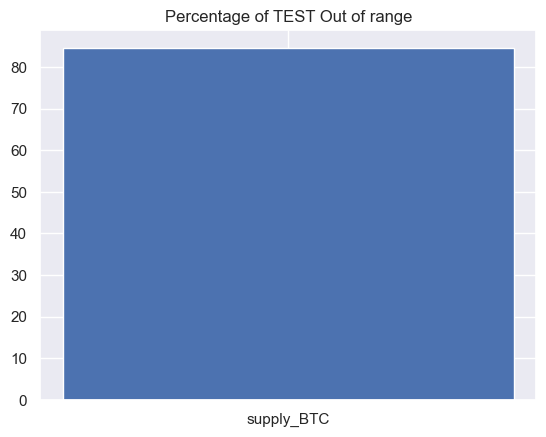

In [92]:
fig, ax = plt.subplots()
ax.bar(df_count_out.xs("pc_out_max").index.tolist(), df_count_out.xs("pc_out_max").values)
ax.bar(df_count_out.xs("pc_out_min").index.tolist(), -df_count_out.xs("pc_out_min").values)
ax.set_title("Percentage of TEST Out of range")

Text(0.5, 1.0, 'Features scaled boxplot')

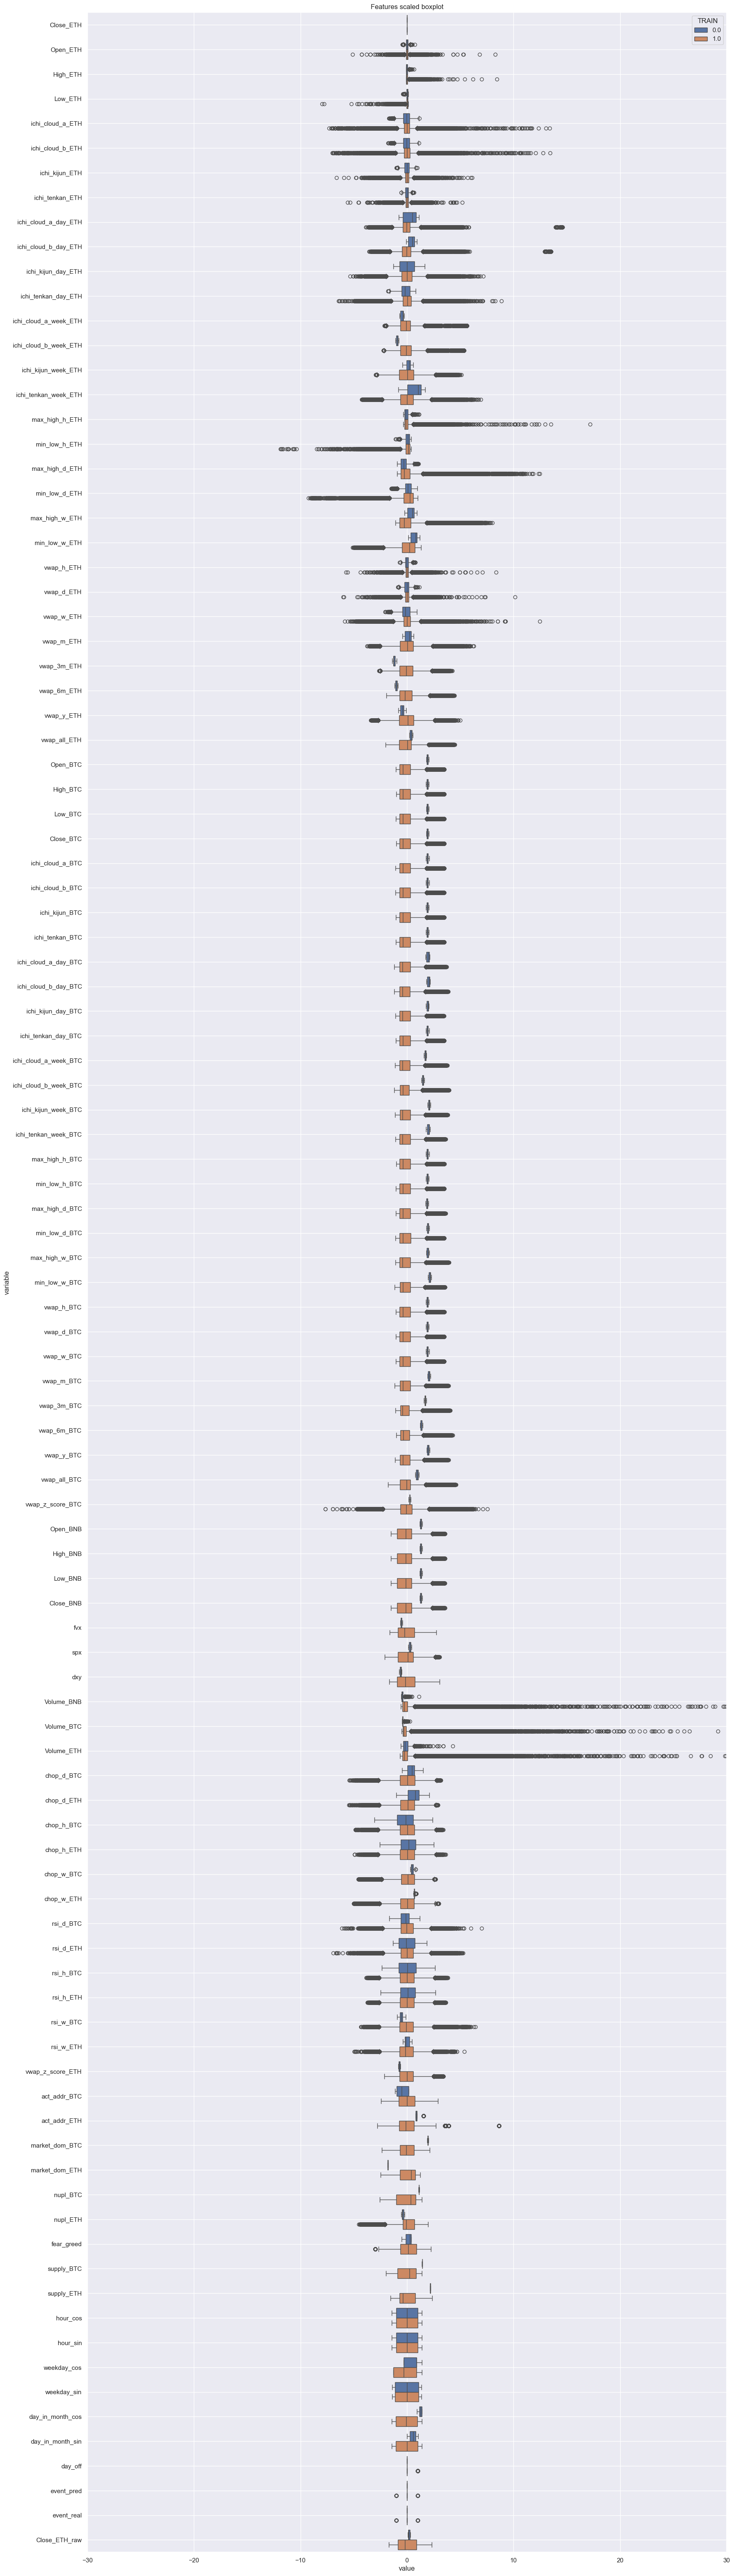

In [93]:
df_comp = df.melt(id_vars=["TRAIN"], value_vars=list_col_select, value_name="value")
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="value", y="variable" , hue="TRAIN")
fig = plt.gcf()
ax = fig.gca()
ax.set_xlim([-30,30])
ax.yaxis.grid(True)
plt.title("Features scaled boxplot")

In [94]:
df_comp[(df_comp["TRAIN"] == True) & (df_comp["variable"] == "day_off")]["value"].unique()

array([0., 1.])

In [95]:
df_comp[(df_comp["TRAIN"] == True) & (df_comp["variable"] == "day_off")]["value"].unique()


array([0., 1.])

In [96]:
df_comp[(df_comp["TRAIN"] == False) & (df_comp["variable"] == "day_off")]["value"].unique()

array([0.])

<Axes: >

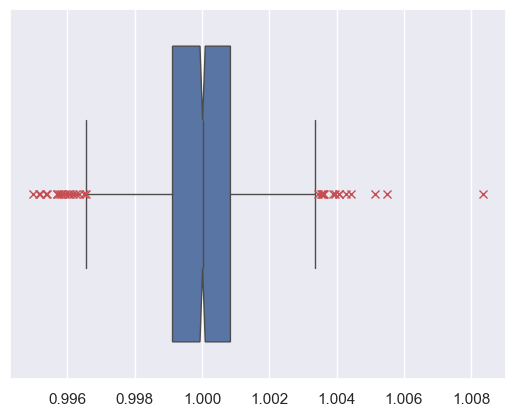

In [97]:
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    notch=True,
    flierprops={"markeredgecolor":"r", "marker": "x"}
)

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_93901/4208190987.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


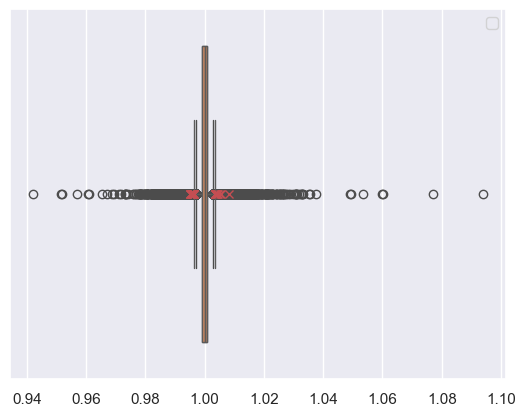

In [98]:
ax = sns.boxplot(
    x=X_train_dat[:,-1,:][:,1],  
)
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    ax=ax, 
    flierprops={"markeredgecolor":"r", "marker": "x"},
)
plt.legend(loc='upper right')

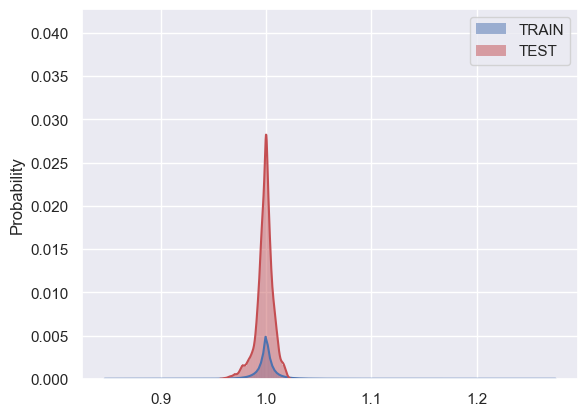

In [99]:

ax = sns.histplot(x=X_train_dat.reshape(-1, X_train_dat.shape[-1])[:,0],  stat="probability", kde=True, label="TRAIN")
sns.histplot(
    x=X_test.reshape(-1, X_test.shape[-1])[:,0],  
    stat="probability", 
    kde=True, 
    ax=ax, 
    color="r",
    label="TEST")
plt.legend(loc='upper right')

## Correlation

To simplify, we try to find correlation between all features X t-0 and target y t+1

In [100]:
def plot_hist_cat(x, data, title):
    '''
    Plot histogram count of categorical data 
    Add proportional information
    '''
    ser_val = data[x].value_counts(dropna=False)
    pc_val = ser_val.values / data[x].shape[0]

    sns.catplot(x=x, kind="count", palette="ch:.25", data=data, 
                height=5, 
                aspect=1.7,
                order=ser_val.index)
    fig = plt.gcf()
    ax = fig.gca()

    for K, y_val in enumerate(ser_val.values):
        ax.text(K, y_val, '{:.2f}'.format(pc_val[K]))
    
    ax.set_title(title)
    
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    return ser_val

def contingency_table(X, Y, data):
    '''
    Calculate Chi-2 heatmap into contingency table for 
    X event and Y event
    and p value of independance
    '''
    c = data[[X,Y]].pivot_table(index=X, columns=Y, aggfunc=len)

    c = c.fillna(0) # on remplace les valeurs nulles par des 0

    chi2, p, dof, expected = stats.chi2_contingency(c)

    return c, chi2, p, dof, expected



def plot_cont(X, Y, data, liste_cat=None):
    '''
    Calculate Chi-2 heatmap into contingency table for 
    X event and Y event
    '''
    c, chi2, p, dof, expected = contingency_table(X, Y, data)
    print("expected: ", expected)
    
    tx = data[X].value_counts()
    ty = data[Y].value_counts()
    
    cont = c.copy()
    cont.loc[:,"Total"] = tx
    cont.loc["total",:] = ty
    cont.loc["total","Total"] = len(data)
    
    print(cont)

    tx = pd.DataFrame(tx)
    ty = pd.DataFrame(ty)
    tx.columns = ["foo"]
    ty.columns = ["foo"]
    n = len(data)
    indep = tx.dot(ty.T) / n
    
    # calcul du signe (add-on)
    d_sign = (c-indep) / np.fabs(c-indep)
    
    mesure = d_sign * (c-indep)**2 / indep
    
    # patch sign
    xi_n = np.fabs(mesure).sum().sum()
    print("xi_n = ", xi_n)
    
    print("chi2: ", chi2)
    print("dof: ", dof)
    print("p: ", p)
    print(f"We have we have a {100*p:.4f}% chance for H0 to be true.")
    print("H0 : independance of distributions")
    print("H1 : distribution are not independant : we reject H0")
    # plot
    #print(c.shape)
    fig = plt.figure(figsize = (7/5*c.shape[1], 6/4*c.shape[0]))
    sns.heatmap(mesure/xi_n, annot=c, fmt=".0f", center=0)
    ax = fig.gca()
    ax.set_title(Y + "= f( " + X + ")")
    plt.show()
    
    return c

In [101]:
def plot_corr(corr_matrix, title='Corrélation with 2 variables', aspect=None, size=25):
    # Afficher la matrice de corrélation
    if aspect is None:
        aspect = 1
    fig_size = (size, size*len(corr_matrix.index)/len(corr_matrix.columns))
    fig, ax = plt.subplots(figsize=fig_size)
    im = ax.matshow(corr_matrix, aspect=aspect)
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
    plt.title(title)
    fig.colorbar(im)
    plt.show()

### Linear Corr

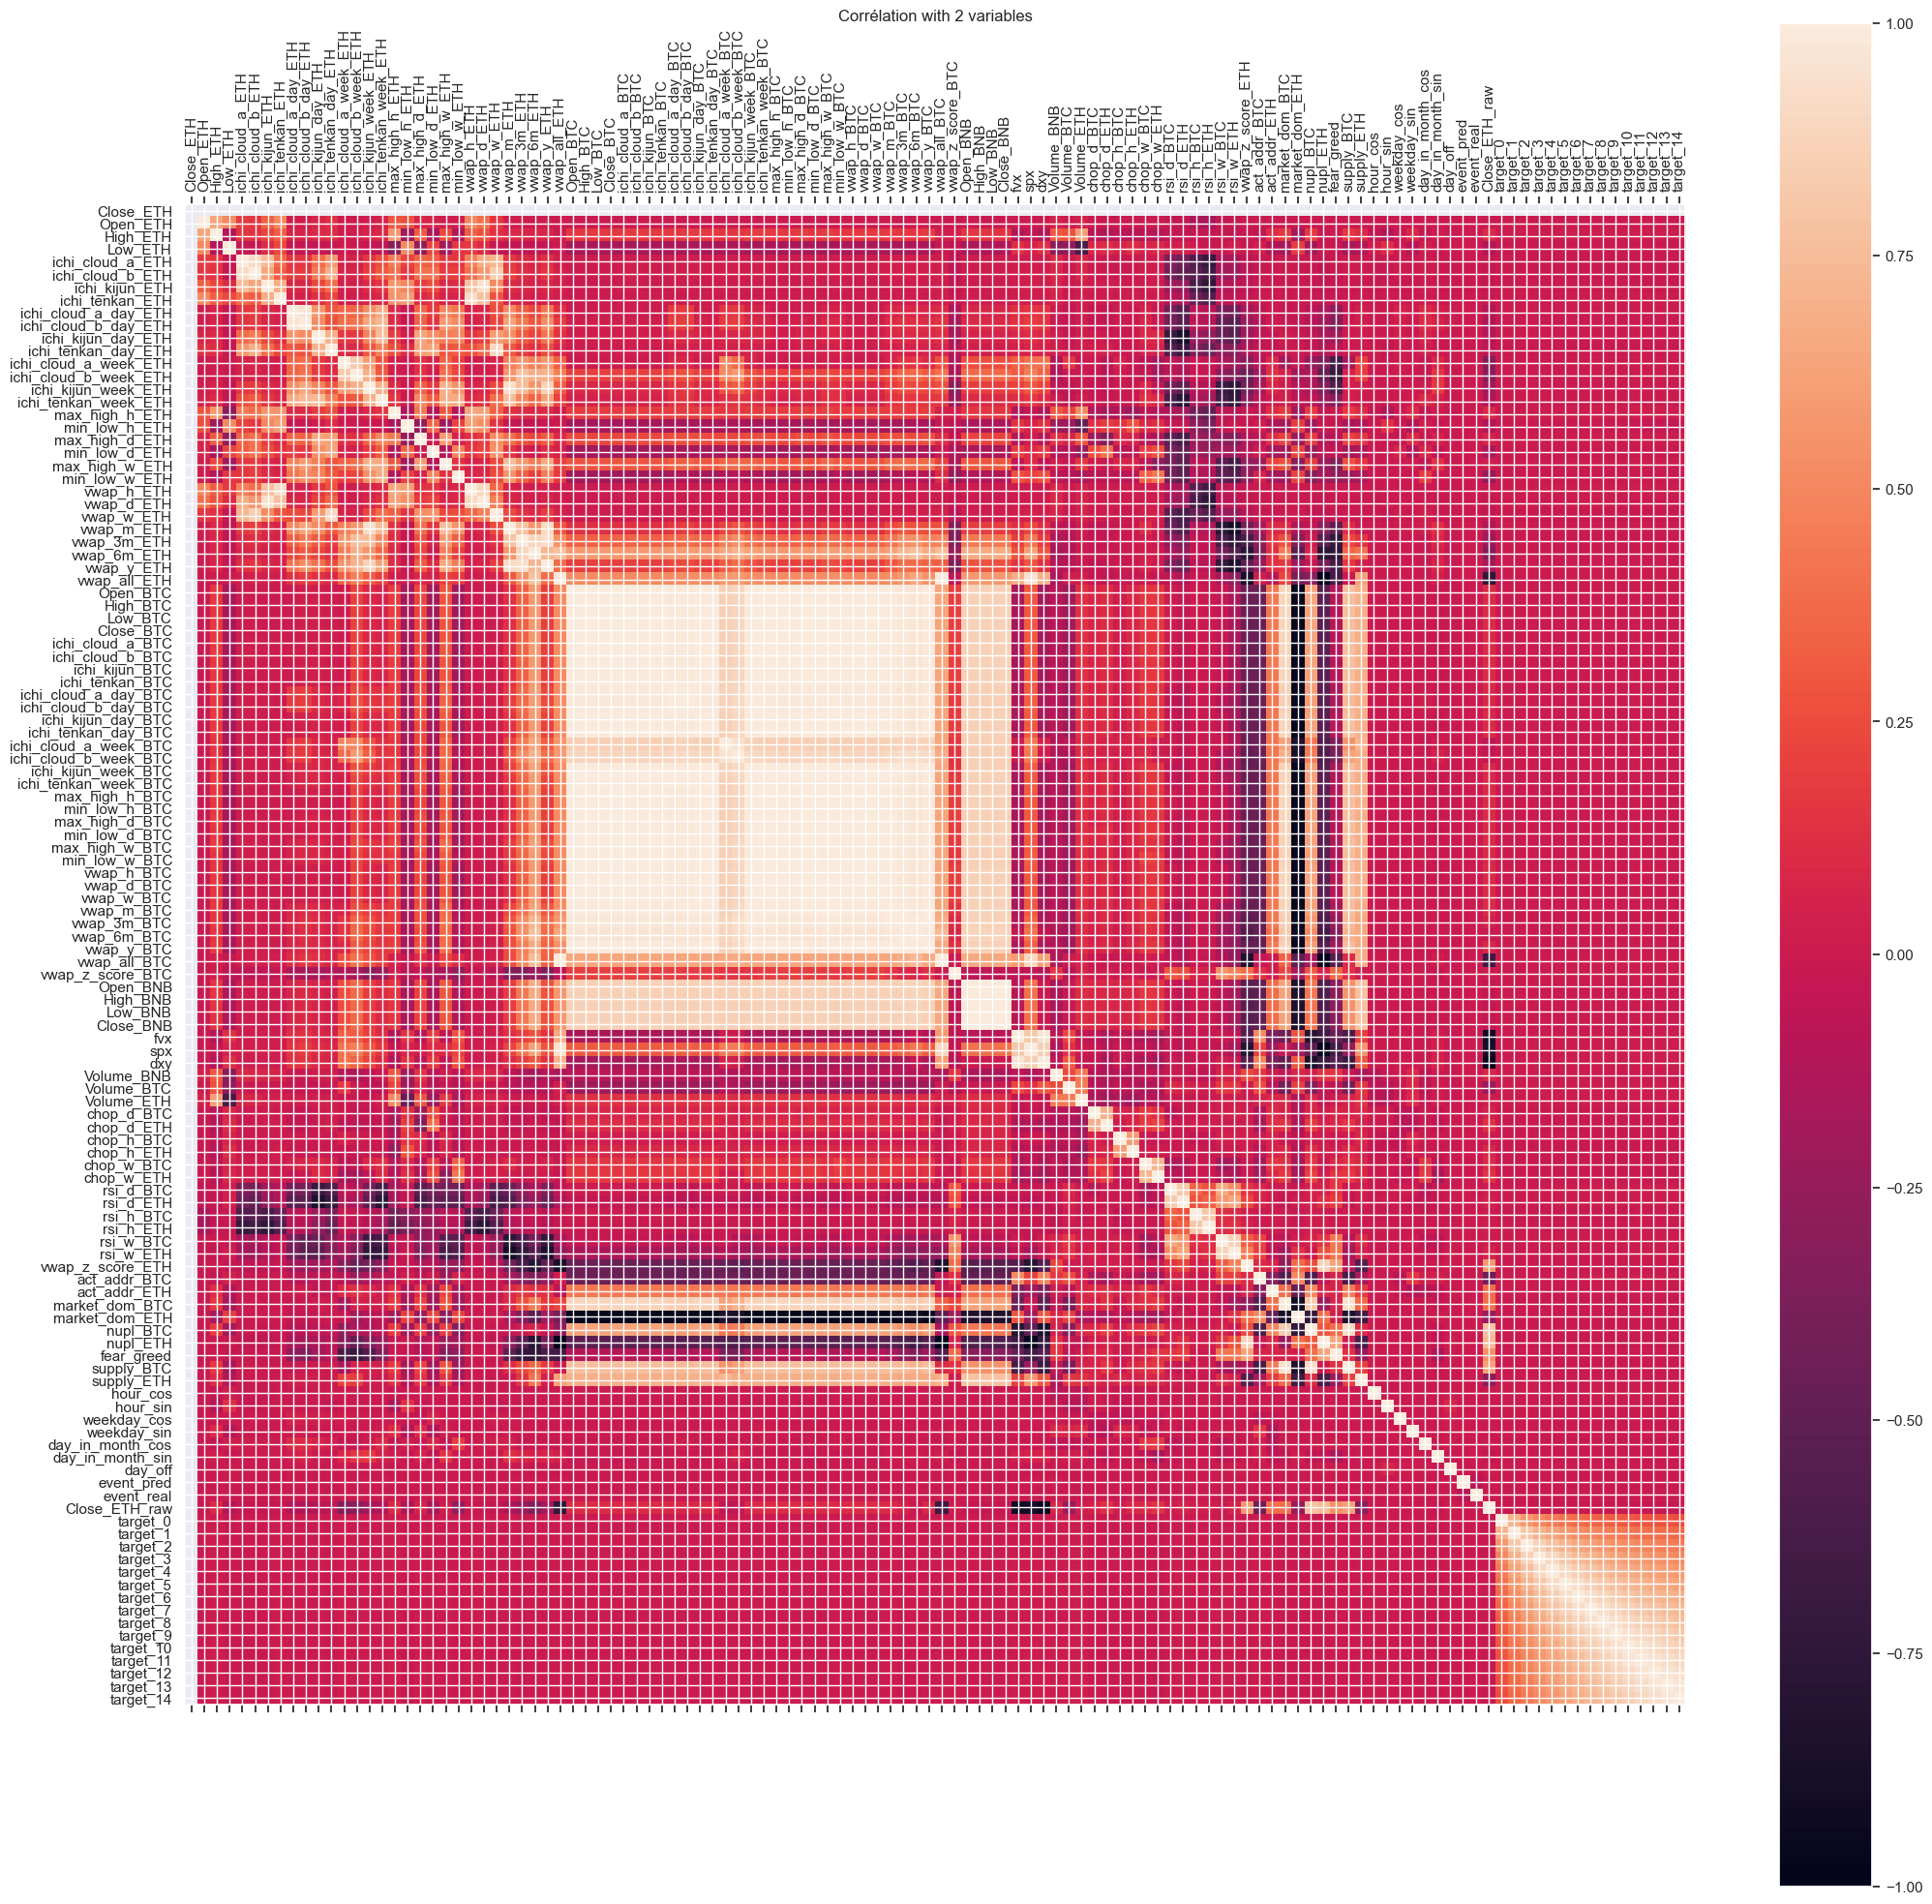

In [102]:
nb_plot = len(list_col_select)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_select[:nb_plot] + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train_dat[:,-1,:nb_plot], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)


In [103]:
y_train.shape

(253677, 15)

In [104]:
list_col_corr

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [105]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [106]:
df.filter(list_col_select)

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0             1.0  0.999782  1.000109  0.999774          0.999171   
1             1.0  0.999548  1.000008  0.999540          0.998785   
2             1.0  1.000084  1.000193  0.999841          0.998860   
3             1.0  1.000770  1.000770  0.999900          0.999669   
4             1.0  0.999330  1.000025  0.999330          0.999178   
...           ...       ...       ...       ...               ...   
253672        1.0  0.998258  1.001698  0.997009          1.009059   
253673        1.0  0.998554  1.001387  0.998451          1.006895   
253674        1.0  1.004900  1.005056  0.999299          1.011829   
253675        1.0  1.001168  1.001491  0.997621          1.011492   
253676        1.0  1.012121  1.014171  0.998487          1.023400   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
0               0.999736        0.998393         0.999464   
1               0.999276        0.998113         0.999184   
2               0.999351        0.998243         0.999477   
3               1.000113        0.999003         1.000239   
4               0.999443        0.998335         0.999569   
...                  ...             ...              ...   
253672          1.012239        1.000323         1.000559   
253673          1.010775        0.998877         0.999113   
253674          1.015728        1.003772         1.004009   
253675          1.015731        1.004944         1.003987   
253676          1.028043        1.011526         1.009147   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...      hour_cos  \
0                   2.024261              2.017807  ...  2.588190e-01   
1                   2.023329              2.016878  ...  6.123234e-17   
2                   2.023482              2.017030  ...  6.123234e-17   
3                   2.025023              2.018567  ...  6.123234e-17   
4                   2.023668              2.017215  ...  6.123234e-17   
...                      ...                   ...  ...           ...   
253672              1.043299              1.026564  ...  9.659258e-01   
253673              1.041791              1.025079  ...  9.659258e-01   
253674              1.046896              1.030103  ...  9.659258e-01   
253675              1.048118              1.031306  ...  9.659258e-01   
253676              1.060823              1.043807  ...  9.659258e-01   

        hour_sin  weekday_cos  weekday_sin  day_in_month_cos  \
0       0.965926     0.623490    -0.781832           0.97953   
1       1.000000     0.623490    -0.781832           0.97953   
2       1.000000     0.623490    -0.781832           0.97953   
3       1.000000     0.623490    -0.781832           0.97953   
4       1.000000     0.623490    -0.781832           0.97953   
...          ...          ...          ...               ...   
253672  0.258819    -0.222521    -0.974928           1.00000   
253673  0.258819    -0.222521    -0.974928           1.00000   
253674  0.258819    -0.222521    -0.974928           1.00000   
253675  0.258819    -0.222521    -0.974928           1.00000   
253676  0.258819    -0.222521    -0.974928           1.00000   

        day_in_month_sin  day_off  event_pred  event_real  Close_ETH_raw  
0           2.012985e-01      0.0         0.0         0.0    1194.540039  
1           2.012985e-01      0.0         0.0         0.0    1195.089966  
2           2.012985e-01      0.0         0.0         0.0    1195.000000  
3           2.012985e-01      0.0         0.0         0.0    1194.089966  
4           2.012985e-01      0.0         0.0         0.0    1194.890015  
...                  ...      ...         ...         ...            ...  
253672     -2.449294e-16      0.0         0.0         0.0    2520.719971  
253673     -2.449294e-16      0.0         0.0         0.0    2524.370117  
253674     -2.449294e-16      0.0         0.0         0.0    2512.060059  
253675     -2.449294e-16      0.0         0.0     

In [107]:
df.filter(list_col_targets)

target_0  target_1  target_2  target_3  target_4  target_5  target_6  \
0       1.000460  1.000385  0.999623  1.000293  0.999816  1.000050  0.999498   
1       0.999925  0.999163  0.999833  0.999356  0.999590  0.999038  0.999046   
2       0.999238  0.999908  0.999431  0.999665  0.999113  0.999121  0.999473   
3       1.000670  1.000193  1.000427  0.999874  0.999883  1.000234  1.000301   
4       0.999523  0.999757  0.999205  0.999213  0.999565  0.999632  0.999565   
...          ...       ...       ...       ...       ...       ...       ...   
253672  1.001448  0.996564  0.995402  0.983481  0.990876  0.990951  0.988297   
253673  0.995124  0.993963  0.982059  0.989443  0.989518  0.986868  0.986836   
253674  0.998834  0.986871  0.994292  0.994367  0.991704  0.991672  0.992440   
253675  0.988024  0.995453  0.995528  0.992862  0.992830  0.993599  0.991049   
253676  1.007519  1.007596  1.004897  1.004865  1.005643  1.003062  1.010629   

        target_7  target_8  target_9  target_10  target_11  target_12  \
0       0.999506  0.999858  0.999925   0.999858   1.000226   0.999891   
1       0.999398  0.999464  0.999398   0.999766   0.999431   0.999690   
2       0.999540  0.999473  0.999841   0.999506   0.999766   0.999473   
3       1.000234  1.000603  1.000268   1.000528   1.000234   0.999640   
4       0.999933  0.999598  0.999858   0.999565   0.998971   0.998686   
...          ...       ...       ...        ...        ...        ...   
253672  0.988265  0.989031  0.986492   0.993934   0.995977   0.997667   
253673  0.987601  0.985066  0.992497   0.994537   0.996225   0.993384   
253674  0.989893  0.997361  0.999411   1.001107   0.998252   0.997170   
253675  0.998525  1.000578  1.002276   0.999418   0.998334   0.994448   
253676  1.012706  1.014425  1.011533   1.010435   1.006502   1.009294   

        target_13  target_14  
0        1.000151   0.999858  
1        0.999398   0.998803  
2        0.998879   0.998594  
3        0.999355   1.000427  
4        0.999757   0.999732  
...           ...        ...  
253672   0.994823   0.993744  
253673   0.992307   0.988445  
253674   0.993288   0.996043  
253675   0.997206   0.995803  
253676   1.007874   1.007934  

[253677 rows x 15 columns]

In [108]:
df["Close_ETH_raw"].corr(df["target_14"])

np.float64(-0.01767952024837609)

In [109]:
df.filter(list_col_select).corrwith(df["target_14"])

/Users/gregory/miniforge3/envs/openbb_01/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/gregory/miniforge3/envs/openbb_01/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Close_ETH                NaN
Open_ETH            0.006258
High_ETH            0.021161
Low_ETH            -0.014519
ichi_cloud_a_ETH   -0.008137
                      ...   
day_in_month_sin   -0.001319
day_off             0.000980
event_pred         -0.002843
event_real          0.000742
Close_ETH_raw      -0.017680
Length: 103, dtype: float64

In [110]:
df.filter(list_col_select).corrwith(df.filter(list_col_targets))

Close_BNB          NaN
Close_BTC          NaN
Close_ETH          NaN
Close_ETH_raw      NaN
High_BNB           NaN
                    ..
vwap_y_ETH         NaN
vwap_z_score_BTC   NaN
vwap_z_score_ETH   NaN
weekday_cos        NaN
weekday_sin        NaN
Length: 118, dtype: float64

In [111]:
len(list_col_select)

103

In [112]:
nb_plot

103

In [113]:
# check if new  data in df_feat
# hash inputs
hash_correl_inputs = (
    get_data_hash(df_feat) + 
    get_data_hash(PAST_HISTORY) + 
    get_data_hash(FUTURE_TARGET) +
    get_data_hash(X_train_dat[:, 0, :nb_plot])
)
# load old file hash
path_correl_hash = os.path.join(path_data, 'correl_inputs_hash.txt')
hash_correl_inputs_old = load_hash(path_correl_hash)

# compare hash
if hash_correl_inputs == hash_correl_inputs_old:
    print("hash match: mode LOAD correl ")
    # load data output
    arr_corr_matrix_targets = np.load(path_arr_corr_matrix_targets)
    mode_correl = False
else:
    print("hash not match : mode REDO correl")
    mode_correl = True

hash match: mode LOAD correl 


In [114]:
# Assuming the following variables are pre-defined from your environment:
# PAST_HISTORY: int
# X_train_dat: np.ndarray (e.g., shape: num_samples, total_past_steps, num_total_features)
# y_train: np.ndarray (e.g., shape: num_samples, num_targets or num_samples for single target)
# list_col_select: list of strings (names of all features)
# nb_plot: int (number of features to use from X_train_dat, e.g., list_col_select[:nb_plot])
# list_col_targets: list of strings (names of target columns)
# list_col_corr: list of strings (from original code, not strictly needed for optimized version but was used for column naming in the old approach)
# These are the names of the feature columns we'll be selecting from X_train_dat.
# These will form the row index of our correlation matrix for each I_past.
feature_names_to_correlate = list_col_select[:nb_plot]

if mode_correl:
    # Optimized code for calculating correlations:
    list_corr_optimized = []
    # Create a DataFrame for the target(s) once, as it's constant across I_past iterations.
    # This assumes y_train has columns corresponding to list_col_targets.
    # If y_train is 1D (num_samples,), list_col_targets should contain one target name.
    y_train_df = pd.DataFrame(y_train, columns=list_col_targets)

    for I_past in range(PAST_HISTORY):
        # Extract the relevant feature data for the current I_past step
        # Shape: (num_samples, nb_plot)
        current_X_data = X_train_dat[:, I_past, :nb_plot]
        
        # Create a DataFrame for the features of the current I_past step
        df_features = pd.DataFrame(current_X_data, columns=feature_names_to_correlate)
        
        # Initialize a DataFrame to store correlations for this I_past step
        # Rows: features (feature_names_to_correlate)
        # Columns: targets (list_col_targets)
        # This ensures consistent shape and ordering.
        corr_matrix_for_this_past_step = pd.DataFrame(
            index=feature_names_to_correlate,
            columns=list_col_targets,
            dtype=float  # Ensure float type for correlations
        )
        
        # Calculate correlation of all features with each target column
        for target_col_name in list_col_targets:
            # df_features.corrwith() computes the correlation of each column in df_features
            # with the provided Series (y_train_df[target_col_name]).
            # The result is a Series indexed by feature_names_to_correlate.
            corrs_with_target = df_features.corrwith(y_train_df[target_col_name])
            corr_matrix_for_this_past_step[target_col_name] = corrs_with_target
                
        list_corr_optimized.append(corr_matrix_for_this_past_step)

    # Convert the list of DataFrames to a 3D NumPy array
    # Each DataFrame in list_corr_optimized has shape (len_feat, len_targets)
    # So, arr_corr_matrix_targets will have shape (PAST_HISTORY, len_feat, len_targets)
    # The final variable name 'arr_corr_matrix_targets' matches the original script's output.
    arr_corr_matrix_targets = np.array([df.values for df in list_corr_optimized])
    np.save(path_arr_corr_matrix_targets, arr_corr_matrix_targets)
    # save hash
    with open(path_correl_hash, 'w') as file:
        file.write(hash_correl_inputs)
        
# To check the shape (optional, similar to original script's last line intent):
print(arr_corr_matrix_targets.shape)

(72, 103, 15)


In [ ]:
min_corr = np.min(arr_corr_matrix_targets, axis=0)
# create a same col/row than corr_matrix_targets  dataframe using the array max_corr 
min_corr_matrix_targets = pd.DataFrame(min_corr, columns=list_col_targets, index=feature_names_to_correlate)
min_corr_matrix_targets

target_0  target_1  target_2  target_3  target_4  target_5  \
Close_ETH              NaN       NaN       NaN       NaN       NaN       NaN   
Open_ETH         -0.001701 -0.002949 -0.004338 -0.004786 -0.005536 -0.006069   
High_ETH         -0.000797 -0.002178 -0.003831 -0.004392 -0.004896 -0.005219   
Low_ETH          -0.016817 -0.009355 -0.013130 -0.010434 -0.012921 -0.014196   
ichi_cloud_a_ETH -0.001333 -0.002698 -0.004206 -0.004785 -0.005420 -0.005741   
...                    ...       ...       ...       ...       ...       ...   
day_in_month_sin -0.000398 -0.000557 -0.000692 -0.000797 -0.000877 -0.000949   
day_off          -0.001658 -0.001925 -0.002138 -0.002449 -0.002720 -0.002928   
event_pred       -0.007535 -0.007502 -0.007099 -0.006575 -0.007400 -0.007414   
event_real       -0.006934 -0.005017 -0.006066 -0.006793 -0.007159 -0.006455   
Close_ETH_raw    -0.004679 -0.006619 -0.008133 -0.009389 -0.010496 -0.011500   

                  target_6  target_7  target_8  target_9  target_10  \
Close_ETH              NaN       NaN       NaN       NaN        NaN   
Open_ETH         -0.006341 -0.006946 -0.007559 -0.008070  -0.008769   
High_ETH         -0.005530 -0.006099 -0.006690 -0.007125  -0.007764   
Low_ETH          -0.012469 -0.012652 -0.013120 -0.012089  -0.012053   
ichi_cloud_a_ETH -0.006049 -0.006704 -0.007392 -0.007962  -0.008725   
...                    ...       ...       ...       ...        ...   
day_in_month_sin -0.001011 -0.001072 -0.001131 -0.001170  -0.001207   
day_off          -0.002984 -0.003063 -0.003417 -0.003756  -0.004137   
event_pred       -0.008150 -0.008197 -0.007157 -0.007306  -0.006725   
event_real       -0.006324 -0.005582 -0.005122 -0.005386  -0.005777   
Close_ETH_raw    -0.012413 -0.013273 -0.014083 -0.014851  -0.015591   

                  target_11  target_12  target_13  target_14  
Close_ETH               NaN        NaN        NaN        NaN  
Open_ETH          -0.009670  -0.010539  -0.011152  -0.011719  
High_ETH          -0.008598  -0.009396  -0.010045  -0.010533  
Low_ETH           -0.012555  -0.013287  -0.014501  -0.014519  
ichi_cloud_a_ETH  -0.009675  -0.010512  -0.011161  -0.011769  
...                     ...        ...        ...        ...  
day_in_month_sin  -0.001238  -0.001268  -0.001295  -0.001330  
day_off           -0.004513  -0.004813  -0.004936  -0.004976  
event_pred        -0.006705  -0.006893  -0.006448  -0.006236  
event_real        -0.005484  -0.005540  -0.005085  -0.005007  
Close_ETH_raw     -0.016306  -0.016993  -0.017642  -0.018262  

[103 rows x 15 columns]

In [116]:
max_corr = np.max(arr_corr_matrix_targets, axis=0)
# create a same col/row thatn corr_matrix_targets  dataframe using the array max_corr 
max_corr_matrix_targets = pd.DataFrame(max_corr, columns=list_col_targets, index=feature_names_to_correlate)
max_corr_matrix_targets

target_0  target_1  target_2  target_3  target_4  target_5  \
Close_ETH              NaN       NaN       NaN       NaN       NaN       NaN   
Open_ETH          0.012652  0.012706  0.007384  0.008588  0.009448  0.010770   
High_ETH          0.014405  0.018180  0.013382  0.014009  0.015279  0.018274   
Low_ETH           0.009441  0.007320  0.005701  0.006453  0.007151  0.007921   
ichi_cloud_a_ETH  0.001506  0.000691 -0.000851 -0.001260 -0.001769 -0.002025   
...                    ...       ...       ...       ...       ...       ...   
day_in_month_sin -0.000037 -0.000059 -0.000090 -0.000110 -0.000128 -0.000139   
day_off           0.004958  0.006637  0.008144  0.009304  0.010308  0.011129   
event_pred        0.006938  0.005788  0.004485  0.004810  0.004764  0.005232   
event_real        0.011923  0.007592  0.006667  0.005395  0.004392  0.004200   
Close_ETH_raw    -0.004416 -0.006272 -0.007722 -0.008909 -0.009972 -0.010923   

                  target_6  target_7  target_8  target_9  target_10  \
Close_ETH              NaN       NaN       NaN       NaN        NaN   
Open_ETH          0.011687  0.012110  0.012257  0.012759   0.012753   
High_ETH          0.017810  0.018056  0.017313  0.018760   0.019101   
Low_ETH           0.008671  0.008909  0.008904  0.009035   0.008812   
ichi_cloud_a_ETH -0.002226 -0.003052 -0.003963 -0.004472  -0.005133   
...                    ...       ...       ...       ...        ...   
day_in_month_sin -0.000152 -0.000167 -0.000178 -0.000191  -0.000202   
day_off           0.011804  0.012297  0.012856  0.013461   0.014119   
event_pred        0.005445  0.004738  0.004550  0.004258   0.003870   
event_real        0.003522  0.003433  0.003092  0.002819   0.003152   
Close_ETH_raw    -0.011811 -0.012650 -0.013433 -0.014165  -0.014874   

                  target_11  target_12  target_13  target_14  
Close_ETH               NaN        NaN        NaN        NaN  
Open_ETH           0.011976   0.011651   0.011450   0.011046  
High_ETH           0.019312   0.019143   0.019121   0.021161  
Low_ETH            0.007964   0.007265   0.006881   0.006597  
ichi_cloud_a_ETH  -0.006133  -0.006962  -0.007598  -0.008137  
...                     ...        ...        ...        ...  
day_in_month_sin  -0.000216  -0.000219  -0.000213  -0.000205  
day_off            0.014685   0.015103   0.015379   0.015643  
event_pred         0.003168   0.003361   0.003661   0.003109  
event_real         0.002568   0.003172   0.002769   0.002828  
Close_ETH_raw     -0.015564  -0.016217  -0.016848  -0.017458  

[103 rows x 15 columns]

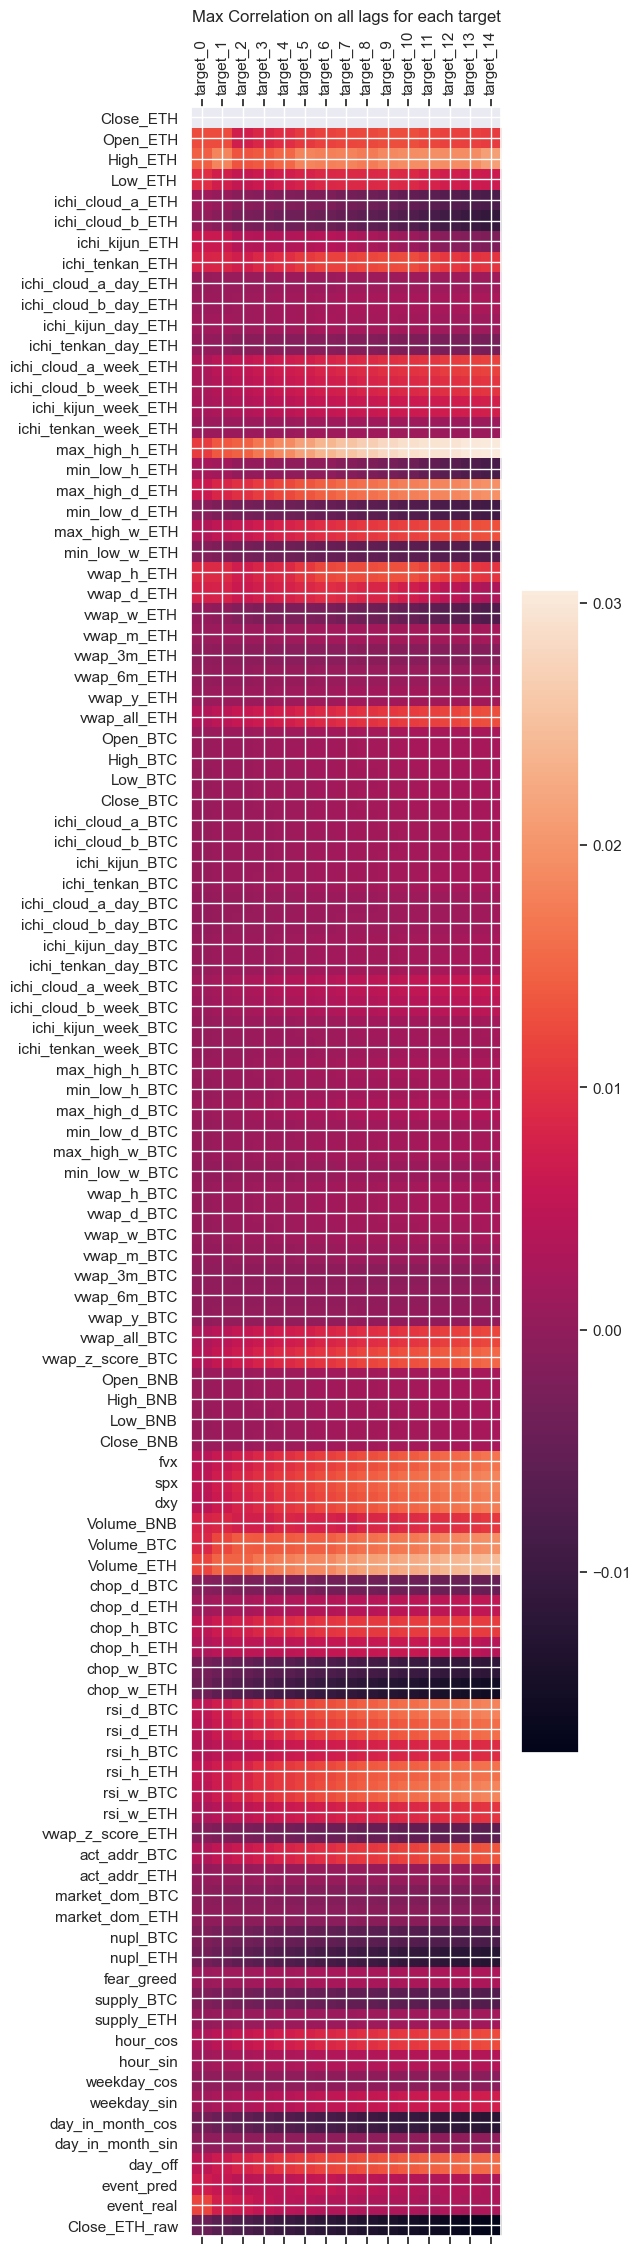

In [117]:
#corr_matrix_targets = corr_matrix.copy().loc[list_col_select[:nb_plot], list_col_targets]
fig = plot_corr(max_corr_matrix_targets, title = "Max Correlation on all lags for each target", size=5)

In [118]:
arr_corr_matrix_targets.shape

(72, 103, 15)

In [119]:

# create a same col/row thatn corr_matrix_targets  dataframe using the array max_corr 
corr_matrix_targets = pd.DataFrame(arr_corr_matrix_targets[-1,:,:], columns=list_col_targets, index=feature_names_to_correlate)
corr_matrix_targets

target_0  target_1  target_2  target_3  target_4  target_5  \
Close_ETH              NaN       NaN       NaN       NaN       NaN       NaN   
Open_ETH          0.009073  0.012706  0.005011  0.005306  0.003014  0.002964   
High_ETH          0.014071  0.018180  0.013382  0.014009  0.015279  0.018274   
Low_ETH          -0.016817 -0.009355 -0.013130 -0.010434 -0.012921 -0.014196   
ichi_cloud_a_ETH  0.001506  0.000691 -0.000851 -0.001260 -0.001769 -0.002025   
...                    ...       ...       ...       ...       ...       ...   
day_in_month_sin -0.000296 -0.000423 -0.000544 -0.000668 -0.000773 -0.000863   
day_off           0.001504  0.001980  0.002029  0.002108  0.002348  0.002265   
event_pred       -0.001765 -0.002056 -0.004927 -0.006495 -0.006435 -0.004693   
event_real       -0.000192 -0.000444 -0.000892 -0.000309 -0.000999  0.001766   
Close_ETH_raw    -0.004584 -0.006471 -0.007914 -0.009142 -0.010221 -0.011200   

                  target_6  target_7  target_8  target_9  target_10  \
Close_ETH              NaN       NaN       NaN       NaN        NaN   
Open_ETH          0.005411  0.006158  0.005031  0.005796   0.007312   
High_ETH          0.017810  0.018056  0.017313  0.018760   0.019101   
Low_ETH          -0.012469 -0.012652 -0.013120 -0.012089  -0.012053   
ichi_cloud_a_ETH -0.002226 -0.003052 -0.003963 -0.004472  -0.005133   
...                    ...       ...       ...       ...        ...   
day_in_month_sin -0.000939 -0.001006 -0.001069 -0.001122  -0.001173   
day_off           0.002448  0.002551  0.002508  0.002349   0.002198   
event_pred       -0.005406 -0.006106 -0.004600 -0.004791  -0.004072   
event_real        0.002126  0.000963  0.001933  0.001213   0.000671   
Close_ETH_raw    -0.012098 -0.012931 -0.013712 -0.014452  -0.015153   

                  target_11  target_12  target_13  target_14  
Close_ETH               NaN        NaN        NaN        NaN  
Open_ETH           0.006586   0.005397   0.005068   0.006258  
High_ETH           0.019312   0.019143   0.019121   0.021161  
Low_ETH           -0.012555  -0.013287  -0.014501  -0.014519  
ichi_cloud_a_ETH  -0.006133  -0.006962  -0.007598  -0.008137  
...                     ...        ...        ...        ...  
day_in_month_sin  -0.001227  -0.001266  -0.001291  -0.001319  
day_off            0.002044   0.001500   0.001213   0.000980  
event_pred        -0.003568  -0.003976  -0.004773  -0.002843  
event_real         0.000769   0.001015   0.000718   0.000742  
Close_ETH_raw     -0.015822  -0.016463  -0.017082  -0.017680  

[103 rows x 15 columns]

#### Best Max Corr Features

In [440]:
# (72, 103, 15)
ind = np.unravel_index(
    np.argsort(np.nan_to_num(arr_corr_matrix_targets, nan=0.0), axis=None), 
    arr_corr_matrix_targets.shape,
)
# 30th first features
nb_lag_corr_max = 50
# for lag_curr, feat_curr, target_curr in zip(ind[0][-nb_lag_corr_max:], ind[1][-nb_lag_corr_max:], ind[2][-nb_lag_corr_max:]): #ind[0][-30:]
    
#     corr_curr = arr_corr_matrix_targets[lag_curr, feat_curr, target_curr]
#     print(f"{feature_names_to_correlate[feat_curr]}, lag: {lag_curr}, target: {target_curr}, corr: {corr_curr}")

# 1. Get the slices of your indices
lags = ind[0][-nb_lag_corr_max:]
feature_indices = ind[1][-nb_lag_corr_max:]
target_indices = ind[2][-nb_lag_corr_max:]

# 2. Create the DataFrame from a dictionary of lists
corr_max_df_efficient = pd.DataFrame({
    'Feature': [feature_names_to_correlate[i] for i in feature_indices],
    'Lag': lags,
    'Target': target_indices,
    'Correlation': [arr_corr_matrix_targets[lag, feat, targ] for lag, feat, targ in zip(lags, feature_indices, target_indices)]
})

corr_max_df_efficient.sort_values(by='Correlation', ascending=False)


Feature  Lag  Target  Correlation
49  max_high_h_ETH   71      14     0.030522
48  max_high_h_ETH   71      13     0.030174
47  max_high_h_ETH   71      12     0.029767
46  max_high_h_ETH   71      11     0.029400
45  max_high_h_ETH   70      14     0.029298
44  max_high_h_ETH   70      13     0.029242
43  max_high_h_ETH   71      10     0.029076
42  max_high_h_ETH   70      11     0.028983
41  max_high_h_ETH   70      12     0.028974
40  max_high_h_ETH   70      10     0.028848
39  max_high_h_ETH   71       9     0.028178
38  max_high_h_ETH   69      10     0.028046
37  max_high_h_ETH   70       9     0.028008
36  max_high_h_ETH   69      11     0.027851
35  max_high_h_ETH   69      13     0.027758
34  max_high_h_ETH   69      12     0.027752
33  max_high_h_ETH   69      14     0.027621
32  max_high_h_ETH   69       9     0.027400
31  max_high_h_ETH   68      10     0.027013
30  max_high_h_ETH   70       8     0.026849
29  max_high_h_ETH   68      11     0.026744
28  max_high_h_ETH   68       9     0.026721
27  max_high_h_ETH   71       8     0.026522
26  max_high_h_ETH   68      12     0.026406
25  max_high_h_ETH   69       8     0.026286
24  max_high_h_ETH   68      13     0.026225
23  max_high_h_ETH   67      10     0.025891
22  max_high_h_ETH   68      14     0.025851
21  max_high_h_ETH   68       8     0.025812
20  max_high_h_ETH   67       9     0.025692
19  max_high_h_ETH   70       7     0.025590
18  max_high_h_ETH   69       7     0.025458
17  max_high_h_ETH   67      11     0.025394
16  max_high_h_ETH   67       8     0.025137
15  max_high_h_ETH   71       7     0.025066
14  max_high_h_ETH   68       7     0.025004
13  max_high_h_ETH   67      12     0.024893
12      Volume_ETH   71      14     0.024849
11      Volume_ETH   69      14     0.024698
10  max_high_h_ETH   67       7     0.024509
9   max_high_h_ETH   67      13     0.024484
8   max_high_h_ETH   66       9     0.024484
7   max_high_h_ETH   66      10     0.024442
6       Volume_ETH   68      14     0.024412
5       Volume_ETH   68      13     0.024263
4       Volume_ETH   67      14     0.024243
3       Volume_ETH   40      14     0.024175
2       Volume_ETH   71      13     0.024113
1       Volume_ETH   67      13     0.024075
0   max_high_h_ETH   66       8     0.024017

max_high_h_ETH & Volume_ETH are the best positive impact on price.  
Explanation : 
- have a high higher in the last hour lead to have more chance to have a higher value in the next hour
- volume also  

Direction is kept 


#### Best Min Corr Features

In [465]:
# 1. Get the slices of your indices
lags = ind[0][0:nb_lag_corr_max]
feature_indices = ind[1][0:nb_lag_corr_max]
target_indices = ind[2][0:nb_lag_corr_max]

# 2. Create the DataFrame from a dictionary of lists
corr_min_df_efficient = pd.DataFrame({
    'Feature': [feature_names_to_correlate[i] for i in feature_indices],
    'Lag': lags,
    'Target': target_indices,
    'Correlation': [arr_corr_matrix_targets[lag, feat, targ] for lag, feat, targ in zip(lags, feature_indices, target_indices)]
})

corr_min_df_efficient.sort_values(by='Correlation', ascending=True)

Feature  Lag  Target  Correlation
0   min_low_h_ETH   71      14    -0.021244
1   min_low_h_ETH   71      13    -0.020220
2   min_low_h_ETH   71      12    -0.018750
3   Close_ETH_raw    3      14    -0.018262
4   Close_ETH_raw    2      14    -0.018259
5   Close_ETH_raw    4      14    -0.018252
6   Close_ETH_raw    1      14    -0.018243
7   Close_ETH_raw    5      14    -0.018236
8   Close_ETH_raw    0      14    -0.018228
9   Close_ETH_raw    6      14    -0.018221
10  Close_ETH_raw    7      14    -0.018218
11  Close_ETH_raw    8      14    -0.018209
12  Close_ETH_raw    9      14    -0.018192
13  Close_ETH_raw   10      14    -0.018182
14  Close_ETH_raw   11      14    -0.018169
15  Close_ETH_raw   12      14    -0.018147
16  Close_ETH_raw   13      14    -0.018131
17  Close_ETH_raw   14      14    -0.018124
18  Close_ETH_raw   15      14    -0.018117
19  Close_ETH_raw   16      14    -0.018103
20  Close_ETH_raw   21      14    -0.018085
21  Close_ETH_raw   20      14    -0.018081
22  Close_ETH_raw   19      14    -0.018079
23  Close_ETH_raw   17      14    -0.018078
24  Close_ETH_raw   18      14    -0.018077
25  Close_ETH_raw   22      14    -0.018069
26  Close_ETH_raw   23      14    -0.018063
27  Close_ETH_raw   24      14    -0.018063
28  Close_ETH_raw   25      14    -0.018049
29  Close_ETH_raw   26      14    -0.018040
30  Close_ETH_raw   27      14    -0.018031
31  Close_ETH_raw   28      14    -0.018014
32  Close_ETH_raw   29      14    -0.018000
33  Close_ETH_raw   30      14    -0.017974
34  min_low_h_ETH   70      14    -0.017965
35  Close_ETH_raw   31      14    -0.017955
36  Close_ETH_raw   32      14    -0.017949
37  Close_ETH_raw   33      14    -0.017933
38  Close_ETH_raw   34      14    -0.017925
39  Close_ETH_raw   35      14    -0.017909
40  Close_ETH_raw   37      14    -0.017894
41  Close_ETH_raw   40      14    -0.017894
42  Close_ETH_raw   36      14    -0.017894
43  Close_ETH_raw   39      14    -0.017890
44  Close_ETH_raw   41      14    -0.017889
45  Close_ETH_raw   38      14    -0.017889
46  Close_ETH_raw   42      14    -0.017888
47  Close_ETH_raw   43      14    -0.017883
48  Close_ETH_raw   46      14    -0.017879
49  Close_ETH_raw   45      14    -0.017877

In [445]:
np.nanmin(arr_corr_matrix_targets)

np.float64(-0.02124448282696438)

min_low_h_ETH & Close_ETH_raw are the best negative impact on price.  
Explanation : 
- have a min low higher in the last hour lead to have more chance to have a lower value in the next hour : direction kept
- have a price higher, so return to mean value


#### Last Lag Max Correlation

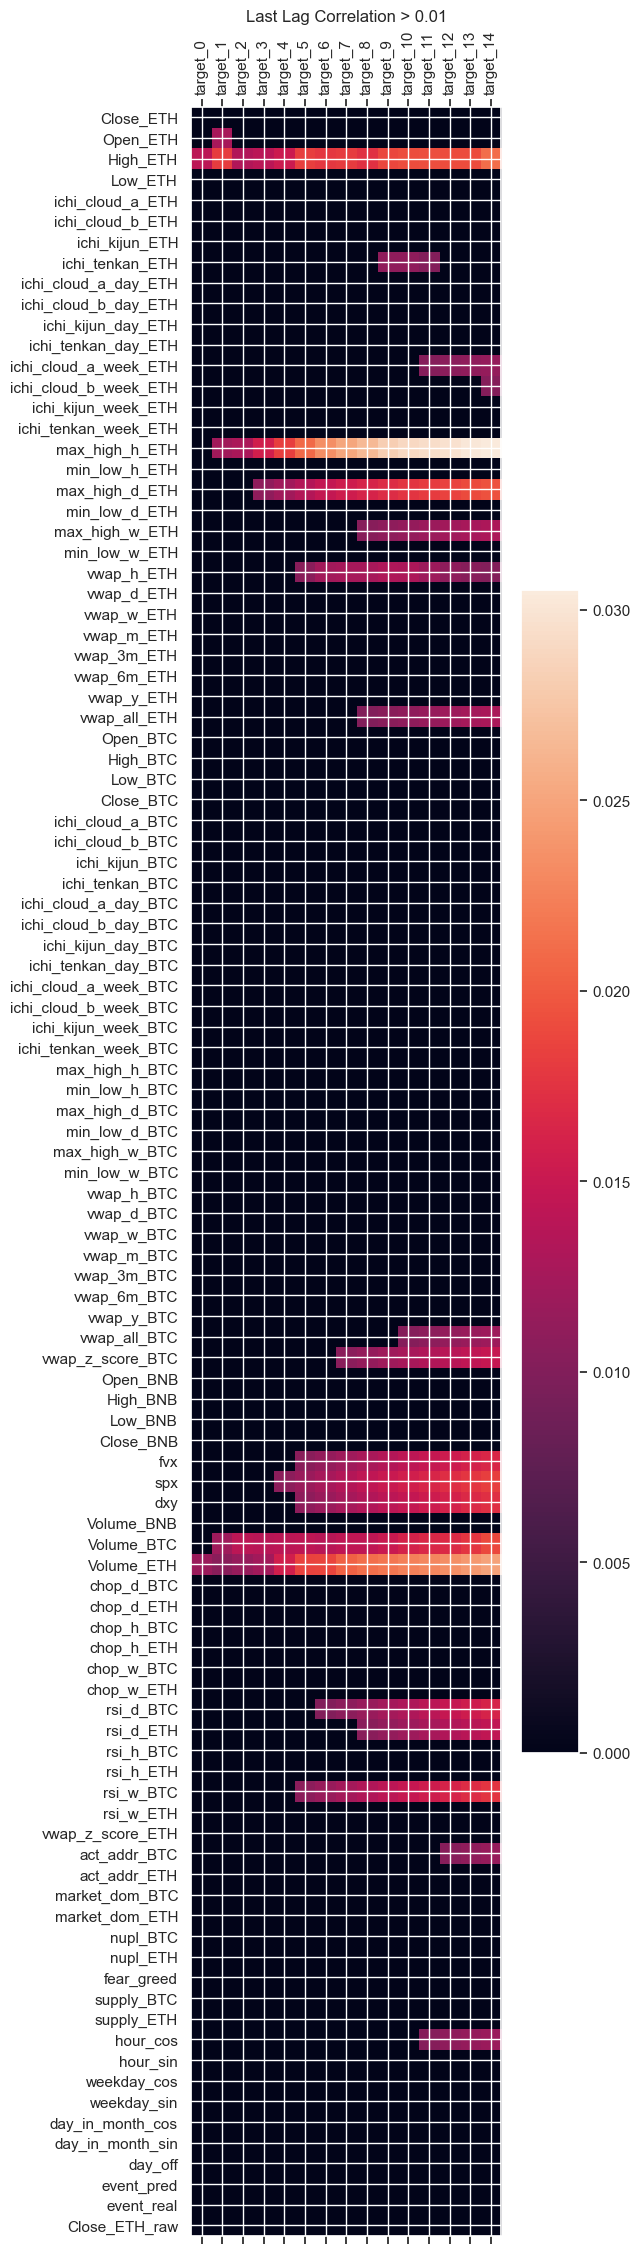

In [120]:
fig = plot_corr(
    corr_matrix_targets.where(corr_matrix_targets>0.01, 0), 
    title = "Last Lag Correlation > 0.01", 
    size=5)

#### Max Correlation on all lags

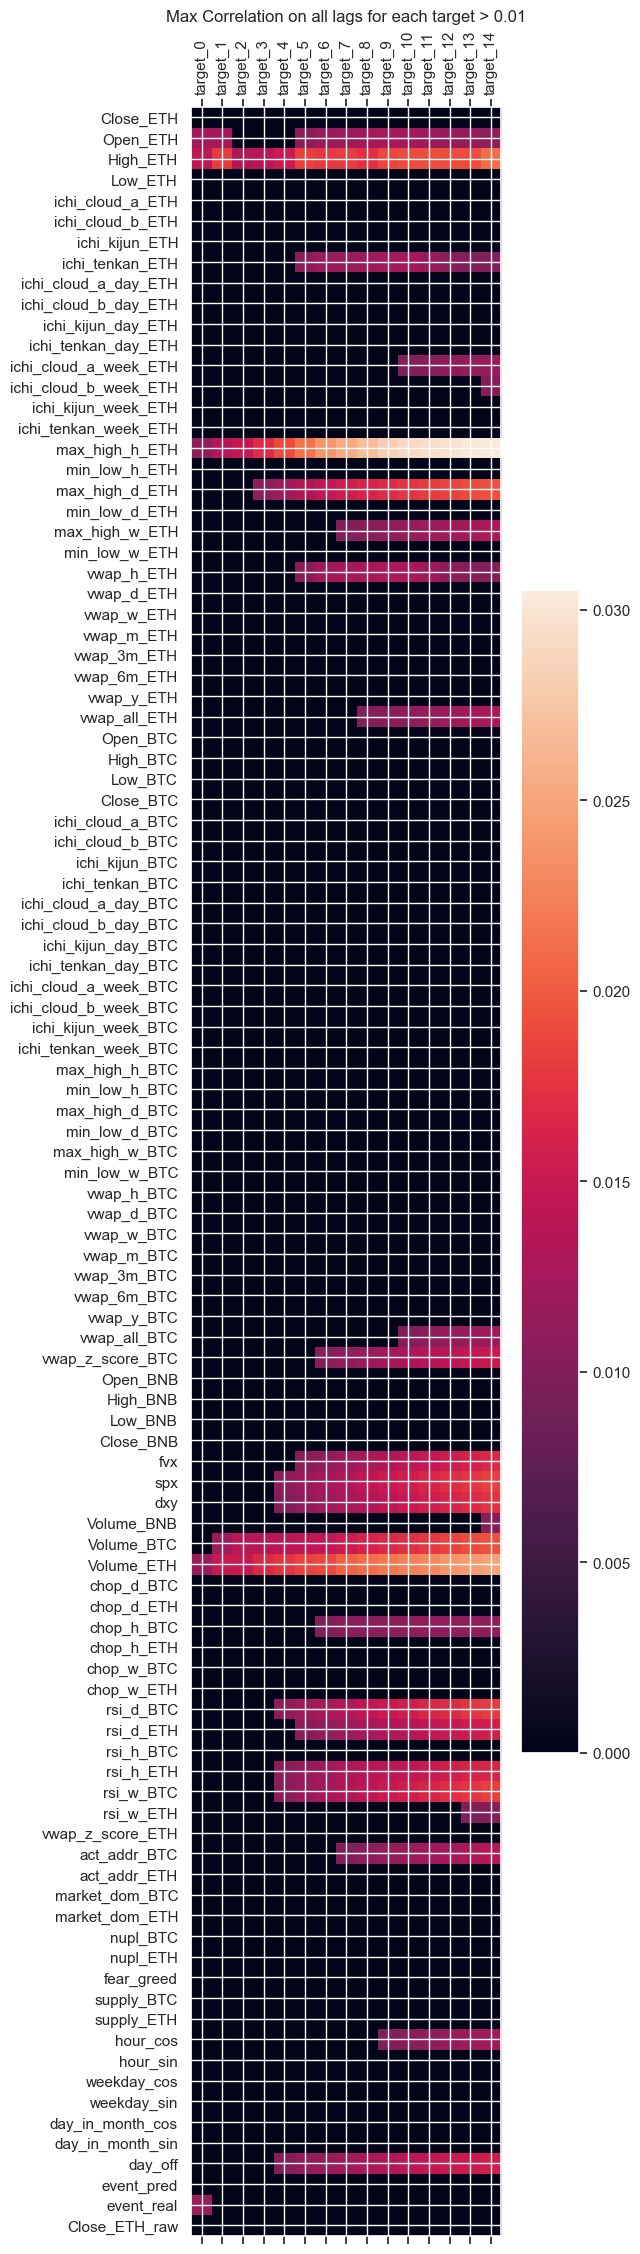

In [121]:
fig = plot_corr(
    max_corr_matrix_targets.where(max_corr_matrix_targets>0.01, 0),
    title="Max Correlation on all lags for each target > 0.01",
    size=5)

<Axes: >

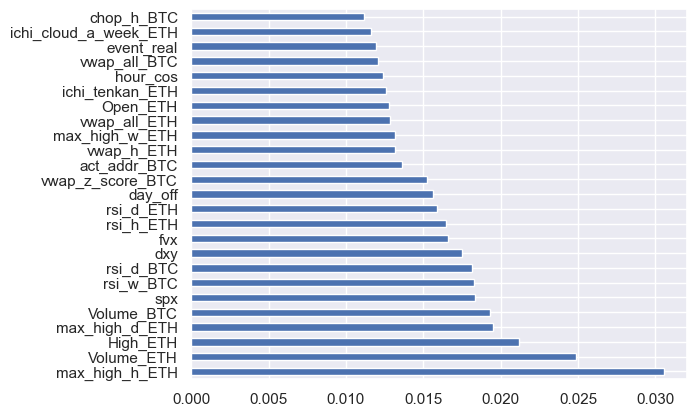

In [122]:
max_max_corr = max_corr_matrix_targets.max(axis=1).sort_values(ascending=False)
max_max_corr[max_max_corr.values>0.011].plot.barh()

#### Test on the highest corr


In [123]:
df = pd.DataFrame(np.hstack((X_train_dat[:, -1, :nb_plot], y_train)), 
        columns=list_col_corr)

In [124]:
df["target_cat"] = "neutral"
df.loc[df["target_14"] >= 1 + 0.5/100, "target_cat"] = "up"
df.loc[df["target_14"] <= 1 - 0.5/100, "target_cat"] = "down"
df["target_cat"].value_counts()

target_cat
neutral    181927
up          36606
down        35144
Name: count, dtype: int64

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_93901/215884474.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x=x, kind="count", palette="ch:.25", data=data,


target_cat
neutral    181927
up          36606
down        35144
Name: count, dtype: int64

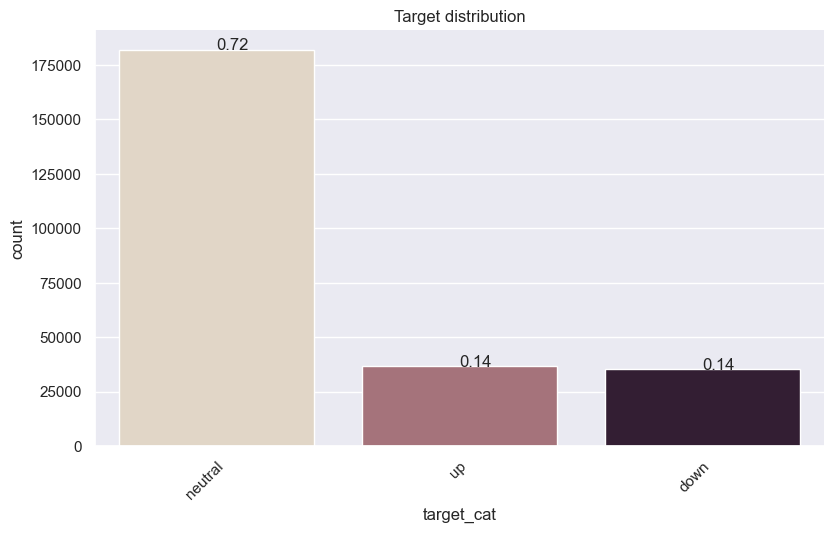

In [125]:
plot_hist_cat("target_cat", df, "Target distribution")

In [126]:
list_level=["neutral", "higher", "very-higher"]
df["max_high_h_ETH_cat"] = "very-higher"
df.loc[df["max_high_h_ETH"] <= 1.01, "max_high_h_ETH_cat"] = "higher"
df.loc[df["max_high_h_ETH"] <= 1.005, "max_high_h_ETH_cat"] = "neutral"

In [127]:
plot_hist_cat("max_high_h_ETH_cat", df, "Max High per hour distribution")

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_93901/215884474.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x=x, kind="count", palette="ch:.25", data=data,


max_high_h_ETH_cat
neutral        179399
higher          50855
very-higher     23423
Name: count, dtype: int64

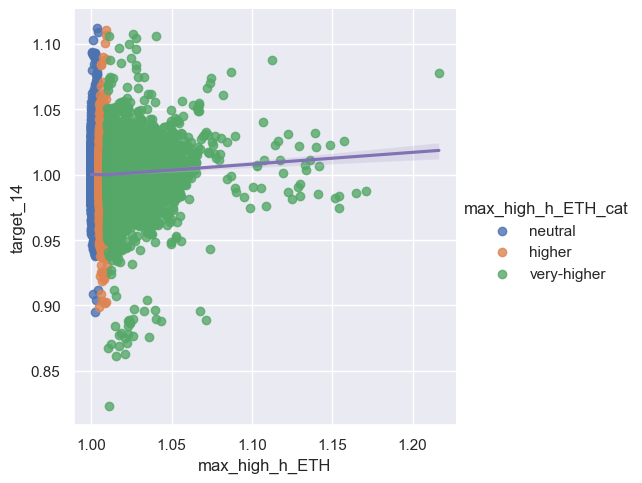

In [128]:
sns.lmplot(x="max_high_h_ETH", y="target_14",
            hue="max_high_h_ETH_cat", data=df,
           line_kws={"color": "C4"})

(0.98, 1.02)

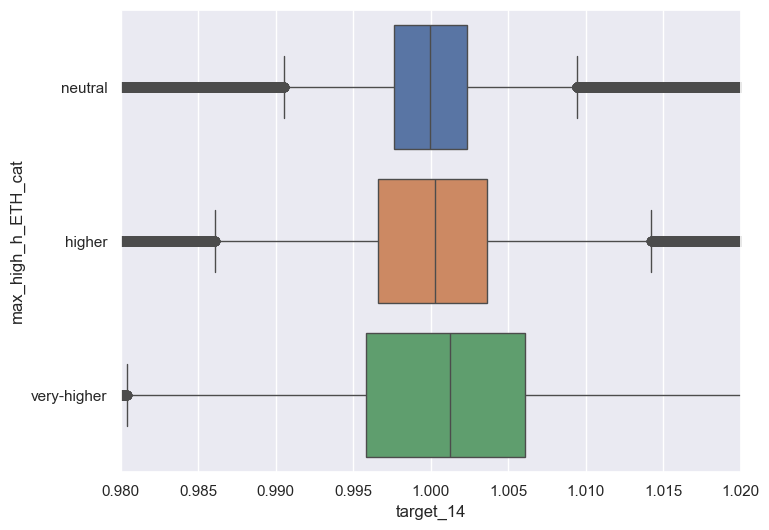

In [129]:
fig = plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x="target_14", y="max_high_h_ETH_cat", 
    hue="max_high_h_ETH_cat", dodge=False, 
    order=list_level, hue_order=list_level)
ax = fig.gca()
ax.set_xlim([0.98,1.02])  

expected:  [[  7045.36918995  36471.17233726   7338.45847278]
 [ 24853.64639285 128657.78873528  25887.56487186]
 [  3244.98441719  16798.03892745   3379.97665535]]
target_cat             down   neutral       up     Total
max_high_h_ETH_cat                                      
higher               9130.0   32532.0   9193.0   50855.0
neutral             20774.0  138189.0  20436.0  179399.0
very-higher          5240.0   11206.0   6977.0   23423.0
total               35144.0  181927.0  36606.0  253677.0
xi_n =  10950.84585392982
chi2:  10950.84585392982
dof:  4
p:  0.0
We have we have a 0.0000% chance for H0 to be true.
H0 : independance of distributions
H1 : distribution are not independant : we reject H0


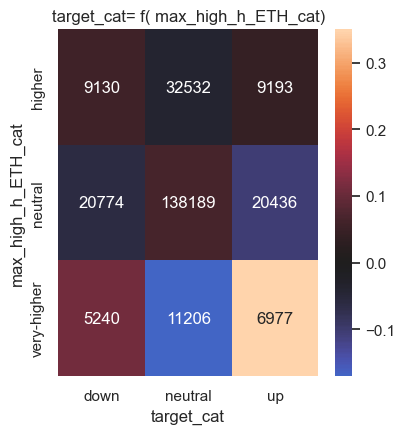

target_cat           down  neutral     up
max_high_h_ETH_cat                       
higher               9130    32532   9193
neutral             20774   138189  20436
very-higher          5240    11206   6977

In [130]:
plot_cont(X="max_high_h_ETH_cat", Y="target_cat", data=df)

expected:  [[  7045.36918995  36471.17233726   7338.45847278]
 [ 24853.64639285 128657.78873528  25887.56487186]
 [  3244.98441719  16798.03892745   3379.97665535]]
target_cat             down   neutral       up     Total
max_high_h_ETH_cat                                      
higher               9130.0   32532.0   9193.0   50855.0
neutral             20774.0  138189.0  20436.0  179399.0
very-higher          5240.0   11206.0   6977.0   23423.0
total               35144.0  181927.0  36606.0  253677.0
xi_n =  10950.84585392982
chi2:  10950.84585392982
dof:  4
p:  0.0
We have we have a 0.0000% chance for H0 to be true.
H0 : independance of distributions
H1 : distribution are not independant : we reject H0


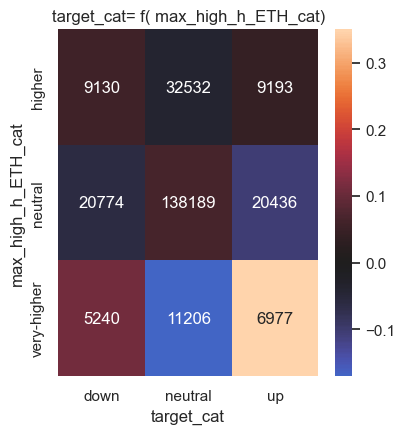

target_cat           down  neutral     up
max_high_h_ETH_cat                       
higher               9130    32532   9193
neutral             20774   138189  20436
very-higher          5240    11206   6977

In [131]:
plot_cont(X="max_high_h_ETH_cat", Y="target_cat", data=df)

In [132]:
df["nupl_ETH"].describe()

count    253677.000000
mean          0.118971
std           0.198094
min          -0.775319
25%           0.039797
50%           0.106898
75%           0.260524
max           0.513805
Name: nupl_ETH, dtype: float64

In [133]:

mquantiles(df["nupl_ETH"], prob=[0.10, 0.90])

array([-0.08284051,  0.36014272])

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_93901/215884474.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x=x, kind="count", palette="ch:.25", data=data,


nupl_ETH_cat
neutral    168456
higher      69777
lower       15444
Name: count, dtype: int64

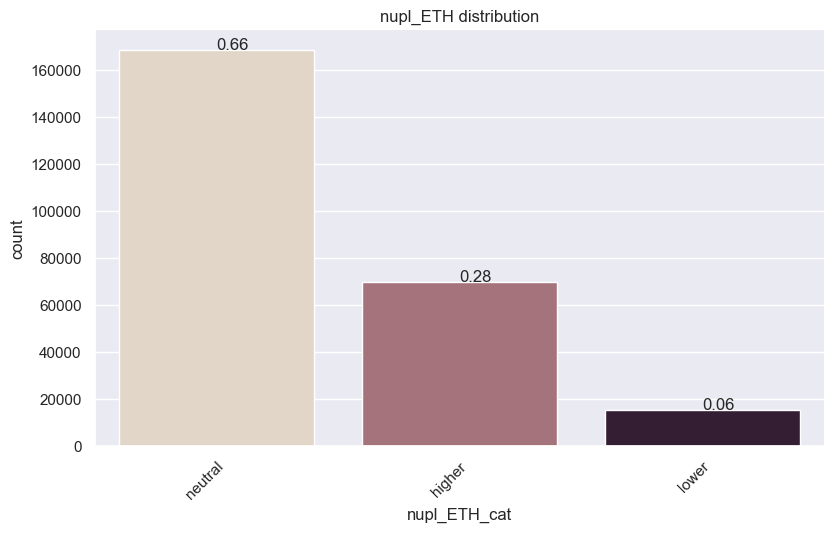

In [134]:

list_level=["lower", "neutral", "higher"]
df["nupl_ETH_cat"] = "neutral"
df.loc[df["nupl_ETH"] >= 0.25, "nupl_ETH_cat"] = "higher"
df.loc[df["nupl_ETH"] <= -0.25, "nupl_ETH_cat"] = "lower"
plot_hist_cat("nupl_ETH_cat", df, "nupl_ETH distribution")

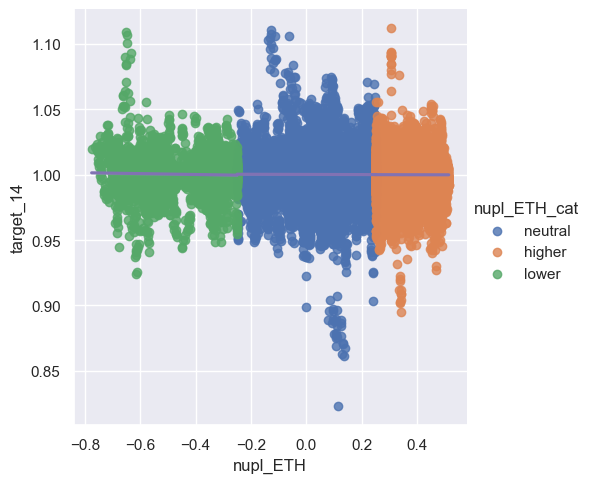

In [135]:
sns.lmplot(x="nupl_ETH", y="target_14", hue="nupl_ETH_cat", data=df,
           line_kws={"color": "C4"})

(0.98, 1.02)

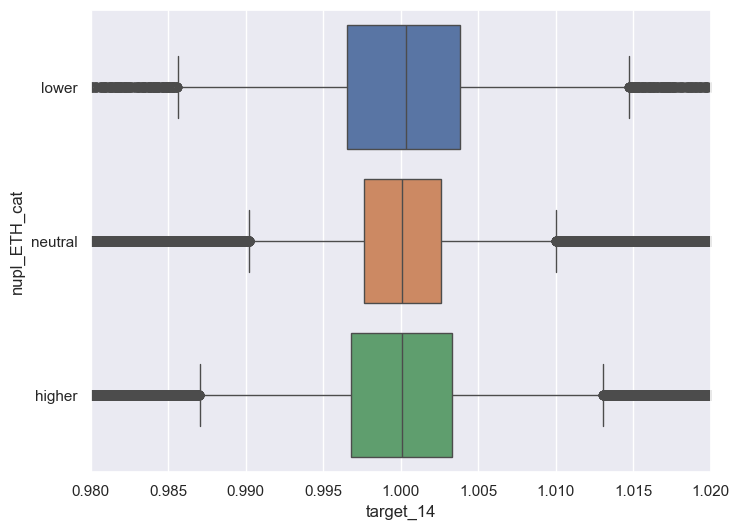

In [136]:
fig = plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x="target_14", y="nupl_ETH_cat", 
    hue="nupl_ETH_cat", dodge=False, 
    order=list_level, hue_order=list_level)
ax = fig.gca()
ax.set_xlim([0.98,1.02])  

expected:  [[  9666.79236982  50041.27405717  10068.93357301]
 [  2139.58670278  11075.81920316   2228.59409406]
 [ 23337.6209274  120809.90673967  24308.47233293]]
target_cat       down   neutral       up     Total
nupl_ETH_cat                                      
higher        11586.0   46564.0  11627.0   69777.0
lower          2817.0    9702.0   2925.0   15444.0
neutral       20741.0  125661.0  22054.0  168456.0
total         35144.0  181927.0  36606.0  253677.0
xi_n =  2159.047419759374
chi2:  2159.047419759374
dof:  4
p:  0.0
We have we have a 0.0000% chance for H0 to be true.
H0 : independance of distributions
H1 : distribution are not independant : we reject H0


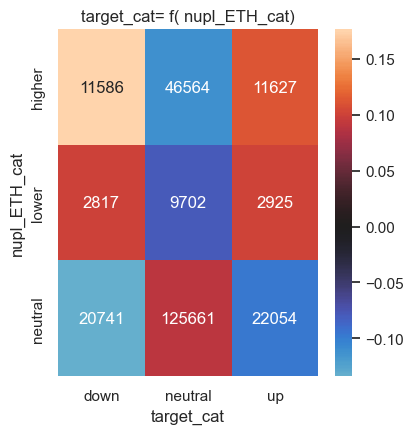

target_cat     down  neutral     up
nupl_ETH_cat                       
higher        11586    46564  11627
lower          2817     9702   2925
neutral       20741   125661  22054

In [137]:
plot_cont(X="nupl_ETH_cat", Y="target_cat", data=df)

In [138]:
chi2 = 2159
indep = 35144.0/253677.0*69777.0
c = 11586
print("chi2: ", chi2)
print("indep: ", indep)
print("c: ", c)
print("chi2 abs part : ", (c-indep)**2/indep)
print("chi2 sign part : ", (c-indep) / np.fabs(c-indep))
print("% of chi2 : ", 100*(c-indep)**2/indep / chi2)


chi2:  2159
indep:  9666.79236982462
c:  11586
chi2 abs part :  381.03207215054994
chi2 sign part :  1.0
% of chi2 :  17.64854433305002


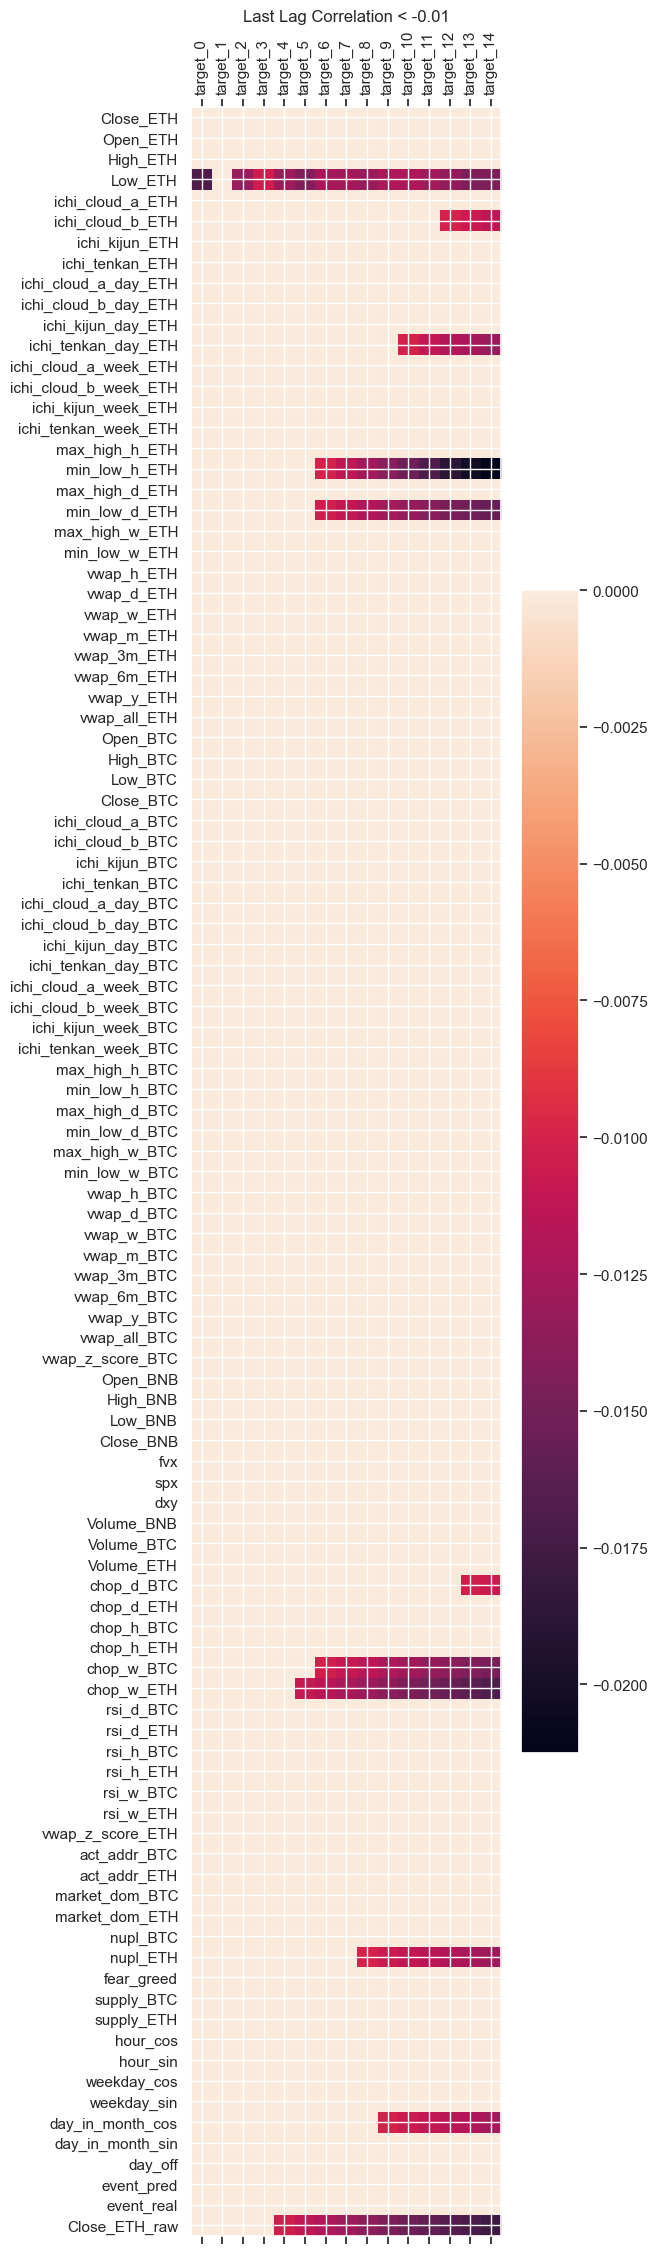

In [139]:
plot_corr(corr_matrix_targets.where(corr_matrix_targets<-0.01, 0), 
          title="Last Lag Correlation < -0.01", 
          size=5)

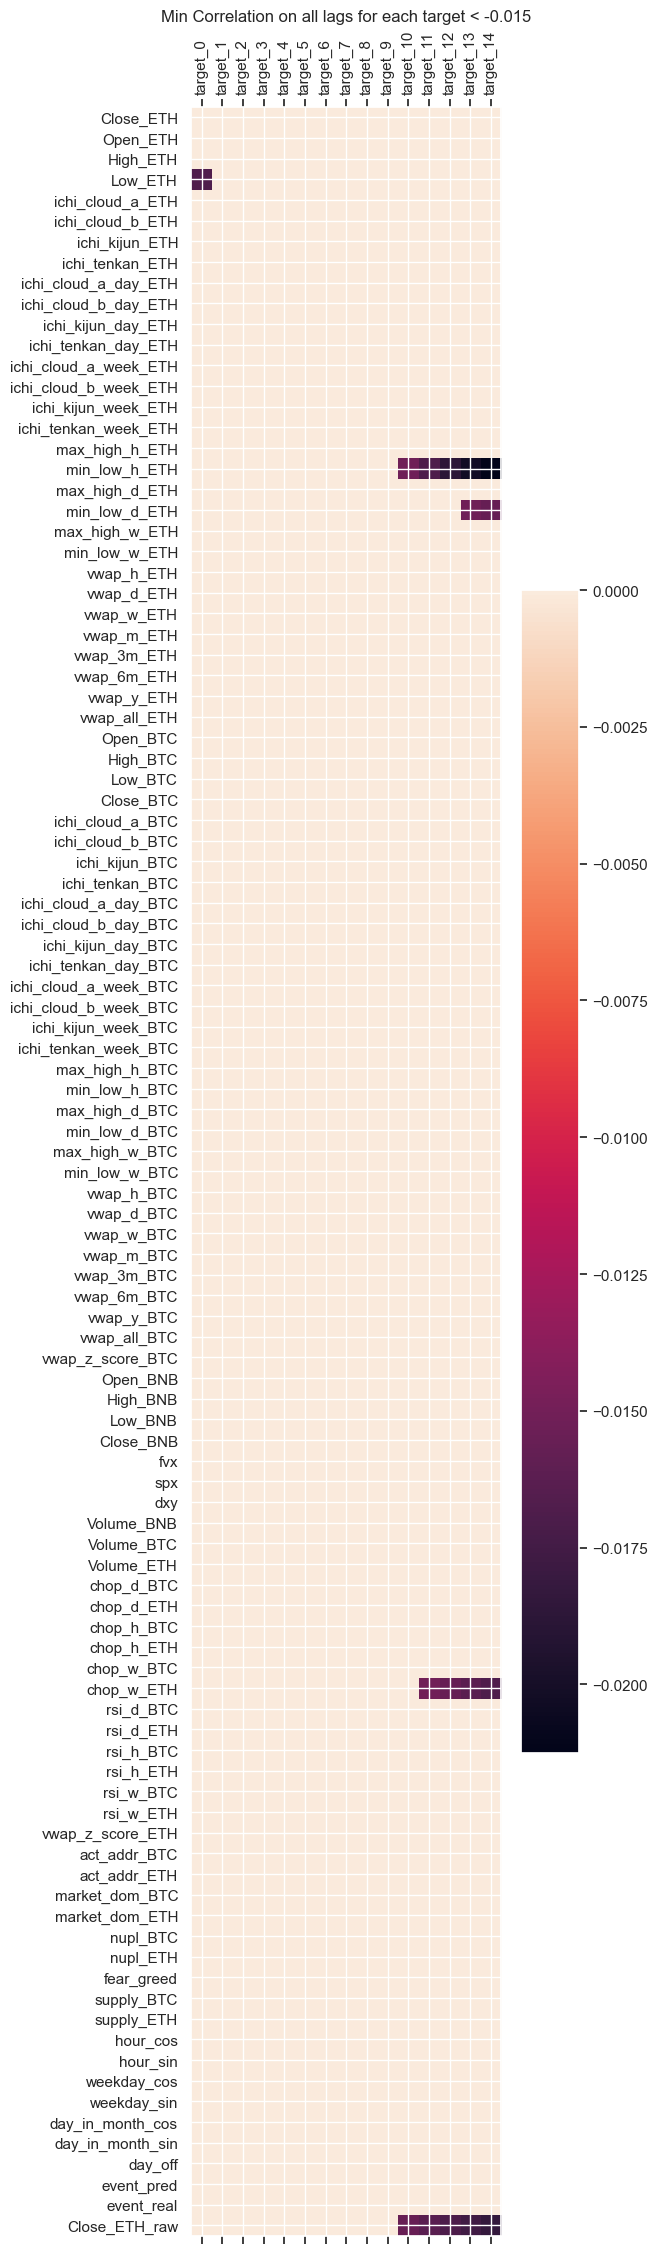

In [140]:
fig = plot_corr(min_corr_matrix_targets.where(min_corr_matrix_targets < -0.015, 0),
                title="Min Correlation on all lags for each target < -0.015",
                size=5)

Text(0, 0.5, 'Min Correlation on all lags for each target < -0.015')

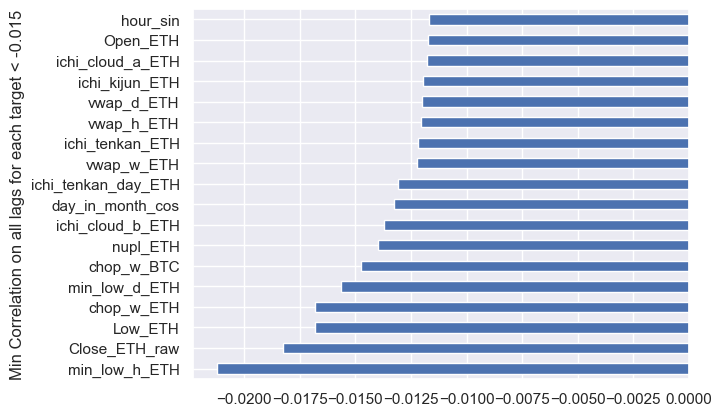

In [141]:
min_min_corr = min_corr_matrix_targets.min(axis=1).sort_values(ascending=True)
min_min_corr[min_min_corr.values<-0.011].plot.barh()
# get current axis
ax = plt.gca()
# set y-axis label
ax.set_ylabel("Min Correlation on all lags for each target < -0.015")

<Axes: >

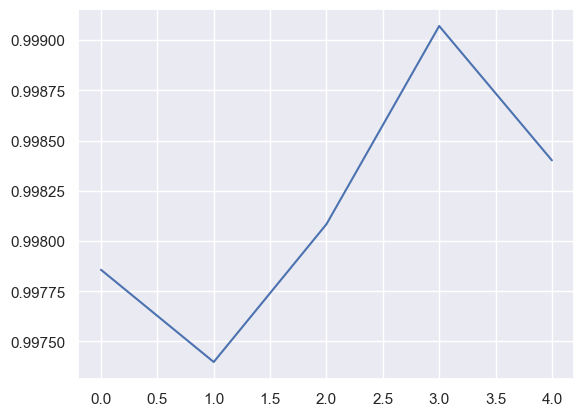

In [142]:
df["min_low_h_ETH"].head().plot()

In [143]:
df["min_low_h_ETH"].describe()

count    253677.000000
mean          0.995225
std           0.005330
min           0.847357
25%           0.993900
50%           0.996677
75%           0.998391
max           1.000000
Name: min_low_h_ETH, dtype: float64

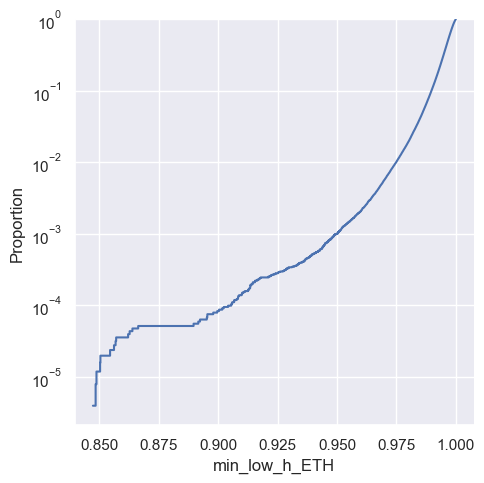

In [144]:
sns.displot(df, x="min_low_h_ETH", kind="ecdf", log_scale=(False, True))

In [145]:
list_level=["very_low", "low", "neutral"]
df["min_low_h_ETH_cat"] = "low"
df.loc[df["min_low_h_ETH"] < 0.995, "min_low_h_ETH_cat"] = "very_low"
df.loc[df["min_low_h_ETH"] > 0.998, "min_low_h_ETH_cat"] = "neutral"
df["min_low_h_ETH_cat"].value_counts()

min_low_h_ETH_cat
low         91014
very_low    83184
neutral     79479
Name: count, dtype: int64

Text(0.5, 1.0, 'Lower Low per hour impact : ETH price = f(min_low_h_ETH_cat)')

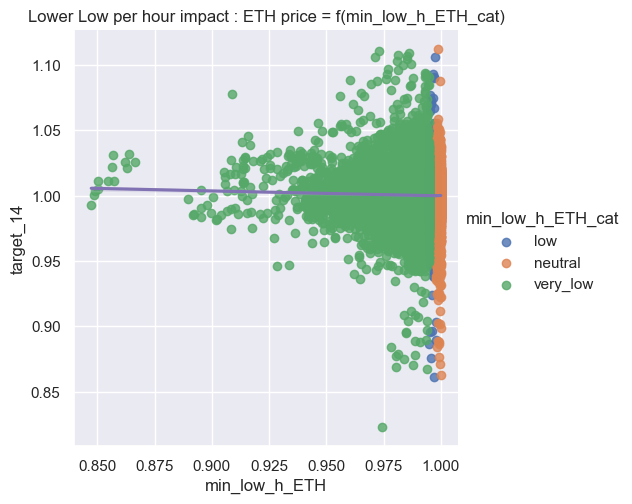

In [146]:
sns.lmplot(x="min_low_h_ETH", y="target_14", hue="min_low_h_ETH_cat", data=df,
           line_kws={"color": "C4"})
plt.title("Lower Low per hour impact : ETH price = f(min_low_h_ETH_cat)")

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_93901/215884474.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x=x, kind="count", palette="ch:.25", data=data,


min_low_h_ETH_cat
low         91014
very_low    83184
neutral     79479
Name: count, dtype: int64

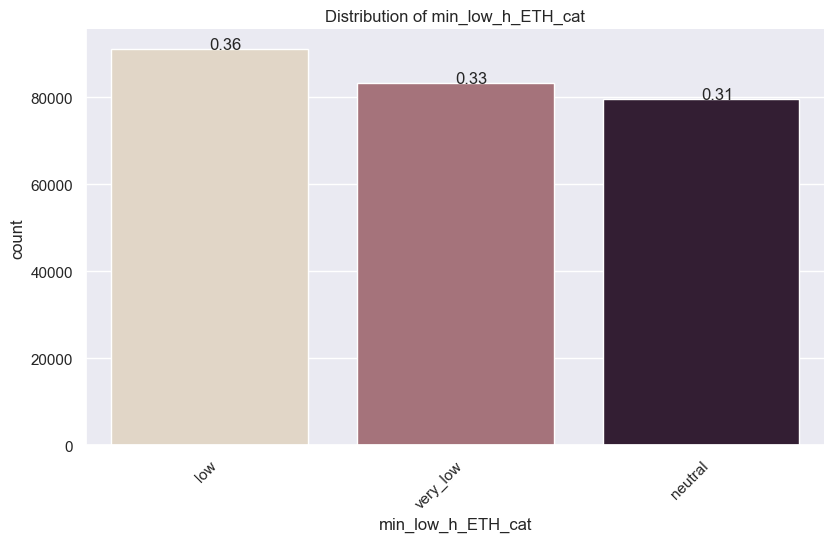

In [147]:

plot_hist_cat(x="min_low_h_ETH_cat", data=df, title="Distribution of min_low_h_ETH_cat")

expected:  [[12608.93189371 65271.60120153 13133.46690476]
 [11010.89170875 56999.16047967 11468.94781159]
 [11524.17639754 59656.23831881 12003.58528365]]
target_cat            down   neutral       up     Total
min_low_h_ETH_cat                                      
low                11509.0   67574.0  11931.0   91014.0
neutral             7582.0   63940.0   7957.0   79479.0
very_low           16053.0   50413.0  16718.0   83184.0
total              35144.0  181927.0  36606.0  253677.0
xi_n =  8339.15806994498
chi2:  8339.15806994498
dof:  4
p:  0.0
We have we have a 0.0000% chance for H0 to be true.
H0 : independance of distributions
H1 : distribution are not independant : we reject H0


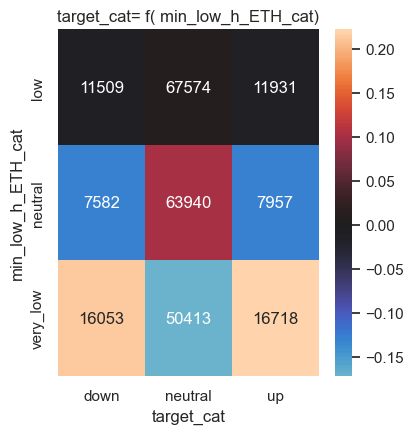

target_cat          down  neutral     up
min_low_h_ETH_cat                       
low                11509    67574  11931
neutral             7582    63940   7957
very_low           16053    50413  16718

In [148]:
plot_cont(X="min_low_h_ETH_cat", Y="target_cat", data=df)

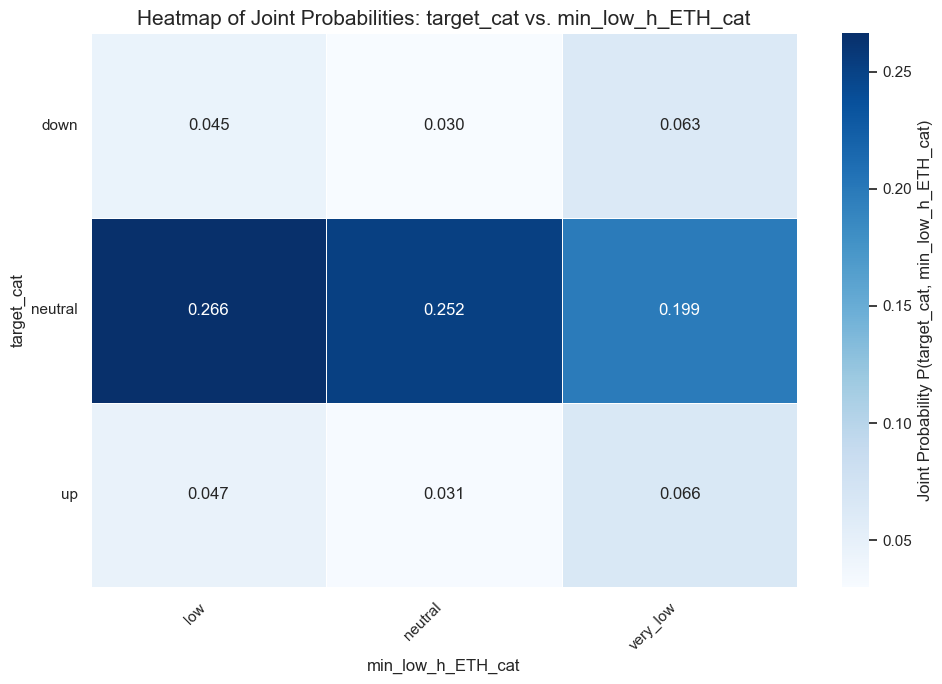

Joint Probability Table:
min_low_h_ETH_cat       low   neutral  very_low
target_cat                                     
down               0.045369  0.029888  0.063281
neutral            0.266378  0.252053  0.198729
up                 0.047032  0.031367  0.065903


In [149]:
probability_table = pd.crosstab(df['target_cat'], df['min_low_h_ETH_cat'], normalize=True)
# 2. Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(
    probability_table,
    annot=True,        # Show the probability values on the heatmap cells
    fmt=".3f",         # Format annotations to 3 decimal places
    cmap="Blues",      # Colormap (e.g., "Blues", "YlGnBu", "viridis")
    linewidths=.5,     # Add lines between cells for better separation
    cbar_kws={'label': 'Joint Probability P(target_cat, min_low_h_ETH_cat)'} # Label for the color bar
)

plt.title('Heatmap of Joint Probabilities: target_cat vs. min_low_h_ETH_cat', fontsize=15)
plt.ylabel('target_cat', fontsize=12)
plt.xlabel('min_low_h_ETH_cat', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability if long
plt.yticks(rotation=0)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

# Display the probability table (optional)
print("Joint Probability Table:")
print(probability_table)

In [150]:
probability_table.sum().sum()

np.float64(1.0)

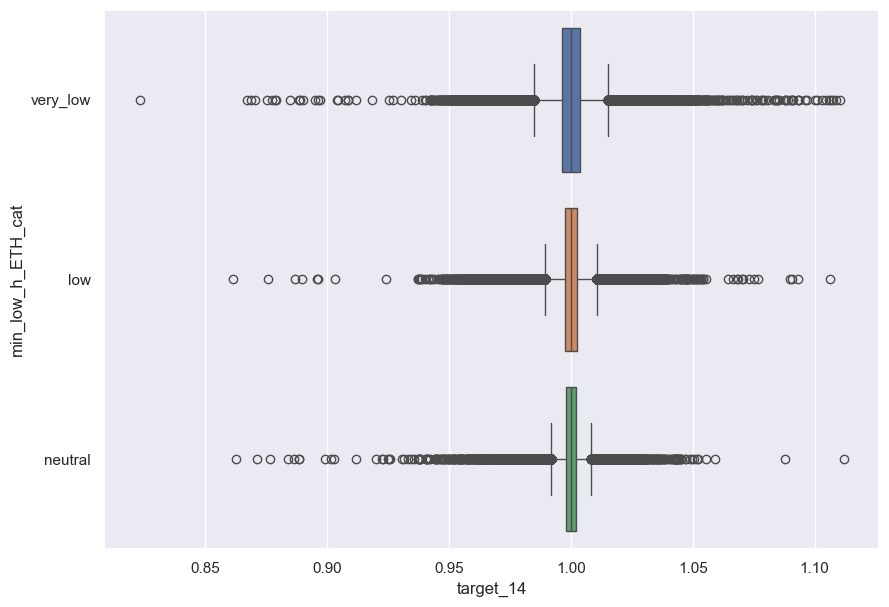

In [151]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="min_low_h_ETH_cat", 
    hue="min_low_h_ETH_cat", dodge=False, 
    order=list_level, hue_order=list_level)
ax = fig.gca()
#ax.set_xlim([0.98,1.02])

In [152]:
df["target_14"].describe()

count    253677.000000
mean          1.000070
std           0.007196
min           0.823072
25%           0.997361
50%           1.000089
75%           1.002851
max           1.112129
Name: target_14, dtype: float64

In [153]:
df["target_1"].describe()

count    253677.000000
mean          1.000009
std           0.002652
min           0.907143
25%           0.998967
50%           1.000013
75%           1.001066
max           1.081058
Name: target_1, dtype: float64

<Axes: xlabel='target_14'>

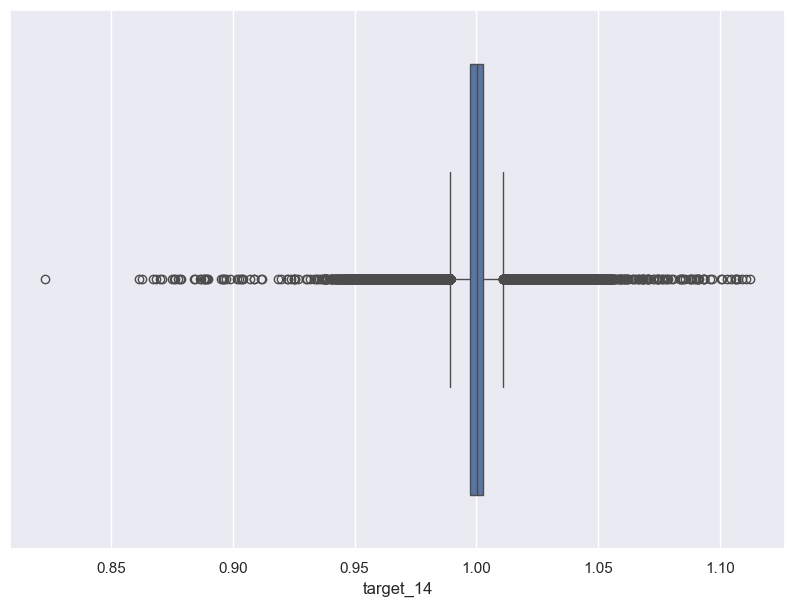

In [154]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(x=df["target_14"]) 

(0.98, 1.02)

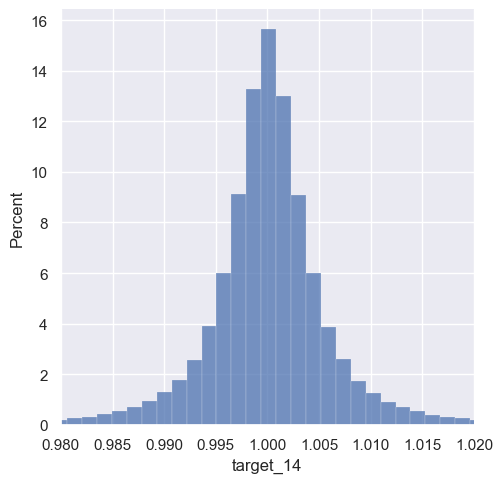

In [155]:
sns.displot(df, x="target_14", kind="hist", stat="percent", bins=200)
ax = plt.gca()
ax.set_xlim([0.98,1.02])

### Chi-2
Distrib are independent between inputs and target (target_14) ?  
Chi-2 must be low  
if not then we can use them as features  
To classify Targets we can say that : if we have : 
- a capital 10000$  
- leverage x10 maxi
- and we want to have 100$ of profit per days
- so:  0.1% up or down can be enough for target

Or find a threshold that can occurs on FUTURE_TARGET points  at a minimum prob to have > 80% chance to touch min or max target  
For example : 
- 40% touch max Target
- 40% touch min Target
- 20% neutral
- Total : 80%


In [156]:
df = pd.DataFrame(np.hstack((X_train_dat[:, -1, :nb_plot], y_train)), 
        columns=list_col_corr)

In [157]:
last_target = list_col_targets[-1]

In [158]:
df.filter(list_col_select)

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0             1.0  0.999782  1.000109  0.999774          0.999171   
1             1.0  0.999548  1.000008  0.999540          0.998785   
2             1.0  1.000084  1.000193  0.999841          0.998860   
3             1.0  1.000770  1.000770  0.999900          0.999669   
4             1.0  0.999330  1.000025  0.999330          0.999178   
...           ...       ...       ...       ...               ...   
253672        1.0  0.998258  1.001698  0.997009          1.009059   
253673        1.0  0.998554  1.001387  0.998451          1.006895   
253674        1.0  1.004900  1.005056  0.999299          1.011829   
253675        1.0  1.001168  1.001491  0.997621          1.011492   
253676        1.0  1.012121  1.014171  0.998487          1.023400   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
0               0.999736        0.998393         0.999464   
1               0.999276        0.998113         0.999184   
2               0.999351        0.998243         0.999477   
3               1.000113        0.999003         1.000239   
4               0.999443        0.998335         0.999569   
...                  ...             ...              ...   
253672          1.012239        1.000323         1.000559   
253673          1.010775        0.998877         0.999113   
253674          1.015728        1.003772         1.004009   
253675          1.015731        1.004944         1.003987   
253676          1.028043        1.011526         1.009147   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...      hour_cos  \
0                   2.024261              2.017807  ...  2.588190e-01   
1                   2.023329              2.016878  ...  6.123234e-17   
2                   2.023482              2.017030  ...  6.123234e-17   
3                   2.025023              2.018567  ...  6.123234e-17   
4                   2.023668              2.017215  ...  6.123234e-17   
...                      ...                   ...  ...           ...   
253672              1.043299              1.026564  ...  9.659258e-01   
253673              1.041791              1.025079  ...  9.659258e-01   
253674              1.046896              1.030103  ...  9.659258e-01   
253675              1.048118              1.031306  ...  9.659258e-01   
253676              1.060823              1.043807  ...  9.659258e-01   

        hour_sin  weekday_cos  weekday_sin  day_in_month_cos  \
0       0.965926     0.623490    -0.781832           0.97953   
1       1.000000     0.623490    -0.781832           0.97953   
2       1.000000     0.623490    -0.781832           0.97953   
3       1.000000     0.623490    -0.781832           0.97953   
4       1.000000     0.623490    -0.781832           0.97953   
...          ...          ...          ...               ...   
253672  0.258819    -0.222521    -0.974928           1.00000   
253673  0.258819    -0.222521    -0.974928           1.00000   
253674  0.258819    -0.222521    -0.974928           1.00000   
253675  0.258819    -0.222521    -0.974928           1.00000   
253676  0.258819    -0.222521    -0.974928           1.00000   

        day_in_month_sin  day_off  event_pred  event_real  Close_ETH_raw  
0           2.012985e-01      0.0         0.0         0.0    1194.540039  
1           2.012985e-01      0.0         0.0         0.0    1195.089966  
2           2.012985e-01      0.0         0.0         0.0    1195.000000  
3           2.012985e-01      0.0         0.0         0.0    1194.089966  
4           2.012985e-01      0.0         0.0         0.0    1194.890015  
...                  ...      ...         ...         ...            ...  
253672     -2.449294e-16      0.0         0.0         0.0    2520.719971  
253673     -2.449294e-16      0.0         0.0         0.0    2524.370117  
253674     -2.449294e-16      0.0         0.0         0.0    2512.060059  
253675     -2.449294e-16      0.0         0.0     

In [159]:
# find for all features the quantiles 0.10 and 0.90
# transpose the dataframe to have the features as columns
df_cont = df.filter(list_col_select + [last_target]).quantile([0.10, 0.90], axis=0)
df_cont = df_cont.T
# rename the columns
df_cont.columns = ["q10", "q90"]
# store nunique() in a new column
df_cont["nunique"] = df.filter(list_col_select + [last_target]).nunique()

df_cont

q10          q90  nunique
Close_ETH            1.000000     1.000000        1
Open_ETH             0.998280     1.001714    76413
High_ETH             1.000016     1.002502    37382
Low_ETH              0.997419     0.999966    60295
ichi_cloud_a_ETH     0.990221     1.009114   171844
...                       ...          ...      ...
day_off              0.000000     0.000000        2
event_pred           0.000000     0.000000        3
event_real           0.000000     0.000000        3
Close_ETH_raw     1625.745996  3489.247998   135314
target_14            0.993554     1.006591   253286

[104 rows x 3 columns]

#### Target levels
Here we can see the 10% lowest is under -0.64%, the 10% highest are over 0.65% : 

In [160]:
print(f"target level min : {100*(df_cont.at["target_14","q10"]-1)} %")

target level min : -0.6445897063064643 %


In [161]:
print(f"target level max : {100*(df_cont.at["target_14","q90"]-1)} %")

target level max : 0.6591337726385094 %


In [162]:
(1.006591 -1)/1 *100

0.6591000000000014

In [163]:
(0.993554 - 1) / 1 * 100

-0.6445999999999952

We can use a level of >= 0.1% => "high" , <=-0.1% "low", otherwise "neutral"  

- BE CAREFUL : Hyperliquid for example can take 25% of trade if 0.1% is a trigger : 
  - maker fee : 0.015%
  - funding 24h = 0.03*3 = 0.01%  
  - TOTAL :  0.025% => 25% of 0.1%

In [164]:
target_level = 0.1/100

In [165]:
y_train.shape

(253677, 15)

In [166]:
y_train.max(axis=1) >= 1+target_level

array([False, False, False, ...,  True,  True,  True], shape=(253677,))

In [167]:
y_train.min(axis=1) <= 1-target_level

array([False,  True,  True, ...,  True,  True, False], shape=(253677,))

Not used anymore :  the last target value : 

In [168]:
Y = "target_last_cat"
df_targets = pd.DataFrame(y_train, columns=list_col_targets)
df_targets[Y] = "neutral"
df_targets.loc[y_train[:,-1] >= 1+target_level, Y] = "high"
df_targets.loc[y_train[:,-1] <= 1-target_level, Y] = "low"
df_targets[Y].value_counts()

target_last_cat
high       102187
low         97441
neutral     54049
Name: count, dtype: int64

In [169]:
df_targets["target_last_cat"].value_counts()/df_targets.shape[0]

target_last_cat
high       0.402823
low        0.384114
neutral    0.213062
Name: count, dtype: float64

In [170]:
df_targets["target_14"].describe()

count    253677.000000
mean          1.000070
std           0.007196
min           0.823072
25%           0.997361
50%           1.000089
75%           1.002851
max           1.112129
Name: target_14, dtype: float64

In [171]:
df_targets["max_target"] = y_train.max(axis=1)
df_targets["min_target"] = y_train.min(axis=1)
df_targets

target_0  target_1  target_2  target_3  target_4  target_5  target_6  \
0       1.000460  1.000385  0.999623  1.000293  0.999816  1.000050  0.999498   
1       0.999925  0.999163  0.999833  0.999356  0.999590  0.999038  0.999046   
2       0.999238  0.999908  0.999431  0.999665  0.999113  0.999121  0.999473   
3       1.000670  1.000193  1.000427  0.999874  0.999883  1.000234  1.000301   
4       0.999523  0.999757  0.999205  0.999213  0.999565  0.999632  0.999565   
...          ...       ...       ...       ...       ...       ...       ...   
253672  1.001448  0.996564  0.995402  0.983481  0.990876  0.990951  0.988297   
253673  0.995124  0.993963  0.982059  0.989443  0.989518  0.986868  0.986836   
253674  0.998834  0.986871  0.994292  0.994367  0.991704  0.991672  0.992440   
253675  0.988024  0.995453  0.995528  0.992862  0.992830  0.993599  0.991049   
253676  1.007519  1.007596  1.004897  1.004865  1.005643  1.003062  1.010629   

        target_7  target_8  target_9  target_10  target_11  target_12  \
0       0.999506  0.999858  0.999925   0.999858   1.000226   0.999891   
1       0.999398  0.999464  0.999398   0.999766   0.999431   0.999690   
2       0.999540  0.999473  0.999841   0.999506   0.999766   0.999473   
3       1.000234  1.000603  1.000268   1.000528   1.000234   0.999640   
4       0.999933  0.999598  0.999858   0.999565   0.998971   0.998686   
...          ...       ...       ...        ...        ...        ...   
253672  0.988265  0.989031  0.986492   0.993934   0.995977   0.997667   
253673  0.987601  0.985066  0.992497   0.994537   0.996225   0.993384   
253674  0.989893  0.997361  0.999411   1.001107   0.998252   0.997170   
253675  0.998525  1.000578  1.002276   0.999418   0.998334   0.994448   
253676  1.012706  1.014425  1.011533   1.010435   1.006502   1.009294   

        target_13  target_14 target_last_cat  max_target  min_target  
0        1.000151   0.999858         neutral    1.000460    0.999498  
1        0.999398   0.998803             low    0.999925    0.998803  
2        0.998879   0.998594             low    0.999908    0.998594  
3        0.999355   1.000427         neutral    1.000670    0.999355  
4        0.999757   0.999732         neutral    0.999933    0.998686  
...           ...        ...             ...         ...         ...  
253672   0.994823   0.993744             low    1.001448    0.983481  
253673   0.992307   0.988445             low    0.996225    0.982059  
253674   0.993288   0.996043             low    1.001107    0.986871  
253675   0.997206   0.995803             low    1.002276    0.988024  
253676   1.007874   1.007934            high    1.014425    1.003062  

[253677 rows x 18 columns]

Very important : we can see that the last target is not the best to use as a target,   
because it is not well distributed,   
so we will use the max and min, of all the targets, to create a new target   
But we take the first to appear above min/max threshold : +/-0.1%  
Example : 
- if the max is above 1.001 before min is below 0.999, then we will use the max as the target
- if the min is below 0.999 before max is above 1.001, then we will use the min as the target
- if none of them are above/below 1.001/0.999, then we will use the neutral target
  
##### First Strategy :  TP = SL

In [172]:
Y = "target_cat"
#df_targets = pd.DataFrame(y_train, columns=list_col_targets)
df_targets[Y] = "neutral"
# low cat : 
b_low = ((y_train.min(axis=1) <= 1-target_level) & (
    (y_train.argmin(axis=1) < y_train.argmax(axis=1)) |
    ((y_train.argmin(axis=1) > y_train.argmax(axis=1)) & (y_train.max(axis=1) < 1+target_level))
    )
)
df_targets.loc[b_low, Y] = "low"
# high cat
b_high = ((y_train.max(axis=1) >= 1+target_level)& (
    (y_train.argmax(axis=1) < y_train.argmin(axis=1)) |
    ((y_train.argmax(axis=1) > y_train.argmin(axis=1)) & (y_train.min(axis=1) > 1-target_level))
    )
)
df_targets.loc[b_high, Y] = "high"

df_targets[Y].value_counts()

target_cat
high       125295
low        123574
neutral      4808
Name: count, dtype: int64

In [173]:
df_targets[Y].value_counts()/df_targets.shape[0]

target_cat
high       0.493915
low        0.487131
neutral    0.018953
Name: count, dtype: float64

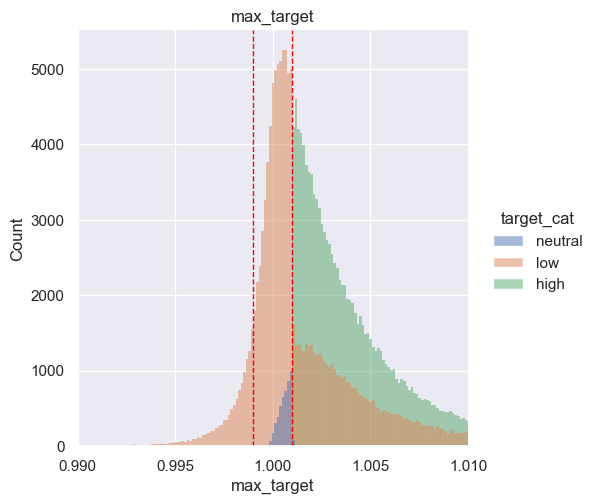

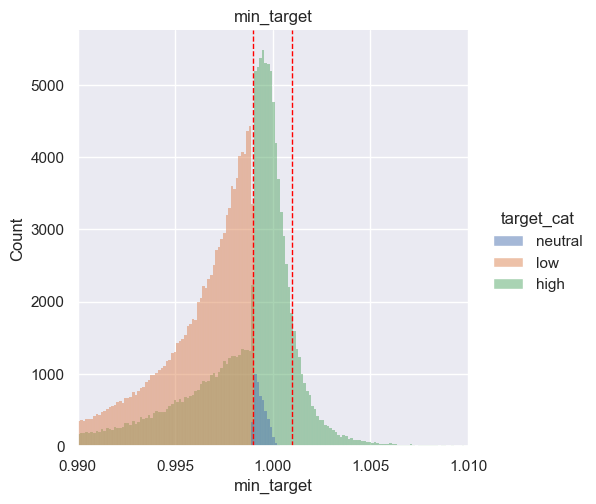

In [174]:
sns.displot(df_targets, x="max_target", hue="target_cat", kind="hist")
ax = plt.gca()
ax.set_xlim([0.99,1.01])
ax.set_title("max_target")
# add vertical lines at 1+target_level and 1-target_level
ax.axvline(1+target_level, color='red', linestyle='dashed', linewidth=1)
ax.axvline(1-target_level, color='red', linestyle='dashed', linewidth=1)

sns.displot(df_targets, x="min_target", hue="target_cat", kind="hist")
ax = plt.gca()
ax.set_xlim([0.99,1.01])
ax.set_title("min_target")
# add vertical lines at 1+target_level and 1-target_level
ax.axvline(1+target_level, color='red', linestyle='dashed', linewidth=1)
ax.axvline(1-target_level, color='red', linestyle='dashed', linewidth=1)

Here : complex graph : 
- If Neutral cat., min or max stay into thresholds.  
- if High cat., min value is around 1
- If Low cat., max value is 1.0005 (1-0.05%) (half the threshold 0.1%)


##### 2eme Strat : TP/SL = 2


In [175]:
1-target_level

0.999

In [176]:
1-target_level/2

0.9995

In [177]:
1+target_level

1.001

In [178]:
1+target_level/2

1.0005

In [179]:
# nb low SHORT TP and high SHORT SL is never reached during timerange
np.sum((y_train.min(axis=1) <= 1-target_level) & (y_train.max(axis=1) < 1+target_level/2))

np.int64(54336)

In [180]:
# nb low SHORT TP and high SHORT SL is reached during timerange but after TP is reached
np.sum(
    (y_train.min(axis=1) <= 1-target_level) & (y_train.max(axis=1) >= 1+target_level/2)
    & (np.argmax((y_train <= 1-target_level), axis=1) <= np.argmax(y_train >= 1+target_level/2, axis=1))
)

np.int64(51137)

In [181]:
54336 + 51137

105473

In [182]:
# nb high LONG TP and low LONG SL is never reached during timerange
np.sum((y_train.max(axis=1) >= 1+target_level) & (y_train.min(axis=1) > 1-target_level/2))

np.int64(56897)

In [183]:
# nb high LONG TP and low LONG SL is reached during timerange but after TP is reached 
np.sum(
    (y_train.max(axis=1) >= 1+target_level) & (y_train.min(axis=1) <= 1-target_level/2) &
    (np.argmax((y_train >= 1+target_level), axis=1) <= np.argmax(y_train <= 1-target_level/2, axis=1))
)

np.int64(50774)

In [184]:
56897 + 50774

107671

In [185]:
Y = "target_cat"
#df_targets = pd.DataFrame(y_train, columns=list_col_targets)
df_targets[Y] = "neutral"
# low cat : if :
#   - low SHORT TP touched AND high SHORT SL IS NOT  reached during timerange
#   - OR low SHORT TP touched AND high SHORT SL IS reached during timerange but AFTER TP
b_low =(
    ((y_train.min(axis=1) <= 1-target_level) & (y_train.max(axis=1) < 1+target_level/2)) |
    (
        (y_train.min(axis=1) <= 1-target_level) & (y_train.max(axis=1) >= 1+target_level/2) &
        (np.argmax((y_train <= 1-target_level), axis=1) <= np.argmax(y_train >= 1+target_level/2, axis=1))
    ) 
)
df_targets.loc[b_low, Y] = "low"
# high cat : if 
#   - high LONG TP touched AND low LONG SL IS NOT reached during timerange
#   - OR high LONG TP touched AND low LONG SL IS reached during timerange but AFTER TP
b_high = (
    ((y_train.max(axis=1) >= 1+target_level) & (y_train.min(axis=1) > 1-target_level/2)) |
    (
        (y_train.max(axis=1) >= 1+target_level) & (y_train.min(axis=1) <= 1-target_level/2) &
        (np.argmax((y_train >= 1+target_level), axis=1) <= np.argmax(y_train <= 1-target_level/2, axis=1))
    )
)

df_targets.loc[b_high, Y] = "high"

df_targets[Y].value_counts()

target_cat
high       107671
low        105473
neutral     40533
Name: count, dtype: int64

Max trade per day

In [186]:
24*60/5

288.0

In [187]:
Y

'target_cat'

In [188]:
PAST_HISTORY

72

In [189]:
(2**6)*5/60

5.333333333333333

Caclulate for lags expontionnaly distributed  : e.g. : 
- 1st lag = 5min
- 2nd lag = 10min
- 3rd lag = 20min
- 4th lag = 40min
- 5th lag = 80min
- 6th lag = 160min

In [190]:

# find a maximum range as long as sum on i (from 1 to n) of DT_PAST*2**(i-1) is inferior to PAST_HISTORY 
k=0
list_past = []
for i in range(0, PAST_HISTORY):
    if 2**(i) - 1 > PAST_HISTORY:
        break
    else:
        k = PAST_HISTORY - 2**(i) 
        list_past.append(k)

print(list_past)

[71, 70, 68, 64, 56, 40, 8]


In [191]:
def calc_prob(val):
    # calculate proba for classes of a value counts as input : val
    # calculate also the delta "power" proba between high and low : (nb_H - nb_L)^2 / mean(nb_h,nb_L)
    # to indicate important feature
    prob_high = val["high"] / (val.sum())
    prob_low = val["low"] / (val.sum())
    prob_delta = np.sign(prob_high - prob_low) * (val["high"] - val["low"] )**2 / ((val["high"] + val["low"]) / 2)
    return val["high"], val["low"], prob_high, prob_low, prob_delta


In [192]:
# df_prob = pd.DataFrame()

# for cat_feature in ["high", "low"]:
#     ser_prob_curr = pd.Series()
#     val = df_.loc[df_[X] == cat_feature, "target_cat"].value_counts()
#     if len(val) > 0 :
#         prob_high, prob_low, delta_prob = calc_prob(val)
#     else:
#         prob_high = np.nan
#         prob_low = np.nan
#         delta_prob = np.nan
#     ser_prob_curr["feature"] = X
#     ser_prob_curr["feature_cat"] = cat_feature
#     ser_prob_curr["lag"] = I_past
#     ser_prob_curr["prob_high"] = prob_high
#     ser_prob_curr["prob_low"] = prob_low
#     ser_prob_curr["delta_prob"] = delta_prob
#     #df_prob = pd.concat([df_prob, df_prob_curr], axis=0)
#     if df_prob.shape[0] == 0:
#         df_prob = ser_prob_curr.to_frame().T
#     else:
#         df_prob = pd.concat([df_prob, ser_prob_curr.to_frame().T], ignore_index=True)
# df_prob

In [193]:
# Calculate classes, contigency chi2 and p value : for each feature and each past value
# - for all lags of target,  we have one categorical variable :
# - high mean we have touch high target level, 
# - low mean we have touch low target level,
# - neutral mean we have not touch target level
list_df = []
df_prob = pd.DataFrame()
for I_past in list_past: #range(PAST_HISTORY):
    # Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
    df_ = pd.DataFrame(X_train_dat[:, I_past, :nb_plot], columns=list_col_select[:nb_plot])
    df_ = pd.concat([df_, df_targets], axis=1)
    for col_name in list_col_select:
        X = col_name + "_cat"
        df_[X] = "neutral"
        if df_cont.at[col_name, "nunique"] > 3:
            df_.loc[df_[col_name] >= df_cont.at[col_name, "q90"], X] = "high"
            df_.loc[df_[col_name] <= df_cont.at[col_name, "q10"], X] = "low"
        elif df_cont.at[col_name, "nunique"] == 3:
            unique_values = df_[col_name].unique()
            # sort the unique values
            unique_values.sort()
            # assign the categories
            df_.loc[df_[col_name] == unique_values[2], X] = "high"
            df_.loc[df_[col_name] == unique_values[1], X] = "neutral"
            df_.loc[df_[col_name] == unique_values[0], X] = "low"
        elif df_cont.at[col_name, "nunique"] == 2:
            unique_values = df_[col_name].unique()
            # sort the unique values
            unique_values.sort()
            # assign the categories
            df_.loc[df_[col_name] == unique_values[1], X] = "high"
            df_.loc[df_[col_name] == unique_values[0], X] = "low"
        

        # create prob df : 
        for cat_feature in ["high", "low"]:
            ser_prob_curr = pd.Series()
            val = df_.loc[df_[X] == cat_feature, "target_cat"].value_counts()
            if len(val) > 0 :
                val_high, val_low, prob_high, prob_low, delta_prob = calc_prob(val)
            else:
                val_high = np.nan
                val_low = np.nan
                prob_high = np.nan
                prob_low = np.nan
                delta_prob = np.nan
            ser_prob_curr["feature"] = X
            ser_prob_curr["feature_cat"] = cat_feature
            ser_prob_curr["lag"] = I_past
            ser_prob_curr["nb_high"] = val_high
            ser_prob_curr["nb_low"] = val_low
            ser_prob_curr["prob_high"] = prob_high
            ser_prob_curr["prob_low"] = prob_low
            ser_prob_curr["delta_prob"] = delta_prob
            #df_prob = pd.concat([df_prob, df_prob_curr], axis=0)
            if df_prob.shape[0] == 0:
                df_prob = ser_prob_curr.to_frame().T
            else:
                df_prob = pd.concat([df_prob, ser_prob_curr.to_frame().T], ignore_index=True)
    list_df.append(df_)

    df_cont[f"chi2_{I_past}"] = np.nan
    df_cont[f"p-value_{I_past}"] = np.nan
    # calculate contingency table for each feature
    arr_chi2 = np.full(len(list_col_select), np.nan)
    arr_p = np.full(len(list_col_select), np.nan)
    arr_prob_high_high = np.full(len(list_col_select), np.nan)
    arr_prob_high_low = np.full(len(list_col_select), np.nan)
    arr_delta_prob_high = np.full(len(list_col_select), np.nan)
    arr_prob_low_high = np.full(len(list_col_select), np.nan)
    arr_prob_low_low = np.full(len(list_col_select), np.nan)
    arr_delta_prob_low = np.full(len(list_col_select), np.nan)
    for I, col_name in enumerate(list_col_select):
        X = col_name + "_cat"
        # calculate contingency table : find link between feature cat and target cat
        c, chi2, p, dof, expected = contingency_table(X, "target_cat", df_)
        arr_chi2[I] = chi2
        arr_p[I] = p
        # calculate delta prob of high target and low target for each feature cat
        # when feat is high : 
        val = df_.loc[df_[X] == "high", "target_cat"].value_counts()
        if len(val) > 0 :
            _, _, prob_high_high, prob_high_low, delta_prob_high = calc_prob(val)
        else:
            prob_high_high = np.nan
            prob_high_low = np.nan
            delta_prob_high = np.nan
        arr_prob_high_high[I] = prob_high_high
        arr_prob_high_low[I] = prob_high_low
        arr_delta_prob_high[I] = delta_prob_high
        # and when feat is low :
        val = df_.loc[df_[X] == "low", "target_cat"].value_counts()
        if len(val) > 0 :
            _, _, prob_low_high, prob_low_low, delta_prob_low = calc_prob(val)
        else:
            prob_low_high = np.nan
            prob_low_low = np.nan
            delta_prob_low = np.nan
        arr_prob_low_high[I] = prob_low_high
        arr_prob_low_low[I] = prob_low_low
        arr_delta_prob_low[I] = delta_prob_low

        
    df_cont.loc[list_col_select, f"prob_high_high_{I_past}"] = arr_prob_high_high
    df_cont.loc[list_col_select, f"prob_high_low_{I_past}"] = arr_prob_high_low
    df_cont.loc[list_col_select, f"delta_prob_high_{I_past}"] = arr_delta_prob_high
    df_cont.loc[list_col_select, f"prob_low_high_{I_past}"] = arr_prob_low_high
    df_cont.loc[list_col_select, f"prob_low_low_{I_past}"] = arr_prob_low_low
    df_cont.loc[list_col_select, f"delta_prob_low_{I_past}"] = arr_delta_prob_low  


    df_cont.loc[list_col_select, f"chi2_{I_past}"] = arr_chi2
    df_cont.loc[list_col_select, f"p-value_{I_past}"] = arr_p


df_cont

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_93901/3298450444.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_[X] = "neutral"
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_93901/3298450444.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_[X] = "neutral"
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_93901/3298450444.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider

q10          q90  nunique      chi2_71  \
Close_ETH            1.000000     1.000000        1     0.000000   
Open_ETH             0.998280     1.001714    76413  1648.044162   
High_ETH             1.000016     1.002502    37382  1634.686196   
Low_ETH              0.997419     0.999966    60295  1513.238540   
ichi_cloud_a_ETH     0.990221     1.009114   171844  2147.217804   
...                       ...          ...      ...          ...   
day_off              0.000000     0.000000        2    14.815164   
event_pred           0.000000     0.000000        3     5.741965   
event_real           0.000000     0.000000        3     1.107176   
Close_ETH_raw     1625.745996  3489.247998   135314   209.290972   
target_14            0.993554     1.006591   253286          NaN   

                    p-value_71  prob_high_high_71  prob_high_low_71  \
Close_ETH         1.000000e+00                NaN               NaN   
Open_ETH          0.000000e+00           0.480389          0.419607   
High_ETH          0.000000e+00           0.480568          0.432716   
Low_ETH           0.000000e+00           0.401041          0.383775   
ichi_cloud_a_ETH  0.000000e+00           0.490599          0.417912   
...                        ...                ...               ...   
day_off           6.066358e-04           0.408000          0.381333   
event_pred        2.192650e-01           0.440000          0.480000   
event_real        8.931320e-01           0.370370          0.407407   
Close_ETH_raw     3.774799e-44           0.421594          0.435785   
target_14                  NaN                NaN               NaN   

                  delta_prob_high_71  prob_low_high_71  prob_low_low_71  ...  \
Close_ETH                        NaN               NaN              NaN  ...   
Open_ETH                  208.283462          0.428650         0.464562  ...   
High_ETH                  127.215883          0.386619         0.399228  ...   
Low_ETH                    19.271120          0.452342         0.457624  ...   
ichi_cloud_a_ETH          295.065602          0.426640         0.472958  ...   
...                              ...               ...              ...  ...   
day_off                     1.351351          0.424490         0.415879  ...   
event_pred                 -0.086957          0.541667         0.208333  ...   
event_real                 -0.095238          0.454545         0.363636  ...   
Close_ETH_raw             -11.917241          0.425536         0.390098  ...   
target_14                        NaN               NaN              NaN  ...   

                  prob_low_low_40  delta_prob_low_40       chi2_8  \
Close_ETH                     NaN                NaN     0.000000   
Open_ETH                 0.444109        -280.851946  1589.322070   
High_ETH                 0.435133        -281.812695  1190.575717   
Low_ETH                  0.444415        -236.040015  1138.872793   
ichi_cloud_a_ETH         0.457728        -107.302884  2081.288868   
...                           ...                ...          ...   
day_off                  0.415820          44.723419     4.640883   
event_pred               0.500000          -1.600000     2.866366   
event_real               0.363636           1.600000     7.345099   
Close_ETH_raw            0.392338          60.540874   189.415846   
target_14                     NaN                NaN          NaN   

                      p-value_8  prob_high_high_8  prob_high_low_8  \
Close_ETH          1.000000e+00               NaN              NaN   
Open_ETH           0.000000e+00          0.451847         0.400767   
High_ETH          1.758830e-256          0.453324         0.402155   
Low_ETH           2.838719e-245          0.445076         0.397454   
ichi_cloud_a_ETH   0.000000e+00          0.468928         0.411860   
...                         ...               ...              ...   
day_off            9.823021e-02          0.390667         0.453333   
event_

##### Check Prob

In [194]:
df_prob.shape

(1442, 8)

In [435]:
df_prob.sort_values(by=["prob_high"], ascending=False).head(30)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
1438        event_real_cat        high   8      18      7  0.666667  0.259259   
1436        event_pred_cat        high   8      14      9      0.56      0.36   
615         event_real_cat         low  68      12      6  0.545455  0.272727   
1233        event_real_cat         low  40      12      8  0.545455  0.363636   
201         event_pred_cat         low  71      13      5  0.541667  0.208333   
407         event_pred_cat         low  70      13      7  0.541667  0.291667   
46          vwap_d_ETH_cat        high  71   12999  10120  0.512417  0.398928   
252         vwap_d_ETH_cat        high  70   14225  11177  0.509382  0.400236   
44          vwap_h_ETH_cat        high  71   12864  10181  0.507096  0.401332   
458         vwap_d_ETH_cat        high  68   16416  12914   0.50626  0.398261   
250         vwap_h_ETH_cat        high  70   14951  11770  0.506179  0.398483   
32      max_high_h_ETH_cat        high  71   12831  10465  0.505795  0.412528   
12      ichi_kijun_ETH_cat        high  71   12828  10261  0.505676  0.404486   
218     ichi_kijun_ETH_cat        high  70   13925  11102  0.505426  0.402962   
444     max_high_h_ETH_cat        high  68   15201  12380  0.503611  0.410151   
238     max_high_h_ETH_cat        high  70   13675  11214  0.503368   0.41278   
14     ichi_tenkan_ETH_cat        high  71   12769  10296  0.503331   0.40585   
424     ichi_kijun_ETH_cat        high  68   15913  12733  0.502177  0.401824   
220    ichi_tenkan_ETH_cat        high  70   15594  12449  0.501254  0.400161   
456         vwap_h_ETH_cat        high  68   18345  14583  0.500055  0.397509   
1025        event_pred_cat         low  56      12     10       0.5  0.416667   
1437        event_pred_cat         low   8      12      9       0.5     0.375   
613         event_pred_cat         low  68      12     10       0.5  0.416667   
650     max_high_h_ETH_cat        high  64   17746  14506  0.499353  0.408183   
664         vwap_d_ETH_cat        high  64   19870  15927  0.497471  0.398753   
426    ichi_tenkan_ETH_cat        high  68   19905  15896  0.496942  0.396854   
630     ichi_kijun_ETH_cat        high  64   18946  15419   0.49448  0.402427   
662         vwap_h_ETH_cat        high  64   23079  18513  0.493405  0.395788   
161          rsi_h_ETH_cat         low  71   12479   9629  0.491919  0.379573   
8     ichi_cloud_a_ETH_cat        high  71   12446  10602  0.490599  0.417912   

      delta_prob  
1438        9.68  
1436    2.173913  
615          4.0  
1233         1.6  
201     7.111111  
407          3.6  
46    717.041481  
252   731.462405  
44    624.733261  
458   836.277122  
250   757.363946  
32     480.59375  
12    570.790333  
218   636.858513  
444   577.066894  
238   486.682551  
14    530.303837  
424   706.025274  
220   705.418465  
456   859.611516  
1025    0.363636  
1437    0.857143  
613     0.363636  
650   650.973583  
664   868.634187  
426    897.85654  
630   723.976662  
662    1002.5176  
161   734.801882  
8     295.065602

<Axes: xlabel='lag', ylabel='prob_high'>

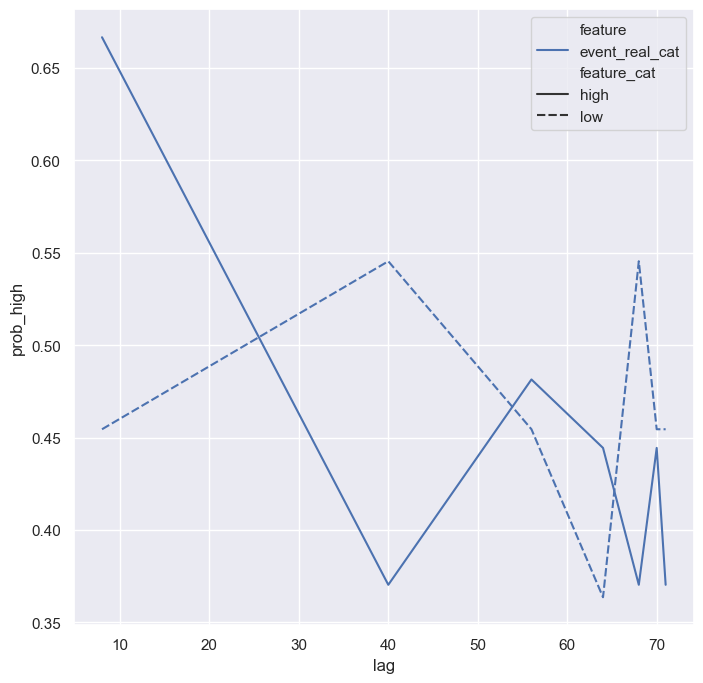

In [196]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
# plot through lag the prob high for each feature cat
sns.lineplot(
    data=df_prob[df_prob["feature"] == "event_real_cat"],
    x="lag",
    y="prob_high",
    hue="feature",
    style="feature_cat",
    ax=ax,
)

In [197]:
(72-8)*5 / 60

5.333333333333333

Here we can see that if the real event is positive around 5 hours before : 
- THEN the event target HIGH is 66% chance to happened 
- BE CAREFUL :  very low event number < 20

In [438]:
df_prob.sort_values(by=["delta_prob"], ascending=False).head(30)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
662        vwap_h_ETH_cat        high  64   23079  18513  0.493405  0.395788   
830           Low_ETH_cat        high  56   47042  40435  0.453911   0.39016   
632   ichi_tenkan_ETH_cat        high  64   25262  20525  0.487495  0.396083   
858     min_low_h_ETH_cat        high  56   30599  25390  0.459307  0.381117   
868        vwap_h_ETH_cat        high  56   28826  23813  0.481887  0.398084   
838   ichi_tenkan_ETH_cat        high  56   31288  26086  0.477381   0.39801   
652     min_low_h_ETH_cat        high  64   24977  20361  0.460898   0.37572   
624           Low_ETH_cat        high  64   43704  37536  0.452976  0.389047   
826          Open_ETH_cat        high  56   38424  32677  0.468157  0.398136   
620          Open_ETH_cat        high  64   32731  27474  0.473518  0.397465   
828          High_ETH_cat        high  56   39183  33469      0.47  0.401461   
426   ichi_tenkan_ETH_cat        high  68   19905  15896  0.496942  0.396854   
622          High_ETH_cat        high  64   33842  28607  0.475763  0.402168   
664        vwap_d_ETH_cat        high  64   19870  15927  0.497471  0.398753   
446     min_low_h_ETH_cat        high  68   19732  15822  0.459471  0.368425   
456        vwap_h_ETH_cat        high  68   18345  14583  0.500055  0.397509   
458        vwap_d_ETH_cat        high  68   16416  12914   0.50626  0.398261   
418           Low_ETH_cat        high  68   38825  33506  0.450474  0.388759   
870        vwap_d_ETH_cat        high  56   24610  20418   0.48382  0.401408   
240     min_low_h_ETH_cat        high  70   15145  11933  0.455283  0.358725   
250        vwap_h_ETH_cat        high  70   14951  11770  0.506179  0.398483   
836    ichi_kijun_ETH_cat        high  56   23465  19474  0.484324  0.401948   
161         rsi_h_ETH_cat         low  71   12479   9629  0.491919  0.379573   
252        vwap_d_ETH_cat        high  70   14225  11177  0.509382  0.400236   
630    ichi_kijun_ETH_cat        high  64   18946  15419   0.49448  0.402427   
46         vwap_d_ETH_cat        high  71   12999  10120  0.512417  0.398928   
424    ichi_kijun_ETH_cat        high  68   15913  12733  0.502177  0.401824   
220   ichi_tenkan_ETH_cat        high  70   15594  12449  0.501254  0.400161   
1034         High_ETH_cat        high  40   43216  37882  0.459549  0.402829   
159         rsi_h_BTC_cat         low  71   12384   9679  0.488174  0.381544   

      delta_prob  
662    1002.5176  
830   998.032603  
632   980.154585  
858   969.250424  
868   954.811794  
838   943.312441  
652   939.938065  
624   936.588479  
826   929.044852  
620   918.064912  
828   898.799648  
426    897.85654  
622    877.68339  
664   868.634187  
446    859.99325  
456   859.611516  
458   836.277122  
418   782.285908  
870   780.530514  
240   762.016693  
250   757.363946  
836    741.89343  
161   734.801882  
252   731.462405  
630   723.976662  
46    717.041481  
424   706.025274  
220   705.418465  
1034  701.658635  
159   663.284685

In [199]:
list_feat_high = list(df_prob.sort_values(by=["delta_prob"], ascending=False)["feature"].unique()[:10])

In [439]:
df_prob.sort_values(by=["delta_prob"]).head(30)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
651    max_high_h_ETH_cat         low  64   21408  25571  0.379696  0.453531   
445    max_high_h_ETH_cat         low  68   16546  20175  0.374217  0.456293   
239    max_high_h_ETH_cat         low  70   12294  15434  0.363739  0.456641   
857    max_high_h_ETH_cat         low  56   27216  31546  0.386783  0.448319   
160         rsi_h_ETH_cat        high  71    9716  12325  0.383002  0.485848   
663        vwap_h_ETH_cat         low  64   19266  22856  0.402768  0.477819   
633   ichi_tenkan_ETH_cat         low  64   21270  24918   0.40445  0.473816   
839   ichi_tenkan_ETH_cat         low  56   27355  31358  0.404313  0.463478   
621          Open_ETH_cat         low  64   28999  33076  0.404438  0.461298   
829          High_ETH_cat         low  56   43125  47925  0.396866  0.441038   
827          Open_ETH_cat         low  56   34814  39062  0.403683   0.45294   
459        vwap_d_ETH_cat         low  68   13290  15959  0.405826  0.487327   
623          High_ETH_cat         low  64   39719  44196  0.397456  0.442256   
427   ichi_tenkan_ETH_cat         low  68   16413  19333  0.407513  0.480013   
457        vwap_h_ETH_cat         low  68   15106  17882  0.407477  0.482359   
33     max_high_h_ETH_cat         low  71    9031  11204  0.355972  0.441624   
253        vwap_d_ETH_cat         low  70   11375  13781  0.406148  0.492056   
665        vwap_d_ETH_cat         low  64   16591  19469  0.407762  0.478495   
869        vwap_h_ETH_cat         low  56   25267  28731  0.407138  0.462955   
1063   max_high_h_ETH_cat         low  40   33140  37064   0.39625  0.443169   
221   ichi_tenkan_ETH_cat         low  70   12750  15190    0.4077  0.485723   
251        vwap_h_ETH_cat         low  70   12180  14551  0.408917  0.488518   
625           Low_ETH_cat         low  64   30113  33756  0.411335  0.461097   
158         rsi_h_BTC_cat        high  71    9934  12067  0.391596  0.475678   
47         vwap_d_ETH_cat         low  71   10361  12508  0.408428  0.493062   
831           Low_ETH_cat         low  56   35514  39367  0.409086  0.453469   
417          High_ETH_cat         low  68   35047  38861  0.397683  0.440961   
37     max_high_d_ETH_cat         low  71    9479  11442   0.37366  0.451041   
243    max_high_d_ETH_cat         low  70    9549  11503  0.374368  0.450974   
415          Open_ETH_cat         low  68   23210  26156   0.41052  0.462627   

      delta_prob  
651  -737.800677  
445  -717.281174  
239  -711.165609  
857  -638.130084  
160  -617.656277  
663  -611.941503  
633  -576.249415  
839  -545.841943  
621  -535.543423  
829  -506.095552  
827   -488.53495  
459  -487.097747  
623  -477.710278  
427  -477.054775  
457  -467.210865  
33   -466.709068  
253  -460.235014  
665  -459.394565  
869  -444.434831  
1063 -438.658082  
221  -426.170365  
251  -420.608357  
625  -415.583429  
158  -413.589291  
47   -403.131663  
831  -396.512039  
417  -393.640634  
37   -368.373309  
243  -362.731902  
415   -351.61512

In [201]:
list_feat_low = list(df_prob.sort_values(by=["delta_prob"])["feature"].unique()[:10])

In [202]:

list_feat_prob = list(set(list_feat_low + list_feat_high))
list_feat_prob

['vwap_h_ETH_cat',
 'rsi_h_ETH_cat',
 'ichi_tenkan_ETH_cat',
 'max_high_d_ETH_cat',
 'Low_ETH_cat',
 'Open_ETH_cat',
 'ichi_kijun_ETH_cat',
 'min_low_h_ETH_cat',
 'rsi_h_BTC_cat',
 'High_ETH_cat',
 'max_high_h_ETH_cat',
 'vwap_d_ETH_cat']

<Axes: xlabel='lag', ylabel='delta_prob'>

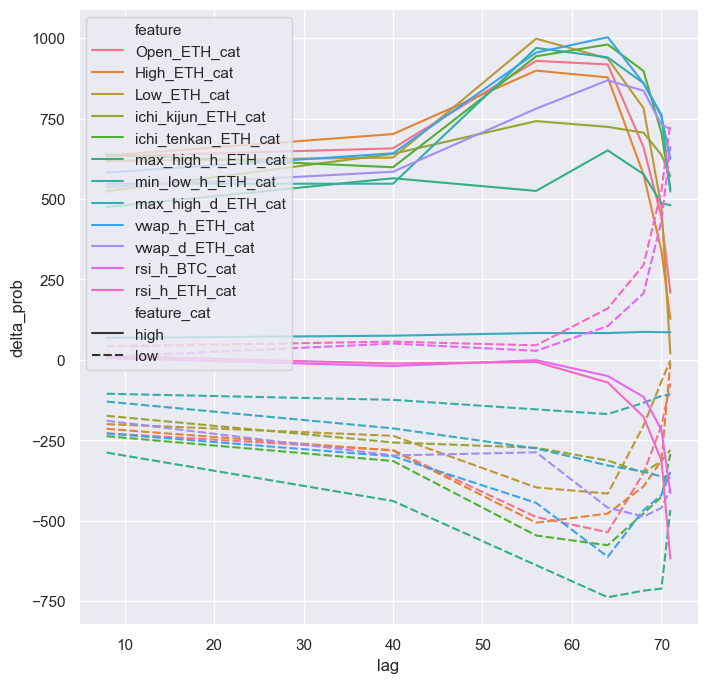

In [203]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
# plot through lag the prob high for each feature cat
sns.lineplot(
    data=df_prob[df_prob["feature"].isin(list_feat_prob)],
    x="lag",
    y="delta_prob",
    hue="feature",
    style="feature_cat",
    ax=ax,
)

<Axes: xlabel='lag', ylabel='prob_high'>

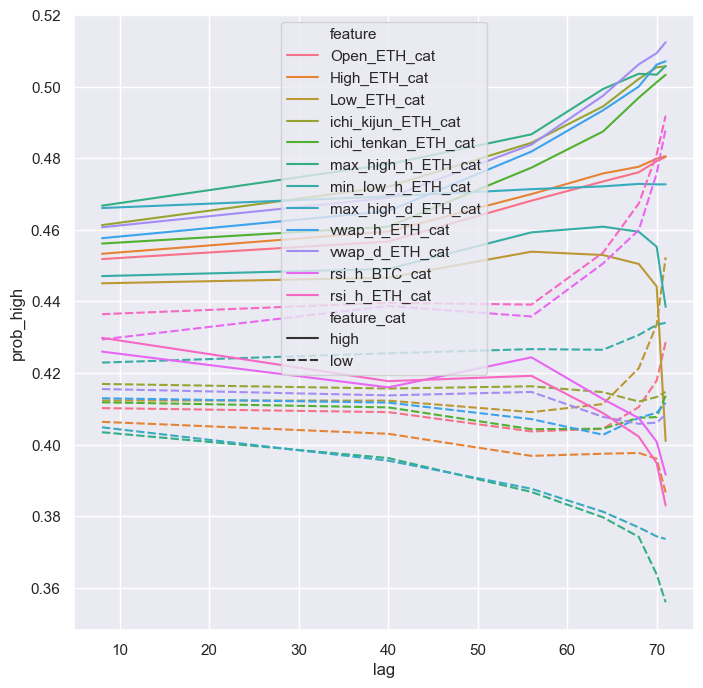

In [204]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
# plot through lag the prob high target for each feature cat
sns.lineplot(
    data=df_prob[df_prob["feature"].isin(list_feat_prob)],
    x="lag",
    y="prob_high",
    hue="feature",
    style="feature_cat",
    ax=ax,
)

In [205]:
df_prob[(df_prob["feature"] == "vwap_d_ETH_cat") & (df_prob["feature_cat"] == "high")].sort_values(by=["lag"])

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
1282  vwap_d_ETH_cat        high   8   36189  31913  0.460731  0.406292   
1076  vwap_d_ETH_cat        high  40   30200  26142  0.468959  0.405944   
870   vwap_d_ETH_cat        high  56   24610  20418   0.48382  0.401408   
664   vwap_d_ETH_cat        high  64   19870  15927  0.497471  0.398753   
458   vwap_d_ETH_cat        high  68   16416  12914   0.50626  0.398261   
252   vwap_d_ETH_cat        high  70   14225  11177  0.509382  0.400236   
46    vwap_d_ETH_cat        high  71   12999  10120  0.512417  0.398928   

      delta_prob  
1282  536.964436  
1076  584.550211  
870   780.530514  
664   868.634187  
458   836.277122  
252   731.462405  
46    717.041481

<Axes: xlabel='lag', ylabel='prob_low'>

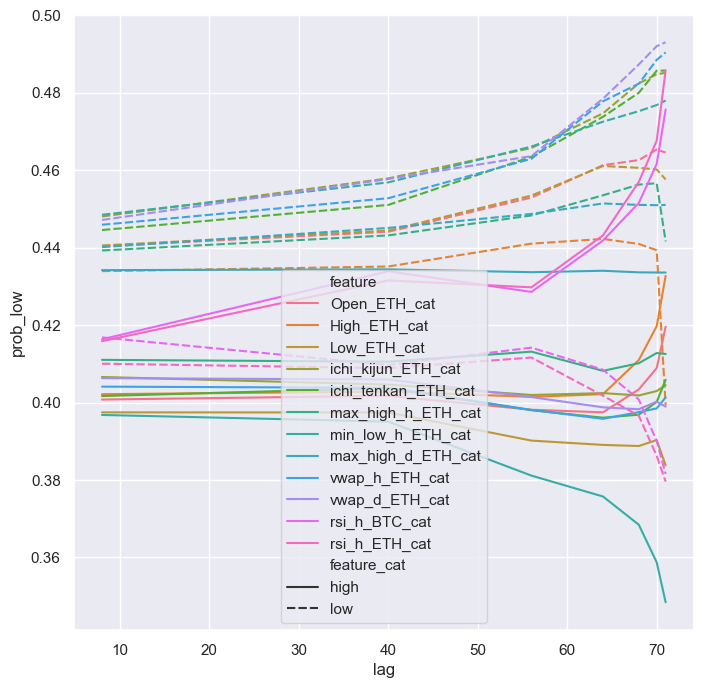

In [206]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
# plot through lag the prob low target for each feature cat
sns.lineplot(
    data=df_prob[df_prob["feature"].isin(list_feat_prob)],
    x="lag",
    y="prob_low",
    hue="feature",
    style="feature_cat",
    ax=ax,
)

In [207]:
df_['event_pred'].value_counts()

event_pred
 0.0    253628
 1.0        25
-1.0        24
Name: count, dtype: int64

In [208]:
len(list_df)

7

In [209]:
df = list_df[-1]

In [210]:
pd.crosstab(df['Volume_ETH_cat'], df['target_cat'], margins=True, normalize=True)

target_cat          high       low   neutral       All
Volume_ETH_cat                                        
high            0.045684  0.042566  0.011657  0.099907
low             0.038632  0.038100  0.023400  0.100131
neutral         0.340125  0.335111  0.124726  0.799962
All             0.424441  0.415777  0.159782  1.000000

##### With Best Positive Corr Features

max_high_h_ETH & Volume_ETH are the best positive impact on price. 

In [455]:
df_prob[
    (df_prob["feature"] == "max_high_h_ETH_cat") & (df_prob["feature_cat"] == "high")
    ].sort_values(by="prob_high", ascending=False)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
32    max_high_h_ETH_cat        high  71   12831  10465  0.505795  0.412528   
444   max_high_h_ETH_cat        high  68   15201  12380  0.503611  0.410151   
238   max_high_h_ETH_cat        high  70   13675  11214  0.503368   0.41278   
650   max_high_h_ETH_cat        high  64   17746  14506  0.499353  0.408183   
856   max_high_h_ETH_cat        high  56   21246  18035  0.486691  0.413135   
1062  max_high_h_ETH_cat        high  40   26095  22396  0.478342  0.410537   
1268  max_high_h_ETH_cat        high   8   31315  27575  0.466768  0.411021   

      delta_prob  
32     480.59375  
444   577.066894  
238   486.682551  
650   650.973583  
856   524.962246  
1062  564.335691  
1268  475.041603

Correlation confirmed and good for strat 2

In [456]:
df_prob[
    (df_prob["feature"] == "Volume_ETH_cat") & (df_prob["feature_cat"] == "high")
    ].sort_values(by="prob_high", ascending=False)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
346   Volume_ETH_cat        high  70   11959  11311  0.471439  0.445894   
140   Volume_ETH_cat        high  71   11945  11457  0.470869  0.451632   
552   Volume_ETH_cat        high  68   11781  11309  0.464441  0.445833   
1170  Volume_ETH_cat        high  40   11627  10975  0.458677  0.432956   
964   Volume_ETH_cat        high  56   11630  11132   0.45856  0.438924   
758   Volume_ETH_cat        high  64   11606  11327  0.457596  0.446595   
1376  Volume_ETH_cat        high   8   11589  10798  0.457268  0.426057   

     delta_prob  
346   36.089729  
140   20.352449  
552   19.297012  
1170  37.616494  
964   21.791055  
758    6.788558  
1376  55.896815

=> Correlation with less impact on strat 2

##### With Best Negative Corr Features
min_low_h_ETH & Close_ETH_raw are the best negative impact on price. 

In [473]:
##### On Best Negative Corr Features
df_prob[
    (df_prob["feature"] == "min_low_h_ETH_cat") & (df_prob["feature_cat"] == "high")
    ].sort_values(by="prob_low", ascending=False)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
1270  min_low_h_ETH_cat        high   8   40785  36196  0.447091  0.396786   
1064  min_low_h_ETH_cat        high  40   35556  31279  0.449087  0.395067   
858   min_low_h_ETH_cat        high  56   30599  25390  0.459307  0.381117   
652   min_low_h_ETH_cat        high  64   24977  20361  0.460898   0.37572   
446   min_low_h_ETH_cat        high  68   19732  15822  0.459471  0.368425   
240   min_low_h_ETH_cat        high  70   15145  11933  0.455283  0.358725   
34    min_low_h_ETH_cat        high  71   11124   8839  0.438471  0.348404   

      delta_prob  
1270  547.119965  
1064  547.399686  
858   969.250424  
652   939.938065  
446    859.99325  
240   762.016693  
34    523.090217

=> No clear conclusion

In [472]:
df_prob[
    (df_prob["feature"] == "Close_ETH_raw_cat") & (df_prob["feature_cat"] == "high")
    ].sort_values(by="prob_low", ascending=False)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
204   Close_ETH_raw_cat        high  71   10695  11055  0.421594  0.435785   
410   Close_ETH_raw_cat        high  70   10700  11050  0.421791  0.435588   
616   Close_ETH_raw_cat        high  68   10703  11045  0.421909  0.435391   
822   Close_ETH_raw_cat        high  64   10713  11043  0.422304  0.435312   
1028  Close_ETH_raw_cat        high  56   10733  11027  0.423092  0.434681   
1234  Close_ETH_raw_cat        high  40   10739  11005  0.423329  0.433814   
1440  Close_ETH_raw_cat        high   8   10775  10996  0.424748  0.433459   

     delta_prob  
204  -11.917241  
410  -11.264368  
616  -10.756299  
822  -10.011031  
1028  -7.944485  
1234  -6.508094  
1440  -4.486794

=> No clear conclusion

#### First LAG (oldest)
I_past closest to 0 is the oldest

In [211]:
len(list_df)

7

In [212]:
list_past

[71, 70, 68, 64, 56, 40, 8]

In [213]:
min_I_list_past = np.argmin(list_past)
min_I_list_past

np.int64(6)

In [214]:
df = list_df[min_I_list_past]

In [215]:
f"chi2_{list_past[min_I_list_past]}"

'chi2_8'

Text(0.5, 1.0, 'Min Chi2 between FIRST Lag and Target cat')

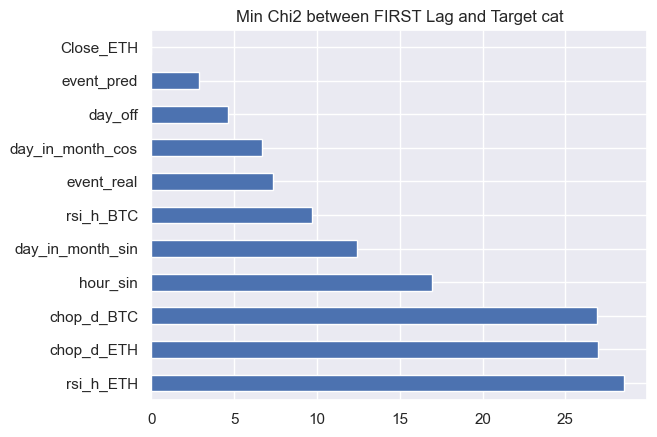

In [216]:
# find chi2_0 values in the 10% highest quantiles 
first_col_chi2 = f"chi2_{list_past[min_I_list_past]}"
min_quantile_chi2_10 = df_cont[first_col_chi2].quantile(0.10)
min_chi2_0 = df_cont[first_col_chi2].sort_values(ascending=False)
min_chi2_0[min_chi2_0.values<min_quantile_chi2_10].plot.barh()
# get current axis
ax = plt.gca()
# set y-axis label
ax.set_title("Min Chi2 between FIRST Lag and Target cat")


Results : We can see that some features have less impact on distrib :
- we are not going to study them
- we are going to study the features with the highest chi2

Text(0.5, 1.0, 'Max Chi2 between FIRST Lag and Target cat')

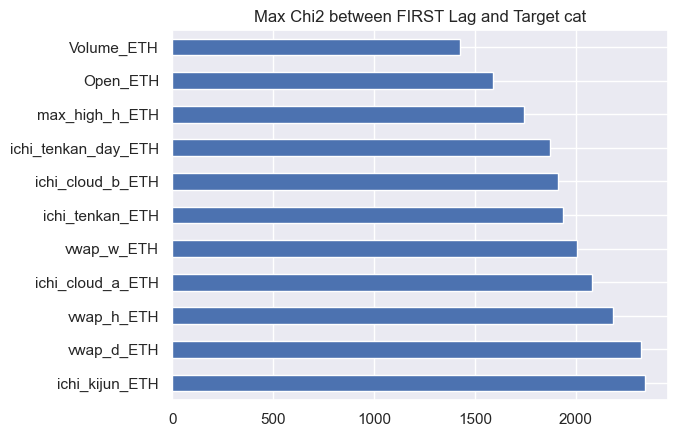

In [217]:
# find chi2_0 values in the 10% highest quantiles 
max_quantile_chi2_90 = df_cont[first_col_chi2].quantile(0.90)
max_chi2_0 = df_cont[first_col_chi2].sort_values(ascending=False)
max_chi2_0[max_chi2_0.values>max_quantile_chi2_90].plot.barh()
# get current axis
ax = plt.gca()
# set y-axis label
ax.set_title("Max Chi2 between FIRST Lag and Target cat")

expected:  [[32198.96719845 31541.65622425 12121.3765773 ]
 [33036.3899171  32361.98376282 12436.62632008]
 [42435.64288446 41569.36001293 15974.99710261]]
target_cat              high       low  neutral     Total
ichi_kijun_ETH_cat                                       
high                 34998.0   30845.0  10019.0   75862.0
low                  32454.0   34874.0  10507.0   77835.0
neutral              40219.0   39754.0  20007.0   99980.0
total               107671.0  105473.0  40533.0  253677.0
xi_n =  2340.7198679849225
chi2:  2340.7198679849225
dof:  4
p:  0.0
We have we have a 0.0000% chance for H0 to be true.
H0 : independance of distributions
H1 : distribution are not independant : we reject H0


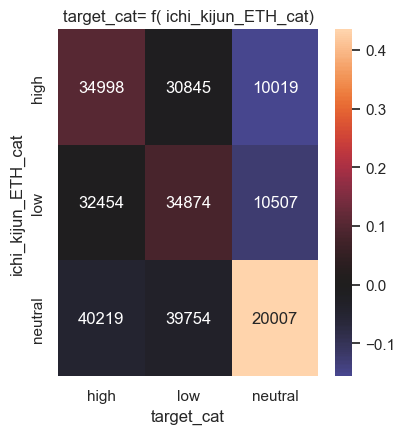

target_cat           high    low  neutral
ichi_kijun_ETH_cat                       
high                34998  30845    10019
low                 32454  34874    10507
neutral             40219  39754    20007

In [218]:
feat_name_max = max_chi2_0.index[0]
# plot contingency table for the feature with the highest chi2
X = feat_name_max + "_cat"
Y = "target_cat"
I_past = 0
plot_cont(X=X, Y=Y, data=df)

In [219]:
Y

'target_cat'

In [220]:
len(list_col_select)

103

In [221]:
len(list_col_select)*(len(list_col_select)-1)*(len(list_col_select)-2)

1061106

In [222]:
3*3*3

27

In [223]:
# create contingency dataframe
col_name_0 = f"{max_chi2_0.index[0]}_cat"
col_name_1 = f"{max_chi2_0.index[1]}_cat"
col_name_2 = f"{max_chi2_0.index[2]}_cat"
df_cross = pd.crosstab([df[col_name_0], df[col_name_1], df[col_name_2]], df[Y], margins=False, dropna=False)
# get target names
target_cat_names = df_cross.columns.to_list()
print("target_cat_names: ", target_cat_names)
# get index lengths
nb_level_0 = len(df_cross.index.levels[0])
nb_level_1 = len(df_cross.index.levels[1])
nb_level_2 = len(df_cross.index.levels[2])  
nb_targets = df_cross.shape[1]
# create array contingency
arr_cont = np.empty((nb_level_0,nb_level_1,nb_level_2,nb_targets))
for I_0, level_0 in enumerate(df_cross.index.levels[0]):
    #print("#level_0: ", I_0)
    for I_1,level_1 in enumerate(df_cross.index.levels[1]):
        #print("#level_1: ", I_1)
        arr_cont[I_0, I_1] = df_cross.loc[(level_0, level_1)].values
print("arr_cont.shape : ", arr_cont.shape)
# add probs
df_cross["p_high"] = df_cross["high"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
df_cross["p_low"] = df_cross["low"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
df_cross["p_neutral"] = df_cross["neutral"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
# just calculate ratio :  sign * delta (H - L)^2 /  mean(H,L) 
df_cross["chi2_delta_high"] = np.sign(df_cross["high"] - df_cross["low"]) * (df_cross["high"] - df_cross["low"])**2 / ((df_cross["low"] + df_cross["high"])/2)
# calc chi2, p-value, expected frequencies
res = stats.chi2_contingency(arr_cont)
print("chi2: ", res.statistic)
print("p-value: ", res.pvalue)
# add expected frequencies to df_cross
arr_exp = res.expected_freq.reshape(nb_level_0*nb_level_1*nb_level_2, nb_targets)
for I, col in enumerate(target_cat_names):
        df_cross[f"exp_{col}"] = arr_exp[:,I]
# get sign of difference between observed and expected frequencies
arr_sign = np.sign(arr_cont - res.expected_freq)
# calc chi2 ratio and add to df_cross
arr_chi2_ratio = arr_sign*((arr_cont - res.expected_freq)**2/res.expected_freq)/res.statistic
arr_chi2_ration_reshape = arr_chi2_ratio.reshape(nb_level_0*nb_level_1*nb_level_2, nb_targets)
for I, col in enumerate(target_cat_names):
        df_cross[f"chi2_pc_{col}"] = 100*arr_chi2_ration_reshape[:,I]
df_cross

target_cat_names:  ['high', 'low', 'neutral']
arr_cont.shape :  (3, 3, 3, 3)
chi2:  1460938.4315308577
p-value:  0.0


target_cat                                         high    low  neutral  \
ichi_kijun_ETH_cat vwap_d_ETH_cat vwap_h_ETH_cat                          
high               high           high            33282  29259     9367   
                                  low                17     19        7   
                                  neutral           751    674      279   
                   low            high                0      0        0   
                                  low                 4      9        2   
                                  neutral             0      0        0   
                   neutral        high              276    240      140   
                                  low                70     82       19   
                                  neutral           598    562      205   
low                high           high               10      4        0   
                                  low                 1      0        0   
                                  neutral             1      0        0   
                   low            high               12     13        0   
                                  low             30636  33201     9926   
                                  neutral           893    781      282   
                   neutral        high               71     65       17   
                                  low               238    248       87   
                                  neutral           592    562      195   
neutral            high           high             1888   1732      711   
                                  low                 0      0        1   
                                  neutral           239    225       80   
                   low            high                2      7        0   
                                  low              2186   2302      935   
                                  neutral           225    229       75   
                   neutral        high             4447   3987     1841   
                                  low              4195   4467     1786   
                                  neutral         27037  26805    14578   

target_cat                                          p_high     p_low  \
ichi_kijun_ETH_cat vwap_d_ETH_cat vwap_h_ETH_cat                       
high               high           high            0.462841  0.406895   
                                  low             0.395349  0.441860   
                                  neutral         0.440728  0.395540   
                   low            high                 NaN       NaN   
                                  low             0.266667  0.600000   
                                  neutral              NaN       NaN   
                   neutral        high            0.420732  0.365854   
                                  low             0.409357  0.479532   
                                  neutral         0.438095  0.411722   
low                high           high            0.714286  0.285714   
                                  low             1.000000  0.000000   
                                  neutral         1.000000  0.000000   
                   low            high            0.480000  0.520000   
                                  low             0.415330  0.450104   
                                  neutral         0.456544  0.399284   
                   neutral        high            0.464052  0.424837   
                                  low             0.415358  0.432810   
                                  neutral         0.438844  0.416605   
neutral            high           high            0.435927  0.399908   
                                  low             0.000000  0.000000   
                                  neutral         0.439338  0.413603   
                   low            high            0.222222  0.777778   
                                  low             0.403098  0.424488   
                        

In [224]:
# Threshold of prob 40%  : to have 15% to 30% of gains with nb trades per months on average :
# - 30 trades (with 2.5% cap risk) => 15% gains
# - to 300 trades (0.5 % capital risk)  => 30% gains
prob_tot = df_cross[["high", "neutral","low"]].sum(axis=0) / df_cross[["high", "neutral","low"]].sum().sum()
print("prob_tot: ", prob_tot)
#prob_target = 0.33
nb_per_sub_cat = df_cross[["high","low","neutral"]].sum(axis=1)
nb_per_sub_cat
#df_cross["exp_trigger_high"] = nb_per_sub_cat * prob_target
#df_cross["exp_trigger_low"] = nb_per_sub_cat * prob_target
#df_cross["exp_trigger_neutral"] = nb_per_sub_cat * prob_target


#df_cross["chi2_trigger_low"] = np.sign(df_cross["low"] - df_cross["exp_trigger_low"]) * (df_cross["low"] - df_cross["exp_trigger_low"])**2 / df_cross["exp_trigger_low"]
#df_cross["chi2_trigger_neutral"] = np.sign(df_cross["neutral"] - df_cross["exp_trigger_neutral"]) *  (df_cross["neutral"] - df_cross["exp_trigger_neutral"])**2 / df_cross["exp_trigger_neutral"]

df_cross.filter(["high","low","neutral","p_high","p_low","p_neutral","chi2_delta_high"])



prob_tot:  target_cat
high       0.424441
neutral    0.159782
low        0.415777
dtype: float64


high    low  neutral  \
ichi_kijun_ETH_cat vwap_d_ETH_cat vwap_h_ETH_cat                          
high               high           high            33282  29259     9367   
                                  low                17     19        7   
                                  neutral           751    674      279   
                   low            high                0      0        0   
                                  low                 4      9        2   
                                  neutral             0      0        0   
                   neutral        high              276    240      140   
                                  low                70     82       19   
                                  neutral           598    562      205   
low                high           high               10      4        0   
                                  low                 1      0        0   
                                  neutral             1      0        0   
                   low            high               12     13        0   
                                  low             30636  33201     9926   
                                  neutral           893    781      282   
                   neutral        high               71     65       17   
                                  low               238    248       87   
                                  neutral           592    562      195   
neutral            high           high             1888   1732      711   
                                  low                 0      0        1   
                                  neutral           239    225       80   
                   low            high                2      7        0   
                                  low              2186   2302      935   
                                  neutral           225    229       75   
                   neutral        high             4447   3987     1841   
                                  low              4195   4467     1786   
                                  neutral         27037  26805    14578   

                                                    p_high     p_low  \
ichi_kijun_ETH_cat vwap_d_ETH_cat vwap_h_ETH_cat                       
high               high           high            0.462841  0.406895   
                                  low             0.395349  0.441860   
                                  neutral         0.440728  0.395540   
                   low            high                 NaN       NaN   
                                  low             0.266667  0.600000   
                                  neutral              NaN       NaN   
                   neutral        high            0.420732  0.365854   
                                  low             0.409357  0.479532   
                                  neutral         0.438095  0.411722   
low                high           high            0.714286  0.285714   
                                  low             1.000000  0.000000   
                                  neutral         1.000000  0.000000   
                   low            high            0.480000  0.520000   
                                  low             0.415330  0.450104   
                                  neutral         0.456544  0.399284   
                   neutral        high            0.464052  0.424837   
                                  low             0.415358  0.432810   
                                  neutral         0.438844  0.416605   
neutral            high           high            0.435927  0.399908   
                                  low             0.000000  0.000000   
                                  neutral         0.439338  0.413603   
                   low            high            0.222222  0.777778   
                                  low             0.403098  0.424488   
                                  neutral         0.425331  0.432892   
   

In [225]:
df_cross.filter(["high","low","neutral","p_high","p_low","p_neutral","chi2_delta_high"]).loc[df_cross["chi2_delta_high"] > 10]

high    low  neutral  \
ichi_kijun_ETH_cat vwap_d_ETH_cat vwap_h_ETH_cat                          
high               high           high            33282  29259     9367   
low                low            neutral           893    781      282   
neutral            high           high             1888   1732      711   
                   neutral        high             4447   3987     1841   

                                                    p_high     p_low  \
ichi_kijun_ETH_cat vwap_d_ETH_cat vwap_h_ETH_cat                       
high               high           high            0.462841  0.406895   
low                low            neutral         0.456544  0.399284   
neutral            high           high            0.435927  0.399908   
                   neutral        high            0.432798  0.388029   

                                                  p_neutral  chi2_delta_high  
ichi_kijun_ETH_cat vwap_d_ETH_cat vwap_h_ETH_cat                              
high               high           high             0.130264       517.565405  
low                low            neutral          0.144172        14.986858  
neutral            high           high             0.164165        13.445304  
                   neutral        high             0.179173        50.177852

In [226]:
df_cross.filter(["high","low","neutral","p_high","p_low","p_neutral","chi2_delta_high"]).loc[df_cross["chi2_delta_high"] > 10].sum().sum() / df_cross.filter(["high","low","neutral"]).sum().sum()

np.float64(0.3511164804784843)

In [227]:
df_cross.filter(["high","low","neutral","p_high","p_low","p_neutral","chi2_delta_high"]).loc[df_cross["chi2_delta_high"] < -10]

high    low  neutral  \
ichi_kijun_ETH_cat vwap_d_ETH_cat vwap_h_ETH_cat                          
low                low            low             30636  33201     9926   
neutral            neutral        low              4195   4467     1786   

                                                    p_high     p_low  \
ichi_kijun_ETH_cat vwap_d_ETH_cat vwap_h_ETH_cat                       
low                low            low             0.415330  0.450104   
neutral            neutral        low             0.401512  0.427546   

                                                  p_neutral  chi2_delta_high  
ichi_kijun_ETH_cat vwap_d_ETH_cat vwap_h_ETH_cat                              
low                low            low              0.134566      -206.125758  
neutral            neutral        low              0.170942       -17.082429

In [228]:
df_cross.filter(["high","low","neutral","p_high","p_low","p_neutral","chi2_delta_high"]).loc[df_cross["chi2_delta_high"] < -10].sum().sum() / df_cross.filter(["high","low","neutral"]).sum().sum()

np.float64(0.3310895028449974)

In [229]:
((2-1)**2) / 1


1.0

In [230]:
((2000-1000)**2) / 1000

1000.0

In [231]:
22000 / df.shape[0]

0.08672445669098894

In [232]:
100*5/60

8.333333333333334

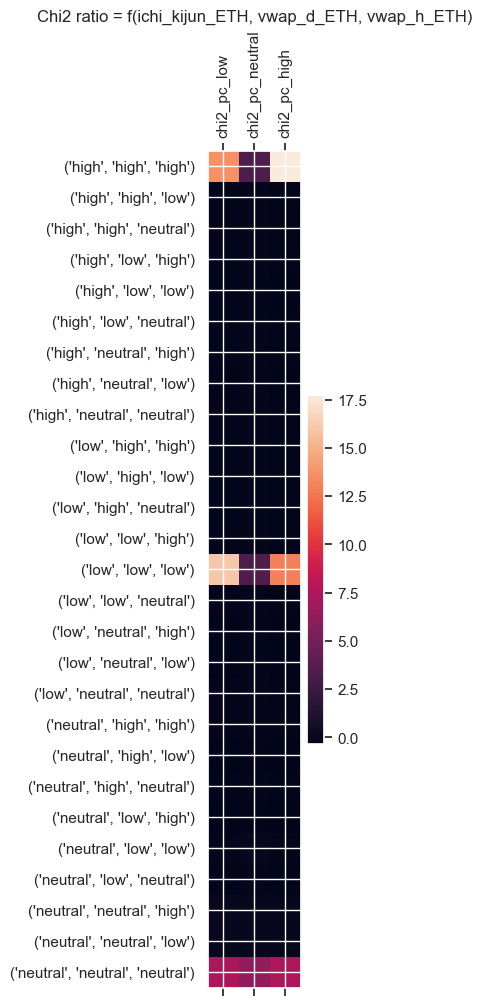

In [233]:
plot_corr(
    df_cross[["chi2_pc_low","chi2_pc_neutral","chi2_pc_high"]], 
    title = f"Chi2 ratio = f({max_chi2_0.index[0]}, {max_chi2_0.index[1]}, {max_chi2_0.index[2]})", 
    size=1.5,
)

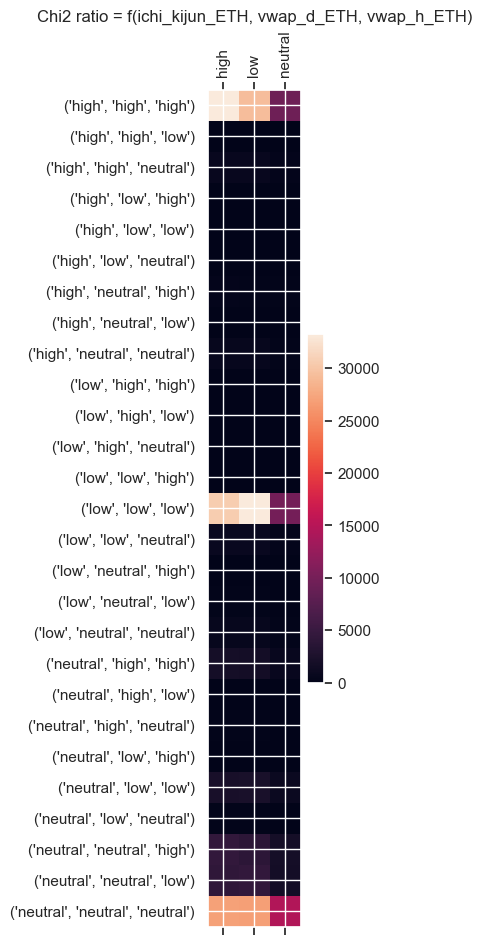

In [234]:
plot_corr(
    df_cross[["high","low","neutral"]], 
    title = f"Chi2 ratio = f({max_chi2_0.index[0]}, {max_chi2_0.index[1]}, {max_chi2_0.index[2]})", 
    size=1.5,
)

#### LAST Lag (newest)

In [235]:
list_past

[71, 70, 68, 64, 56, 40, 8]

In [236]:
df = list_df[0]

Text(0.5, 1.0, 'Min Chi2 between LAST Lag and LAST Target')

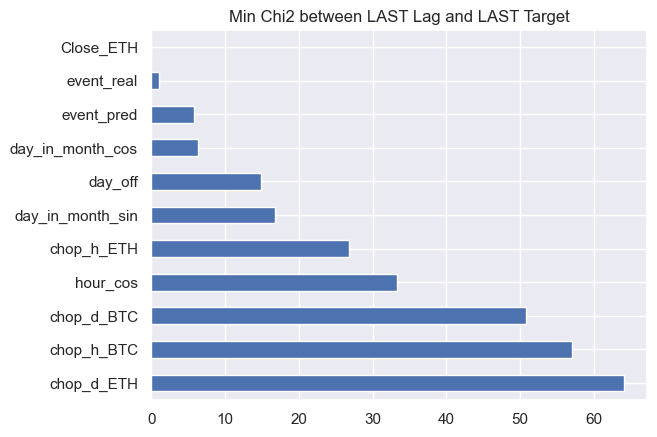

In [237]:
# find chi2_0 values in the 10% highest quantiles 
chi2_name = f"chi2_{list_past[0]}"
min_quantile_chi2_q10 = df_cont[chi2_name].quantile(0.10)
min_chi2_last = df_cont[chi2_name].sort_values(ascending=False)
min_chi2_last[min_chi2_last.values<min_quantile_chi2_q10].plot.barh()
# get current axis
ax = plt.gca()
# set y-axis label
ax.set_title("Min Chi2 between LAST Lag and LAST Target")

Text(0.5, 1.0, 'Max Chi2 between LAST Lag and Target cat')

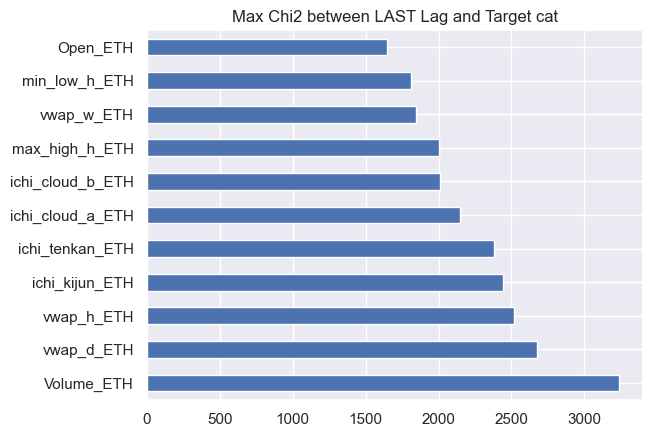

In [238]:
# find chi2_0 values in the 10% highest quantiles 
max_quantile_chi2_q90 = df_cont[chi2_name].quantile(0.90)
max_chi2_last = df_cont[chi2_name].sort_values(ascending=False)
max_chi2_last[max_chi2_last.values>max_quantile_chi2_q90].plot.barh()
# get current axis
ax = plt.gca()
# set y-axis label
ax.set_title("Max Chi2 between LAST Lag and Target cat")

In [239]:
feat_name_max = max_chi2_last.index[0]
# plot contingency table for the feature with the highest chi2
X = feat_name_max + "_cat"
Y = "target_cat"
plot_cont(X=X, Y=Y, data=df)

expected:  [[10767.2273324  10547.42473303  4053.34793458]
 [10767.2273324  10547.42473303  4053.34793458]
 [86136.54533521 84378.15053395 32426.30413084]]
target_cat          high       low  neutral     Total
Volume_ETH_cat                                       
high             11945.0   11457.0   1966.0   25368.0
low               9509.0    9229.0   6630.0   25368.0
neutral          86217.0   84787.0  31937.0  202941.0
total           107671.0  105473.0  40533.0  253677.0
xi_n =  3241.4025500048056
chi2:  3241.4025500048056
dof:  4
p:  0.0
We have we have a 0.0000% chance for H0 to be true.
H0 : independance of distributions
H1 : distribution are not independant : we reject H0


target_cat       high    low  neutral
Volume_ETH_cat                       
high            11945  11457     1966
low              9509   9229     6630
neutral         86217  84787    31937

In [240]:
Y

'target_cat'

In [241]:
X

'Volume_ETH_cat'

In [242]:
max_chi2_last.index[1]

'vwap_d_ETH'

In [243]:
# create contingency dataframe
col_name_0 = f"{max_chi2_last.index[0]}_cat"
col_name_1 = f"{max_chi2_last.index[1]}_cat"
col_name_2 = f"{max_chi2_last.index[2]}_cat"
df_cross = pd.crosstab([df[col_name_0], df[col_name_1], df[col_name_2]], df[Y], margins=False, dropna=False)
# get target names
target_cat_names = df_cross.columns.to_list()
print("target_cat_names: ", target_cat_names)
# get index lengths
nb_level_0 = len(df_cross.index.levels[0])
nb_level_1 = len(df_cross.index.levels[1])
nb_level_2 = len(df_cross.index.levels[2])  
nb_targets = df_cross.shape[1]
# create array contingency
arr_cont = np.empty((nb_level_0,nb_level_1,nb_level_2,nb_targets))
for I_0, level_0 in enumerate(df_cross.index.levels[0]):
    #print("#level_0: ", I_0)
    for I_1,level_1 in enumerate(df_cross.index.levels[1]):
        #print("#level_1: ", I_1)
        arr_cont[I_0, I_1] = df_cross.loc[(level_0, level_1)].values
print("arr_cont.shape : ", arr_cont.shape)
# add probs
df_cross["p_high"] = df_cross["high"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
df_cross["p_low"] = df_cross["low"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
df_cross["p_neutral"] = df_cross["neutral"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
# just calculate ratio :  sign * delta (H - L)^2 /  mean(H,L) 
df_cross["chi2_delta_high"] = np.sign(df_cross["high"] - df_cross["low"]) * (df_cross["high"] - df_cross["low"])**2 / ((df_cross["low"] + df_cross["high"])/2)
# calc chi2, p-value, expected frequencies
res = stats.chi2_contingency(arr_cont)
print("chi2: ", res.statistic)
print("p-value: ", res.pvalue)
# add expected frequencies to df_cross
arr_exp = res.expected_freq.reshape(nb_level_0*nb_level_1*nb_level_2, nb_targets)
for I, col in enumerate(target_cat_names):
        df_cross[f"exp_{col}"] = arr_exp[:,I]
# get sign of difference between observed and expected frequencies
arr_sign = np.sign(arr_cont - res.expected_freq)
# calc chi2 ratio and add to df_cross
arr_chi2_ratio = arr_sign*((arr_cont - res.expected_freq)**2/res.expected_freq)/res.statistic
arr_chi2_ration_reshape = arr_chi2_ratio.reshape(nb_level_0*nb_level_1*nb_level_2, nb_targets)
for I, col in enumerate(target_cat_names):
        df_cross[f"chi2_pc_{col}"] = 100*arr_chi2_ration_reshape[:,I]
df_cross

target_cat_names:  ['high', 'low', 'neutral']
arr_cont.shape :  (3, 3, 3, 3)
chi2:  596602.401229833
p-value:  0.0


target_cat                                     high    low  neutral    p_high  \
Volume_ETH_cat vwap_d_ETH_cat vwap_h_ETH_cat                                    
high           high           high             4067   3228      469  0.523828   
                              low                26     16        3  0.577778   
                              neutral           551    458       89  0.501821   
               low            high               22     23        3  0.458333   
                              low              3072   3714      528  0.420016   
                              neutral           454    463       81  0.454910   
               neutral        high              486    399       73  0.507307   
                              low               453    462       81  0.454819   
                              neutral          2814   2694      639  0.457784   
low            high           high               22     14       11  0.468085   
                              low                 0      0        0       NaN   
                              neutral            47     26       15  0.534091   
               low            high                0      0        0       NaN   
                              low                11     15        4  0.366667   
                              neutral            38     34       15  0.436782   
               neutral        high               31     25       20  0.407895   
                              low                49     39       11  0.494949   
                              neutral          9311   9076     6554  0.373321   
neutral        high           high             5547   4238     1033  0.512757   
                              low                14     13        3  0.466667   
                              neutral          2725   2127      626  0.497444   
               low            high               15     14        3  0.468750   
                              low              4311   5415     1092  0.398502   
                              neutral          2438   2830      773  0.403576   
               neutral        high             2674   2240      711  0.475378   
                              low              2508   2767      761  0.415507   
                              neutral         65985  65143    26935  0.417460   

target_cat                                       p_low  p_neutral  \
Volume_ETH_cat vwap_d_ETH_cat vwap_h_ETH_cat                        
high           high           high            0.415765   0.060407   
                              low             0.355556   0.066667   
                              neutral         0.417122   0.081056   
               low            high            0.479167   0.062500   
                              low             0.507793   0.072190   
                              neutral         0.463928   0.081162   
               neutral        high            0.416493   0.076200   
                              low             0.463855   0.081325   
                              neutral         0.438263   0.103953   
low            high           high            0.297872   0.234043   
                              low                  NaN        NaN   
                              neutral         0.295455   0.170455   
               low            high                 NaN        NaN   
                              low             0.500000   0.133333   
                              neutral         0.390805   0.172414   
               neutral        high            0.328947   0.263158   
                              low             0.393939   0.111111   
                              neutral         0.363899   0.262780   
neutral        high           high            0.391754   0.095489   
                              low             0.433333   0.100000   
                              neutral         0.388280   0.114275   
               low            high            0.437500   0.0937

In [244]:
# df_cross["p_high"] = df_cross["high"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
# df_cross["p_low"] = df_cross["low"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
# df_cross["p_neutral"] = df_cross["neutral"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
# df_cross

In [245]:
df_cross["high"] / df.shape[0]

Volume_ETH_cat  vwap_d_ETH_cat  vwap_h_ETH_cat
high            high            high              0.016032
                                low               0.000102
                                neutral           0.002172
                low             high              0.000087
                                low               0.012110
                                neutral           0.001790
                neutral         high              0.001916
                                low               0.001786
                                neutral           0.011093
low             high            high              0.000087
                                low               0.000000
                                neutral           0.000185
                low             high              0.000000
                                low               0.000043
                                neutral           0.000150
                neutral         high              0.000122
         

In [246]:
df_cross["high"].sum() / df_cross[["high", "neutral","low"]].sum().sum()

np.float64(0.4244413171079759)

In [247]:
df_cross["low"].sum() / df_cross[["high", "neutral","low"]].sum().sum()

np.float64(0.41577675548039433)

In [248]:
plot_corr(
    df_cross[["chi2_pc_low","chi2_pc_neutral","chi2_pc_high"]], 
    title = f"Chi2 ratio = f({max_chi2_last.index[0]}, {max_chi2_last.index[1]}, {max_chi2_last.index[2]})", 
    size=1.5,
)

In [249]:
list_len_levels = []
for I in range(len(df_cross.index.levels)): 
    list_len_levels.append(len(df_cross.index.levels[I]))
list_len_levels

[3, 3, 3]

In [250]:
df_cross.index.unique(level=2)

Index(['high', 'low', 'neutral'], dtype='object', name='vwap_h_ETH_cat')

##### check on first LAG (oldest)
We keep the same Features to do the cross table, and apply cat using for the FIRST Lag (oldest)  
To detect if these features are still important with oldest time

In [251]:
list_past[-1]

8

In [252]:
df = list_df[-1]

In [253]:
# create contingency dataframe
col_name_0 = f"{max_chi2_last.index[0]}_cat"
col_name_1 = f"{max_chi2_last.index[1]}_cat"
col_name_2 = f"{max_chi2_last.index[2]}_cat"
df_cross = pd.crosstab([df[col_name_0], df[col_name_1], df[col_name_2]], df[Y], margins=False, dropna=False)
# get target names
target_cat_names = df_cross.columns.to_list()
print("target_cat_names: ", target_cat_names)
# get index lengths
nb_level_0 = len(df_cross.index.levels[0])
nb_level_1 = len(df_cross.index.levels[1])
nb_level_2 = len(df_cross.index.levels[2])  
nb_targets = df_cross.shape[1]
# create array contingency
arr_cont = np.empty((nb_level_0,nb_level_1,nb_level_2,nb_targets))
for I_0, level_0 in enumerate(df_cross.index.levels[0]):
    #print("#level_0: ", I_0)
    for I_1,level_1 in enumerate(df_cross.index.levels[1]):
        #print("#level_1: ", I_1)
        arr_cont[I_0, I_1] = df_cross.loc[(level_0, level_1)].values
print("arr_cont.shape : ", arr_cont.shape)
# add probs
df_cross["p_high"] = df_cross["high"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
df_cross["p_low"] = df_cross["low"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
df_cross["p_neutral"] = df_cross["neutral"] / (df_cross["high"] + df_cross["low"]+ df_cross["neutral"])
# just calculate ratio :  sign * delta (H - L)^2 /  mean(H,L) 
df_cross["chi2_delta_high"] = np.sign(df_cross["high"] - df_cross["low"]) * (df_cross["high"] - df_cross["low"])**2 / ((df_cross["low"] + df_cross["high"])/2)
# calc chi2, p-value, expected frequencies
res = stats.chi2_contingency(arr_cont)
print("chi2: ", res.statistic)
print("p-value: ", res.pvalue)
# add expected frequencies to df_cross
arr_exp = res.expected_freq.reshape(nb_level_0*nb_level_1*nb_level_2, nb_targets)
for I, col in enumerate(target_cat_names):
        df_cross[f"exp_{col}"] = arr_exp[:,I]
# get sign of difference between observed and expected frequencies
arr_sign = np.sign(arr_cont - res.expected_freq)
# calc chi2 ratio and add to df_cross
arr_chi2_ratio = arr_sign*((arr_cont - res.expected_freq)**2/res.expected_freq)/res.statistic
arr_chi2_ration_reshape = arr_chi2_ratio.reshape(nb_level_0*nb_level_1*nb_level_2, nb_targets)
for I, col in enumerate(target_cat_names):
        df_cross[f"chi2_pc_{col}"] = 100*arr_chi2_ration_reshape[:,I]
df_cross

target_cat_names:  ['high', 'low', 'neutral']
arr_cont.shape :  (3, 3, 3, 3)
chi2:  399347.7529921597
p-value:  0.0


target_cat                                     high    low  neutral    p_high  \
Volume_ETH_cat vwap_d_ETH_cat vwap_h_ETH_cat                                    
high           high           high             4157   3724      882  0.474381   
                              low                 9     10        3  0.409091   
                              neutral           225    196       71  0.457317   
               low            high                6     12        0  0.333333   
                              low              4551   4432     1091  0.451757   
                              neutral           220    184       65  0.469083   
               neutral        high              399    368      119  0.450339   
                              low               490    479      147  0.439068   
                              neutral          1532   1393      579  0.437215   
low            high           high             2491   1971      931  0.461895   
                              low                 0      0        0       NaN   
                              neutral            29     29       10  0.426471   
               low            high                0      0        0       NaN   
                              low              1963   2195      904  0.387791   
                              neutral            24     24       12  0.400000   
               neutral        high              515    446      279  0.415323   
                              low               434    529      256  0.356030   
                              neutral          4344   4471     3544  0.351485   
neutral        high           high            28532  25300     8265  0.459475   
                              low                 9      9        5  0.391304   
                              neutral           737    674      278  0.436353   
               low            high                8      8        0  0.500000   
                              low             26312  28885     8868  0.410708   
                              neutral           874    802      280  0.446830   
               neutral        high             3880   3478     1600  0.433132   
                              low              3579   3789     1489  0.404087   
                              neutral         22351  22065    10855  0.404389   

target_cat                                       p_low  p_neutral  \
Volume_ETH_cat vwap_d_ETH_cat vwap_h_ETH_cat                        
high           high           high            0.424969   0.100650   
                              low             0.454545   0.136364   
                              neutral         0.398374   0.144309   
               low            high            0.666667   0.000000   
                              low             0.439944   0.108299   
                              neutral         0.392324   0.138593   
               neutral        high            0.415350   0.134312   
                              low             0.429211   0.131720   
                              neutral         0.397546   0.165240   
low            high           high            0.365474   0.172631   
                              low                  NaN        NaN   
                              neutral         0.426471   0.147059   
               low            high                 NaN        NaN   
                              low             0.433623   0.178586   
                              neutral         0.400000   0.200000   
               neutral        high            0.359677   0.225000   
                              low             0.433962   0.210008   
                              neutral         0.361761   0.286755   
neutral        high           high            0.407427   0.133098   
                              low             0.391304   0.217391   
                              neutral         0.399053   0.164594   
               low            high            0.500000   0.0000

Results : same rank for chi-2  as for last lag, but smaller values: time between have impact => less direct impact

In [254]:
plot_corr(
    df_cross[["chi2_pc_low","chi2_pc_neutral","chi2_pc_high"]], 
    title = f"Chi2 ratio = f({max_chi2_last.index[0]}, {max_chi2_last.index[1]}, {max_chi2_last.index[2]})", 
    size=1.5,
)

expected:  [[10757.04074078 10537.4460909   4049.51316832]
 [10781.23389586 10561.14536596  4058.62073818]
 [86132.72536336 84374.40854315 32424.8660935 ]]
target_cat          high       low  neutral     Total
Volume_ETH_cat                                       
high             11589.0   10798.0   2957.0   25344.0
low               9800.0    9665.0   5936.0   25401.0
neutral          86282.0   85010.0  31640.0  202932.0
total           107671.0  105473.0  40533.0  253677.0
xi_n =  1423.3370026538046
chi2:  1423.3370026538048
dof:  4
p:  6.014291776145968e-307
We have we have a 0.0000% chance for H0 to be true.
H0 : independance of distributions
H1 : distribution are not independant : we reject H0


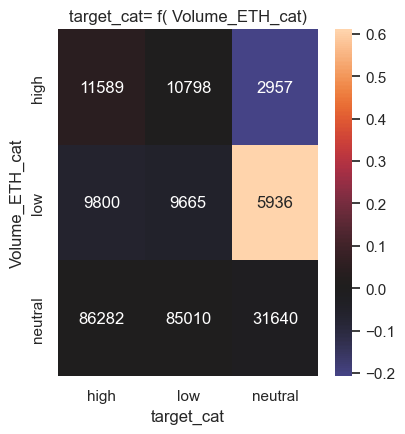

target_cat       high    low  neutral
Volume_ETH_cat                       
high            11589  10798     2957
low              9800   9665     5936
neutral         86282  85010    31640

In [255]:
X = feat_name_max + "_cat"
Y = "target_cat"
plot_cont(X=X, Y=Y, data=df)

### Prob study

In [256]:
list_past

[71, 70, 68, 64, 56, 40, 8]

In [257]:

def get_index_combinations(n_elements, k_selection):
    """
    Generates all combinations of indices for selecting k elements from a list of n.

    Args:
        n_elements (int): The total number of elements in the list.
        k_selection (int): The number of elements to choose in each combination.

    Returns:
        list: A list of tuples, where each tuple is a combination of indices.
    """
    # Create a list of indices from 0 to n_elements - 1
    indices = range(n_elements)

    # Generate the combinations
    combinations = list(itertools.combinations(indices, k_selection))
    
    return combinations

In [258]:
get_index_combinations(6, 3)

[(0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 2, 3),
 (0, 2, 4),
 (0, 2, 5),
 (0, 3, 4),
 (0, 3, 5),
 (0, 4, 5),
 (1, 2, 3),
 (1, 2, 4),
 (1, 2, 5),
 (1, 3, 4),
 (1, 3, 5),
 (1, 4, 5),
 (2, 3, 4),
 (2, 3, 5),
 (2, 4, 5),
 (3, 4, 5)]

#### On Highest delta_prob
delta prob between high and low

##### Per feature, per lag

In [259]:
df_prob.sort_values(by=["delta_prob"], ascending=False).head(7)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
662       vwap_h_ETH_cat        high  64   23079  18513  0.493405  0.395788   
830          Low_ETH_cat        high  56   47042  40435  0.453911   0.39016   
632  ichi_tenkan_ETH_cat        high  64   25262  20525  0.487495  0.396083   
858    min_low_h_ETH_cat        high  56   30599  25390  0.459307  0.381117   
868       vwap_h_ETH_cat        high  56   28826  23813  0.481887  0.398084   
838  ichi_tenkan_ETH_cat        high  56   31288  26086  0.477381   0.39801   
652    min_low_h_ETH_cat        high  64   24977  20361  0.460898   0.37572   

     delta_prob  
662   1002.5176  
830  998.032603  
632  980.154585  
858  969.250424  
868  954.811794  
838  943.312441  
652  939.938065

In [260]:
df_prob.sort_values(by=["delta_prob"], ascending=True).head(7)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
651   max_high_h_ETH_cat         low  64   21408  25571  0.379696  0.453531   
445   max_high_h_ETH_cat         low  68   16546  20175  0.374217  0.456293   
239   max_high_h_ETH_cat         low  70   12294  15434  0.363739  0.456641   
857   max_high_h_ETH_cat         low  56   27216  31546  0.386783  0.448319   
160        rsi_h_ETH_cat        high  71    9716  12325  0.383002  0.485848   
663       vwap_h_ETH_cat         low  64   19266  22856  0.402768  0.477819   
633  ichi_tenkan_ETH_cat         low  64   21270  24918   0.40445  0.473816   

     delta_prob  
651 -737.800677  
445 -717.281174  
239 -711.165609  
857 -638.130084  
160 -617.656277  
663 -611.941503  
633 -576.249415

In [261]:
# check with best linear correlation features
# compare best correlation tuples (feat, lag) and the best delta_prob tuple (feat, lag)

##### Per combinaison of 3 tuples of feature/lag

In [ ]:
# algo check new data : 
# - hash input of function : hash of df_prob
# - compare with input hash file on disk : path_prob_hash
# - if same, load df_prob_comb : path_df_prob_comb

# hash input
hash_df_prob = get_data_hash(df_prob)
# load df_prob file hash
path_prob_hash = os.path.join(path_data, 'df_prob_hash.txt')
hash_df_prob_old = load_hash(path_prob_hash)

# compare hash
if hash_df_prob == hash_df_prob_old:
    print("hash match: mode load df_prob_comb")
    # load df_prob_comb
    df_prob_comb = pd.read_csv(path_df_prob_comb)
    mode_do_comb = False
else:
    print("hash not match : mode redo comb")
    mode_do_comb = True



hash match: mode load df_prob_comb


In [ ]:
# Probability  of target high or low for Combination of best features (highest and lowest delta_prob) 
# Combinaison of 3 features (1 feat = 1 feature on one lag)
nb_best_feat = 30 # limited to 30th first ones
df_prob_high = df_prob.sort_values(by=["delta_prob"], ascending=False).head(nb_best_feat)
df_prob_low = df_prob.sort_values(by=["delta_prob"], ascending=True).head(nb_best_feat)
list_study_feat_high = df_prob_high["feature"].values
list_study_lag_high = df_prob_high["lag"].values
list_study_I_past_high = [np.argmax(np.array(list_past) == x) for x in list_study_lag_high]
list_study_feat_low = df_prob_low["feature"].values
list_study_lag_low = df_prob_low["lag"].values
list_study_I_past_low = [np.argmax(np.array(list_past) == x) for x in list_study_lag_low]
for I in range(len(list_study_feat_high)):
    print(list_study_feat_high[I], list_study_lag_high[I])
for I in range(len(list_study_feat_low)):
    print(list_study_feat_low[I], list_study_lag_low[I])

# Target cat = High
# get all combinaisons
list_comb_high = get_index_combinations(len(list_study_feat_high), 3)
print("Cross Table Computaton nb : len(list_comb_high) : ", len(list_comb_high))
# Target cat = Low
# get all combinaisons
list_comb_low = get_index_combinations(len(list_study_feat_low), 3)
print("Cross Table Computaton nb : len(list_comb_low) : ", len(list_comb_low))

if mode_do_comb :
    list_cross = []
    df_prob_comb = pd.DataFrame()
    # HIGH
    for comb in list_comb_high:
        col_name_0 = list_study_feat_high[comb[0]]
        col_name_1 = list_study_feat_high[comb[1]]
        col_name_2 = list_study_feat_high[comb[2]]
        I_past_0 = list_study_I_past_high[comb[0]]
        I_past_1 = list_study_I_past_high[comb[1]]
        I_past_2 = list_study_I_past_high[comb[2]]
        lag_0 = list_study_lag_high[comb[0]]
        lag_1 = list_study_lag_high[comb[1]]
        lag_2 = list_study_lag_high[comb[2]]
        df_cross_comb = pd.crosstab(
            [
                list_df[I_past_0][col_name_0],
                list_df[I_past_1][col_name_1], 
                list_df[I_past_2][col_name_2],
            ],
            df_targets["target_cat"], 
            margins=False, 
            dropna=False
        )
        # add probs
        df_cross_comb["p_high"] = df_cross_comb["high"] / (df_cross_comb["high"] + df_cross_comb["low"]+ df_cross_comb["neutral"])
        df_cross_comb["p_low"] = df_cross_comb["low"] / (df_cross_comb["high"] + df_cross_comb["low"]+ df_cross_comb["neutral"])
        # just calculate ratio :  sign * delta (H - L)^2 /  mean(H,L) 
        df_cross_comb["delta_prob"] = np.sign(
            df_cross_comb["high"] - df_cross_comb["low"]) * (
                df_cross_comb["high"] - df_cross_comb["low"])**2 / (
                    (df_cross_comb["low"] + df_cross_comb["high"])/2)
        list_cross.append(df_cross_comb)
        df_cross_comb = df_cross_comb.reset_index(allow_duplicates=True)
        df_cross_comb["feat_0"] = df_cross_comb.columns[0]
        df_cross_comb["feat_0_cat"] = df_cross_comb.values[:,0]
        df_cross_comb["lag_0"] = lag_0
        df_cross_comb["feat_1"] = df_cross_comb.columns[1]
        df_cross_comb["feat_1_cat"] = df_cross_comb.values[:,1]
        df_cross_comb["lag_1"] = lag_1
        df_cross_comb["feat_2"] = df_cross_comb.columns[2]
        df_cross_comb["feat_2_cat"] = df_cross_comb.values[:,2]
        df_cross_comb["lag_2"] = lag_2
        df_cross_comb.drop(columns=[col_name_0, col_name_1, col_name_2], inplace=True)
        if df_prob_comb.shape[0] == 0:
            df_prob_comb = df_cross_comb
        else:
            #pd.concat([df_prob, ser_prob_curr.to_frame().T], ignore_index=True)
            df_prob_comb = pd.concat([df_prob_comb, df_cross_comb], ignore_index=True)
    print(" ")
    print("Cross Table Computed nb : len(list_cross) : ", len(list_cross))

    # LOW
    for comb in list_comb_low:
        col_name_0 = list_study_feat_low[comb[0]]
        col_name_1 = list_study_feat_low[comb[1]]
        col_name_2 = list_study_feat_low[comb[2]]
        I_past_0 = list_study_I_past_low[comb[0]]
        I_past_1 = list_study_I_past_low[comb[1]]
        I_past_2 = list_study_I_past_low[comb[2]]
        lag_0 = list_study_lag_low[comb[0]]
        lag_1 = list_study_lag_low[comb[1]]
        lag_2 = list_study_lag_low[comb[2]]
        df_cross_comb = pd.crosstab(
            [
                list_df[I_past_0][col_name_0],
                list_df[I_past_1][col_name_1], 
                list_df[I_past_2][col_name_2]
            ],
            df_targets["target_cat"], 
            margins=False, 
            dropna=False
        )
        # add probs
        df_cross_comb["p_high"] = df_cross_comb["high"] / (df_cross_comb["high"] + df_cross_comb["low"]+ df_cross_comb["neutral"])
        df_cross_comb["p_low"] = df_cross_comb["low"] / (df_cross_comb["high"] + df_cross_comb["low"]+ df_cross_comb["neutral"])
        # just calculate ratio :  sign * delta (H - L)^2 /  mean(H,L) 
        df_cross_comb["delta_prob"] = np.sign(
            df_cross_comb["high"] - df_cross_comb["low"]) * (
                df_cross_comb["high"] - df_cross_comb["low"])**2 / (
                    (df_cross_comb["low"] + df_cross_comb["high"])/2)
        list_cross.append(df_cross_comb)
        df_cross_comb = df_cross_comb.reset_index(allow_duplicates=True)
        df_cross_comb["feat_0"] = df_cross_comb.columns[0]
        df_cross_comb["feat_0_cat"] = df_cross_comb.values[:,0]
        df_cross_comb["lag_0"] = lag_0
        df_cross_comb["feat_1"] = df_cross_comb.columns[1]
        df_cross_comb["feat_1_cat"] = df_cross_comb.values[:,1]
        df_cross_comb["lag_1"] = lag_1
        df_cross_comb["feat_2"] = df_cross_comb.columns[2]
        df_cross_comb["feat_2_cat"] = df_cross_comb.values[:,2]
        df_cross_comb["lag_2"] = lag_2
        df_cross_comb.drop(columns=[col_name_0, col_name_1, col_name_2], inplace=True)
        if df_prob_comb.shape[0] == 0:
            df_prob_comb = df_cross_comb
        else:
            #pd.concat([df_prob, ser_prob_curr.to_frame().T], ignore_index=True)
            df_prob_comb = pd.concat([df_prob_comb, df_cross_comb], ignore_index=True)

    # save CSV
    df_prob_comb.to_csv(path_df_prob_comb, index=False)
    # save hash inputs
    with open(path_prob_hash, 'w') as file:
        file.write(hash_df_prob)
df_prob_comb.sort_values(by=["delta_prob"], ascending=False)


vwap_h_ETH_cat 64
Low_ETH_cat 56
ichi_tenkan_ETH_cat 64
min_low_h_ETH_cat 56
vwap_h_ETH_cat 56
ichi_tenkan_ETH_cat 56
min_low_h_ETH_cat 64
Low_ETH_cat 64
Open_ETH_cat 56
Open_ETH_cat 64
High_ETH_cat 56
ichi_tenkan_ETH_cat 68
High_ETH_cat 64
vwap_d_ETH_cat 64
min_low_h_ETH_cat 68
vwap_h_ETH_cat 68
vwap_d_ETH_cat 68
Low_ETH_cat 68
vwap_d_ETH_cat 56
min_low_h_ETH_cat 70
vwap_h_ETH_cat 70
ichi_kijun_ETH_cat 56
rsi_h_ETH_cat 71
vwap_d_ETH_cat 70
ichi_kijun_ETH_cat 64
vwap_d_ETH_cat 71
ichi_kijun_ETH_cat 68
ichi_tenkan_ETH_cat 70
High_ETH_cat 40
rsi_h_BTC_cat 71
max_high_h_ETH_cat 64
max_high_h_ETH_cat 68
max_high_h_ETH_cat 70
max_high_h_ETH_cat 56
rsi_h_ETH_cat 71
vwap_h_ETH_cat 64
ichi_tenkan_ETH_cat 64
ichi_tenkan_ETH_cat 56
Open_ETH_cat 64
High_ETH_cat 56
Open_ETH_cat 56
vwap_d_ETH_cat 68
High_ETH_cat 64
ichi_tenkan_ETH_cat 68
vwap_h_ETH_cat 68
max_high_h_ETH_cat 71
vwap_d_ETH_cat 70
vwap_d_ETH_cat 64
vwap_h_ETH_cat 56
max_high_h_ETH_cat 40
ichi_tenkan_ETH_cat 70
vwap_h_ETH_cat 70
Low_ET

high    low  neutral    p_high     p_low   delta_prob  \
11097   22523  18012     5264  0.491779  0.393284  1004.027186   
166671  22523  18012     5264  0.491779  0.393284  1004.027186   
172395  27770  22736     7063  0.482378  0.394935  1003.490912   
13176   27770  22736     7063  0.482378  0.394935  1003.490912   
48762   28062  23007     7104  0.482389  0.395493  1000.725489   
...       ...    ...      ...       ...       ...          ...   
219220      0      0        0       NaN       NaN          NaN   
219221      0      0        0       NaN       NaN          NaN   
219222      0      0        0       NaN       NaN          NaN   
219223      0      0        0       NaN       NaN          NaN   
219224      0      0        0       NaN       NaN          NaN   

                     feat_0 feat_0_cat  lag_0               feat_1 feat_1_cat  \
11097           Low_ETH_cat       high     56  ichi_tenkan_ETH_cat       high   
166671  ichi_tenkan_ETH_cat       high     64         Open_ETH_cat       high   
172395  ichi_tenkan_ETH_cat       high     56         High_ETH_cat       high   
13176           Low_ETH_cat       high     56  ichi_tenkan_ETH_cat       high   
48762   ichi_tenkan_ETH_cat       high     56         Open_ETH_cat       high   
...                     ...        ...    ...                  ...        ...   
219220   max_high_d_ETH_cat       high     71   max_high_d_ETH_cat    neutral   
219221   max_high_d_ETH_cat       high     71   max_high_d_ETH_cat    neutral   
219222   max_high_d_ETH_cat        low     71   max_high_d_ETH_cat       high   
219223   max_high_d_ETH_cat        low     71   max_high_d_ETH_cat       high   
219224   max_high_d_ETH_cat        low     71   max_high_d_ETH_cat       high   

        lag_1        feat_2 feat_2_cat  lag_2  
11097      64  Open_ETH_cat       high     56  
166671     56   Low_ETH_cat       high     56  
172395     56   Low_ETH_cat       high     56  
13176      56  High_ETH_cat       high     56  
48762      56  High_ETH_cat       high     56  
...       ...           ...        ...    ...  
219220     70  Open_ETH_cat        low     68  
219221     70  Open_ETH_cat    neutral     68  
219222     70  Open_ETH_cat       high     68  
219223     70  Open_ETH_cat        low     68  
219224     70  Open_ETH_cat    neutral     68  

[219240 rows x 15 columns]

In [264]:
df_prob_comb.sort_values(by=["delta_prob"], ascending=False).head(20)

high    low  neutral    p_high     p_low   delta_prob  \
11097   22523  18012     5264  0.491779  0.393284  1004.027186   
166671  22523  18012     5264  0.491779  0.393284  1004.027186   
172395  27770  22736     7063  0.482378  0.394935  1003.490912   
13176   27770  22736     7063  0.482378  0.394935  1003.490912   
48762   28062  23007     7104  0.482389  0.395493  1000.725489   
171990  28062  23007     7104  0.482389  0.395493  1000.725489   
186840  25310  20526     6199  0.486403  0.394465   998.632341   
12528   25310  20526     6199  0.486403  0.394465   998.632341   
191457  25295  20516     6234  0.486022  0.394197   997.089826   
12474   25295  20516     6234  0.486022  0.394197   997.089826   
13122   27809  22788     7180  0.481316  0.394413   996.519201   
172908  27809  22788     7180  0.481316  0.394413   996.519201   
183519  25733  20914     6272  0.486271  0.395208   995.680794   
41310   25733  20914     6272  0.486271  0.395208   995.680794   
167616  20539  16260     4622  0.495860  0.392555   995.127096   
11205   20539  16260     4622  0.495860  0.392555   995.127096   
189270  22399  17926     5237  0.491616  0.393442   992.323819   
15012   22399  17926     5237  0.491616  0.393442   992.323819   
200178  22667  18169     5570  0.488450  0.391523   990.890587   
14445   22667  18169     5570  0.488450  0.391523   990.890587   

                     feat_0 feat_0_cat  lag_0               feat_1 feat_1_cat  \
11097           Low_ETH_cat       high     56  ichi_tenkan_ETH_cat       high   
166671  ichi_tenkan_ETH_cat       high     64         Open_ETH_cat       high   
172395  ichi_tenkan_ETH_cat       high     56         High_ETH_cat       high   
13176           Low_ETH_cat       high     56  ichi_tenkan_ETH_cat       high   
48762   ichi_tenkan_ETH_cat       high     56         Open_ETH_cat       high   
171990  ichi_tenkan_ETH_cat       high     56         High_ETH_cat       high   
186840         High_ETH_cat       high     56       vwap_h_ETH_cat       high   
12528           Low_ETH_cat       high     56       vwap_h_ETH_cat       high   
191457         Open_ETH_cat       high     56       vwap_h_ETH_cat       high   
12474           Low_ETH_cat       high     56       vwap_h_ETH_cat       high   
13122           Low_ETH_cat       high     56  ichi_tenkan_ETH_cat       high   
172908  ichi_tenkan_ETH_cat       high     56         Open_ETH_cat       high   
183519         High_ETH_cat       high     56         Open_ETH_cat       high   
41310        vwap_h_ETH_cat       high     56         Open_ETH_cat       high   
167616  ichi_tenkan_ETH_cat       high     64         High_ETH_cat       high   
11205           Low_ETH_cat       high     56  ichi_tenkan_ETH_cat       high   
189270         Open_ETH_cat       high     56         High_ETH_cat       high   
15012           Low_ETH_cat       high     56         Open_ETH_cat       high   
200178         High_ETH_cat       high     64          Low_ETH_cat       high   
14445           Low_ETH_cat       high     56          Low_ETH_cat       high   

        lag_1          feat_2 feat_2_cat  lag_2  
11097      64    Open_ETH_cat       high     56  
166671     56     Low_ETH_cat       high     56  
172395     56     Low_ETH_cat       high     56  
13176      56    High_ETH_cat       high     56  
48762      56    High_ETH_cat       high     56  
171990     56    Open_ETH_cat       high     56  
186840     56     Low_ETH_cat       high     56  
12528      56    High_ETH_cat       high     56  
191457     56     Low_ETH_cat       high     56  
12474      56    Open_ETH_cat       high     56  
13122      56    Open_ETH_cat       high     56  
172908     56     Low_ETH_cat       high     56  
183519     56  vwap_h_ETH_cat       high     56  
41310      56    High_ETH_cat       high     56  
167616     64     Low_ETH_cat       high     56  
11205      64    High_ETH_cat       high     64  
189270     64     Low_ETH_cat       high     56  
15012      56    Hig

In [265]:
df_prob.sort_values(by=["delta_prob"], ascending=False).head(20)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
662       vwap_h_ETH_cat        high  64   23079  18513  0.493405  0.395788   
830          Low_ETH_cat        high  56   47042  40435  0.453911   0.39016   
632  ichi_tenkan_ETH_cat        high  64   25262  20525  0.487495  0.396083   
858    min_low_h_ETH_cat        high  56   30599  25390  0.459307  0.381117   
868       vwap_h_ETH_cat        high  56   28826  23813  0.481887  0.398084   
838  ichi_tenkan_ETH_cat        high  56   31288  26086  0.477381   0.39801   
652    min_low_h_ETH_cat        high  64   24977  20361  0.460898   0.37572   
624          Low_ETH_cat        high  64   43704  37536  0.452976  0.389047   
826         Open_ETH_cat        high  56   38424  32677  0.468157  0.398136   
620         Open_ETH_cat        high  64   32731  27474  0.473518  0.397465   
828         High_ETH_cat        high  56   39183  33469      0.47  0.401461   
426  ichi_tenkan_ETH_cat        high  68   19905  15896  0.496942  0.396854   
622         High_ETH_cat        high  64   33842  28607  0.475763  0.402168   
664       vwap_d_ETH_cat        high  64   19870  15927  0.497471  0.398753   
446    min_low_h_ETH_cat        high  68   19732  15822  0.459471  0.368425   
456       vwap_h_ETH_cat        high  68   18345  14583  0.500055  0.397509   
458       vwap_d_ETH_cat        high  68   16416  12914   0.50626  0.398261   
418          Low_ETH_cat        high  68   38825  33506  0.450474  0.388759   
870       vwap_d_ETH_cat        high  56   24610  20418   0.48382  0.401408   
240    min_low_h_ETH_cat        high  70   15145  11933  0.455283  0.358725   

     delta_prob  
662   1002.5176  
830  998.032603  
632  980.154585  
858  969.250424  
868  954.811794  
838  943.312441  
652  939.938065  
624  936.588479  
826  929.044852  
620  918.064912  
828  898.799648  
426   897.85654  
622   877.68339  
664  868.634187  
446   859.99325  
456  859.611516  
458  836.277122  
418  782.285908  
870  780.530514  
240  762.016693

In [266]:
df_prob_comb.sort_values(by=["delta_prob"], ascending=True).head(20)

high    low  neutral    p_high     p_low  delta_prob  \
110551   9037  11905     4386  0.356799  0.470033 -785.543310   
109822  13599  17050     6060  0.370454  0.464464 -777.147770   
171436  15606  19265     4903  0.392367  0.484362 -767.874796   
49315   15606  19265     4903  0.392367  0.484362 -767.874796   
49369   15194  18803     4770  0.391931  0.485026 -766.237080   
171517  15194  18803     4770  0.391931  0.485026 -766.237080   
49882   16987  20791     5700  0.390703  0.478196 -766.076341   
172057  16987  20791     5700  0.390703  0.478196 -766.076341   
120757  10539  13578     5052  0.361308  0.465494 -765.893022   
114979  19325  23367     8119  0.380331  0.459881 -765.378244   
134662  10278  13275     4787  0.362668  0.468419 -762.706152   
171868  15646  19276     4821  0.393679  0.485016 -754.647500   
13162   15646  19276     4821  0.393679  0.485016 -754.647500   
173785  15048  18590     4528  0.394278  0.487083 -745.928058   
48262   15048  18590     4528  0.394278  0.487083 -745.928058   
125185  15068  18612     6498  0.375031  0.463239 -745.839430   
110632   8933  11706     4281  0.358467  0.469743 -745.145501   
68053   18904  22844     6293  0.393497  0.475511 -743.681134   
177673  18904  22844     6293  0.393497  0.475511 -743.681134   
109903  13423  16769     5920  0.371705  0.464361 -741.634605   

                     feat_0 feat_0_cat  lag_0               feat_1 feat_1_cat  \
110551   max_high_h_ETH_cat        low     64   max_high_h_ETH_cat        low   
109822   max_high_h_ETH_cat        low     64   max_high_h_ETH_cat        low   
171436  ichi_tenkan_ETH_cat        low     56         Open_ETH_cat        low   
49315   ichi_tenkan_ETH_cat        low     56         Open_ETH_cat        low   
49369   ichi_tenkan_ETH_cat        low     56         Open_ETH_cat        low   
171517  ichi_tenkan_ETH_cat        low     56         Open_ETH_cat        low   
49882   ichi_tenkan_ETH_cat        low     56         High_ETH_cat        low   
172057  ichi_tenkan_ETH_cat        low     56         High_ETH_cat        low   
120757   max_high_h_ETH_cat        low     68   max_high_h_ETH_cat        low   
114979   max_high_h_ETH_cat        low     64         High_ETH_cat        low   
134662   max_high_h_ETH_cat        low     70         High_ETH_cat        low   
171868  ichi_tenkan_ETH_cat        low     56         Open_ETH_cat        low   
13162           Low_ETH_cat        low     56  ichi_tenkan_ETH_cat        low   
173785  ichi_tenkan_ETH_cat        low     56         High_ETH_cat        low   
48262   ichi_tenkan_ETH_cat        low     56          Low_ETH_cat        low   
125185   max_high_h_ETH_cat        low     68         High_ETH_cat        low   
110632   max_high_h_ETH_cat        low     64   max_high_h_ETH_cat        low   
68053          Open_ETH_cat        low     56         Open_ETH_cat        low   
177673         Open_ETH_cat        low     64         High_ETH_cat        low   
109903   max_high_h_ETH_cat        low     64   max_high_h_ETH_cat        low   

        lag_1        feat_2 feat_2_cat  lag_2  
110551     70  High_ETH_cat        low     56  
109822     68  High_ETH_cat        low     56  
171436     64  High_ETH_cat        low     56  
49315      64  High_ETH_cat        low     56  
49369      64  High_ETH_cat        low     64  
171517     64  High_ETH_cat        low     64  
49882      56  High_ETH_cat        low     64  
172057     56  High_ETH_cat        low     64  
120757     70  High_ETH_cat        low     56  
114979     56  High_ETH_cat        low     64  
134662     56  High_ETH_cat        low     64  
171868     64   Low_ETH_cat        low     56  
13162      56  Open_ETH_cat        low     64  
173785     64   Low_ETH_cat        low     64  
48262      64  High_ETH_cat        low     64  
125185     56  High_ETH_cat        low     64  
110632     70  High_ETH_cat        low     64  
68053      64  High_ETH_cat        low     56  
177673     56  Open_ETH_cat  

In [267]:
df_prob.sort_values(by=["delta_prob"], ascending=True).head(20)

feature feature_cat lag nb_high nb_low prob_high  prob_low  \
651    max_high_h_ETH_cat         low  64   21408  25571  0.379696  0.453531   
445    max_high_h_ETH_cat         low  68   16546  20175  0.374217  0.456293   
239    max_high_h_ETH_cat         low  70   12294  15434  0.363739  0.456641   
857    max_high_h_ETH_cat         low  56   27216  31546  0.386783  0.448319   
160         rsi_h_ETH_cat        high  71    9716  12325  0.383002  0.485848   
663        vwap_h_ETH_cat         low  64   19266  22856  0.402768  0.477819   
633   ichi_tenkan_ETH_cat         low  64   21270  24918   0.40445  0.473816   
839   ichi_tenkan_ETH_cat         low  56   27355  31358  0.404313  0.463478   
621          Open_ETH_cat         low  64   28999  33076  0.404438  0.461298   
829          High_ETH_cat         low  56   43125  47925  0.396866  0.441038   
827          Open_ETH_cat         low  56   34814  39062  0.403683   0.45294   
459        vwap_d_ETH_cat         low  68   13290  15959  0.405826  0.487327   
623          High_ETH_cat         low  64   39719  44196  0.397456  0.442256   
427   ichi_tenkan_ETH_cat         low  68   16413  19333  0.407513  0.480013   
457        vwap_h_ETH_cat         low  68   15106  17882  0.407477  0.482359   
33     max_high_h_ETH_cat         low  71    9031  11204  0.355972  0.441624   
253        vwap_d_ETH_cat         low  70   11375  13781  0.406148  0.492056   
665        vwap_d_ETH_cat         low  64   16591  19469  0.407762  0.478495   
869        vwap_h_ETH_cat         low  56   25267  28731  0.407138  0.462955   
1063   max_high_h_ETH_cat         low  40   33140  37064   0.39625  0.443169   

      delta_prob  
651  -737.800677  
445  -717.281174  
239  -711.165609  
857  -638.130084  
160  -617.656277  
663  -611.941503  
633  -576.249415  
839  -545.841943  
621  -535.543423  
829  -506.095552  
827   -488.53495  
459  -487.097747  
623  -477.710278  
427  -477.054775  
457  -467.210865  
33   -466.709068  
253  -460.235014  
665  -459.394565  
869  -444.434831  
1063 -438.658082

In [356]:
df_prob_comb.loc[(df_prob_comb["high"] > 1000) & (df_prob_comb["p_high"] > 0.51)]

high    low  neutral    p_high     p_low  delta_prob          feat_0  \
486     12684   9854     2264  0.511410  0.397307  710.701926  vwap_h_ETH_cat   
621     12443   9680     2146  0.512712  0.398863  690.156760  vwap_h_ETH_cat   
675     11219   8713     1959  0.512494  0.398017  630.146097  vwap_h_ETH_cat   
1215    13185  10289     2359  0.510394  0.398289  714.562154  vwap_h_ETH_cat   
1296    13333  10472     2327  0.510217  0.400735  687.697627  vwap_h_ETH_cat   
...       ...    ...      ...       ...       ...         ...             ...   
218949   6907   5245     1288  0.513914  0.390253  454.615537  vwap_d_ETH_cat   
218970   3841   3105      488  0.516680  0.417676  155.973510     Low_ETH_cat   
218997   3856   3113      489  0.517029  0.417404  158.429904     Low_ETH_cat   
219078   3465   2781      458  0.516856  0.414827  149.809798     Low_ETH_cat   
219105   3480   2789      459  0.517241  0.414536  152.330834     Low_ETH_cat   

       feat_0_cat  lag_0               feat_1 feat_1_cat  lag_1  \
486          high     64          Low_ETH_cat       high     56   
621          high     64          Low_ETH_cat       high     56   
675          high     64          Low_ETH_cat       high     56   
1215         high     64  ichi_tenkan_ETH_cat       high     64   
1296         high     64  ichi_tenkan_ETH_cat       high     64   
...           ...    ...                  ...        ...    ...   
218949       high     71   max_high_d_ETH_cat    neutral     70   
218970       high     56         High_ETH_cat       high     68   
218997       high     56         High_ETH_cat       high     68   
219078       high     56   max_high_d_ETH_cat       high     71   
219105       high     56   max_high_d_ETH_cat       high     70   

                     feat_2 feat_2_cat  lag_2  
486          vwap_h_ETH_cat       high     70  
621          vwap_d_ETH_cat       high     71  
675     ichi_tenkan_ETH_cat       high     70  
1215         vwap_h_ETH_cat       high     70  
1296         vwap_d_ETH_cat       high     70  
...                     ...        ...    ...  
218949         Open_ETH_cat       high     68  
218970   max_high_d_ETH_cat       high     71  
218997   max_high_d_ETH_cat       high     70  
219078         Open_ETH_cat       high     68  
219105         Open_ETH_cat       high     68  

[6184 rows x 15 columns]

## Temporal Distribution

In [664]:
len(list_df)

7

In [665]:
PAST_HISTORY

72

In [666]:
list_past

[71, 70, 68, 64, 56, 40, 8]

In [667]:
# 1st lag : 
print(list_past[0])
start = 0
end = - list_past[0] - 1 - FUTURE_TARGET
print("first lag : ", start, end)
print(pd.to_datetime(df_feat[df_feat["train"]].iloc[start:end]["date_ETH"]))
# 2nd lag : 
start = list_past[0] - list_past[1]
end = - list_past[1] - 1 - FUTURE_TARGET
print("second lag : ", start, end)
print(pd.to_datetime(df_feat[df_feat["train"]].iloc[start:end]["date_ETH"]))
# 3nd lag : 
start = list_past[0] - list_past[2]
end = - list_past[2] - 1 - FUTURE_TARGET
print("third lag : ", start, end)
print(pd.to_datetime(df_feat[df_feat["train"]].iloc[start:end]["date_ETH"]))

71
first lag :  0 -87
0        2023-01-01 00:00:00
1        2023-01-01 00:05:00
2        2023-01-01 00:10:00
3        2023-01-01 00:15:00
4        2023-01-01 00:20:00
                 ...        
253672   2025-05-30 19:15:00
253673   2025-05-30 19:20:00
253674   2025-05-30 19:25:00
253675   2025-05-30 19:30:00
253676   2025-05-30 19:35:00
Name: date_ETH, Length: 253677, dtype: datetime64[ns]
second lag :  1 -86
1        2023-01-01 00:05:00
2        2023-01-01 00:10:00
3        2023-01-01 00:15:00
4        2023-01-01 00:20:00
5        2023-01-01 00:25:00
                 ...        
253673   2025-05-30 19:20:00
253674   2025-05-30 19:25:00
253675   2025-05-30 19:30:00
253676   2025-05-30 19:35:00
253677   2025-05-30 19:40:00
Name: date_ETH, Length: 253677, dtype: datetime64[ns]
third lag :  3 -84
3        2023-01-01 00:15:00
4        2023-01-01 00:20:00
5        2023-01-01 00:25:00
6        2023-01-01 00:30:00
7        2023-01-01 00:35:00
                 ...        
253675   2025-05-30

In [668]:
# 1st lag : 
print(list_past[0])
start = 0
end = - list_past[0] - 1 - FUTURE_TARGET
print("first lag : ", start, end)
index_first_lag = pd.to_datetime(df_feat[df_feat["train"]].iloc[start:end]["date_ETH"])
print(index_first_lag)

for I in range(len(list_df)):
    list_df[I].set_index(index_first_lag, inplace=True)

print(list_df[0].head(2))
print(list_df[-1].head(2))

71
first lag :  0 -87
0        2023-01-01 00:00:00
1        2023-01-01 00:05:00
2        2023-01-01 00:10:00
3        2023-01-01 00:15:00
4        2023-01-01 00:20:00
                 ...        
253672   2025-05-30 19:15:00
253673   2025-05-30 19:20:00
253674   2025-05-30 19:25:00
253675   2025-05-30 19:30:00
253676   2025-05-30 19:35:00
Name: date_ETH, Length: 253677, dtype: datetime64[ns]
                     Close_ETH  Open_ETH  High_ETH   Low_ETH  \
date_ETH                                                       
2023-01-01 00:00:00        1.0  0.999782  1.000109  0.999774   
2023-01-01 00:05:00        1.0  0.999548  1.000008  0.999540   

                     ichi_cloud_a_ETH  ichi_cloud_b_ETH  ichi_kijun_ETH  \
date_ETH                                                                  
2023-01-01 00:00:00          0.999171          0.999736        0.998393   
2023-01-01 00:05:00          0.998785          0.999276        0.998113   

                     ichi_tenkan_ETH  ichi_clou

In [669]:
""" 
assessment of temporal homogeneity of proba for each feature in 
count the numbers of days/weeks/minths with minimum one event 
use list_df and update df_prob_comb with this new insights, knowing that :
- list_df is a list of all lags timeseries dataframe
- same index == target
- an event is a 3 tuples of (features/lags) 
- each row is one event
- 1 group by days and count days with at minimum one event
- feature names are in df_prob_comb : 
- each row in df_prob_comb is an event : 
   e.g. : each line is the definition of intersection of 3 sub-events : 
     - (feat_0 ,feat_0_cat, lag_0 ) & (feat_1, feat_1_cat, lag_1) & (feat_2, feat_2_cat, lag_2)  
- You need to find the lag values in list_past 
- knowing that list_df is a list dataframe for each lag in list_past. 
- Find if an event exist in dataframe in list_df on each period (day/week/month) for each event in df_prob_comb.
 """

def assess_temporal_homogeneity(df_prob_comb, list_df, list_past):
    """
    Assesses the temporal homogeneity of events defined in df_prob_comb.

    Counts the number of unique days, weeks, and months where each event occurs.
    An event is a combination of conditions on different features at different lags.

    Args:
        df_prob_comb (pd.DataFrame): DataFrame where each row defines a complex event.
            Expected columns: 'feat_0', 'feat_0_cat', 'lag_0',
                              'feat_1', 'feat_1_cat', 'lag_1',
                              'feat_2', 'feat_2_cat', 'lag_2'.
        list_df (list of pd.DataFrame): List of timeseries DataFrames, one for each lag.
                                        All DataFrames must share the same DatetimeIndex.
        list_past (list): List of lags corresponding to the DataFrames in list_df.

    Returns:
        pd.DataFrame: The input df_prob_comb with added columns:
                      'days_with_event', 'weeks_with_event', 'months_with_event'.
    """
    # Create a mapping from lag value to its corresponding DataFrame for quick lookup
    if len(list_df) != len(list_past):
        raise ValueError("list_df and list_past must have the same length.")
    lag_to_df = {lag: df for lag, df in zip(list_past, list_df)}

    # Ensure all dataframes have a datetime index
    for lag, df in lag_to_df.items():
        if not isinstance(df.index, pd.DatetimeIndex):
            raise TypeError(f"DataFrame for lag {lag} does not have a DatetimeIndex.")

    # List to store the results for each event (row)
    temporal_counts = []
    df_combined_condition = pd.DataFrame(index=list_df[0].index)
    list_combined_condition = []
    global_combined_condition = pd.Series(False, index=list_df[0].index)
    # Iterate over each event defined in df_prob_comb
    for index, event_row in df_prob_comb.iterrows():
        # Extract the 3 sub-events
        sub_events = [
            {'feat': event_row['feat_0'], 'cat': event_row['feat_0_cat'], 'lag': event_row['lag_0']},
            {'feat': event_row['feat_1'], 'cat': event_row['feat_1_cat'], 'lag': event_row['lag_1']},
            {'feat': event_row['feat_2'], 'cat': event_row['feat_2_cat'], 'lag': event_row['lag_2']},
        ]

        # --- Build the combined boolean condition ---
        # Start with a Series of all True values, with the correct index
        # Assuming all DFs in list_df have the same index, we can pick the first one.
        combined_condition = pd.Series(True, index=list_df[0].index)

        for sub_event in sub_events:
            lag, feat, cat = sub_event['lag'], sub_event['feat'], sub_event['cat']

            if lag not in lag_to_df:
                raise KeyError(f"Lag '{lag}' from event {index} not found in list_past.")
            df_for_lag = lag_to_df[lag]

            if feat not in df_for_lag.columns:
                raise KeyError(f"Feature '{feat}' from event {index} not found in DataFrame for lag {lag}.")

            # Create the boolean condition for this sub-event and AND it
            combined_condition &= (df_for_lag[feat] == cat)
        #df_combined_condition[f"event_{index}"] = combined_condition
        #df_combined_condition.insert(0, f"event_{index}", combined_condition)
        list_combined_condition.append(combined_condition)
        # --- Count periods with at least one event ---
        event_timestamps = combined_condition[combined_condition].index
        
        days_count = len(event_timestamps.normalize().unique())
        weeks_count = len(event_timestamps.to_period('W').unique())
        months_count = len(event_timestamps.to_period('M').unique())

        all_days_count = len(combined_condition.index.normalize().unique()) 
        all_weeks_count = len(combined_condition.index.to_period('W').unique())
        all_months_count = len(combined_condition.index.to_period('M').unique())

        temporal_counts.append({
            'days_with_event': days_count,
            'weeks_with_event': weeks_count,
            'months_with_event': months_count,
            'ratio_days_with_event': days_count / all_days_count,
            'ratio_weeks_with_event': weeks_count / all_weeks_count,
            'ratio_months_with_event': months_count / all_months_count,
        })

        # global event 
        global_combined_condition |= combined_condition

    # concat combined conditions
    df_combined_condition = pd.concat(list_combined_condition, axis=1)
    # sum of global event for each day
    global_event_by_day = global_combined_condition.groupby(global_combined_condition.index.normalize()).sum()

    # Convert results to a DataFrame and join with the original
    counts_df = pd.DataFrame(temporal_counts, index=df_prob_comb.index)
    df_prob_comb_updated = df_prob_comb.join(counts_df)

    return df_prob_comb_updated, global_event_by_day, df_combined_condition



In [670]:
df_prob_comb.loc[(df_prob_comb["high"] > 8000) & (df_prob_comb["p_high"] > 0.4)]

high    low  neutral    p_high     p_low  delta_prob  \
0       20487  16340     4502  0.495705  0.395364  933.967415   
13      16950  20295     4940  0.401802  0.481095 -600.833669   
20      21301  19625     9959  0.418611  0.385674  137.270977   
23      13680  13893     5343  0.415603  0.422074   -3.290828   
27      17019  13459     3819  0.496224  0.392425  831.655620   
...       ...    ...      ...       ...       ...         ...   
219202  13880  15828     4853  0.401609  0.457973 -255.466810   
219212  33440  31363    15247  0.417739  0.391793  133.139793   
219237  20915  17521     5701  0.473865  0.396969  599.398272   
219238  15856  17865     5395  0.405358  0.456718 -239.380861   
219239  49297  47518    22586  0.412869  0.397970   65.379146   

                    feat_0 feat_0_cat  lag_0              feat_1 feat_1_cat  \
0           vwap_h_ETH_cat       high     64         Low_ETH_cat       high   
13          vwap_h_ETH_cat        low     64         Low_ETH_cat        low   
20          vwap_h_ETH_cat    neutral     64         Low_ETH_cat       high   
23          vwap_h_ETH_cat    neutral     64         Low_ETH_cat        low   
27          vwap_h_ETH_cat       high     64         Low_ETH_cat       high   
...                    ...        ...    ...                 ...        ...   
219202        High_ETH_cat        low     68  max_high_d_ETH_cat    neutral   
219212        High_ETH_cat    neutral     68  max_high_d_ETH_cat    neutral   
219237  max_high_d_ETH_cat    neutral     71  max_high_d_ETH_cat    neutral   
219238  max_high_d_ETH_cat    neutral     71  max_high_d_ETH_cat    neutral   
219239  max_high_d_ETH_cat    neutral     71  max_high_d_ETH_cat    neutral   

        lag_1               feat_2 feat_2_cat  lag_2  
0          56  ichi_tenkan_ETH_cat       high     64  
13         56  ichi_tenkan_ETH_cat        low     64  
20         56  ichi_tenkan_ETH_cat    neutral     64  
23         56  ichi_tenkan_ETH_cat    neutral     64  
27         56    min_low_h_ETH_cat       high     56  
...       ...                  ...        ...    ...  
219202     70         Open_ETH_cat        low     68  
219212     70         Open_ETH_cat    neutral     68  
219237     70         Open_ETH_cat       high     68  
219238     70         Open_ETH_cat        low     68  
219239     70         Open_ETH_cat    neutral     68  

[27660 rows x 15 columns]

In [671]:
df_prob_comb.loc[(df_prob_comb["high"] > 13000) & (df_prob_comb["p_high"] > 0.51)]["feat_0"].unique()

array(['vwap_h_ETH_cat', 'Low_ETH_cat', 'ichi_tenkan_ETH_cat',
       'Open_ETH_cat', 'High_ETH_cat', 'vwap_d_ETH_cat'], dtype=object)

In [672]:
df_prob_comb.loc[(df_prob_comb["high"] > 13000) & (df_prob_comb["p_high"] > 0.51)]["feat_1"].unique()

array(['ichi_tenkan_ETH_cat', 'vwap_h_ETH_cat', 'Low_ETH_cat',
       'Open_ETH_cat', 'High_ETH_cat', 'vwap_d_ETH_cat'], dtype=object)

In [673]:
df_prob_comb.loc[(df_prob_comb["high"] > 13000) & (df_prob_comb["p_high"] > 0.51)]["feat_2"].unique()

array(['vwap_h_ETH_cat', 'vwap_d_ETH_cat', 'ichi_kijun_ETH_cat',
       'ichi_tenkan_ETH_cat', 'High_ETH_cat', 'Low_ETH_cat'], dtype=object)

In [704]:

nb_event_min = 8000
prob_min = 0.4

path_hash_temporal = os.path.join(path_data, 'temporal_inputs_hash.txt')
path_df_prob_comb_high_event = os.path.join(path_data, 'df_prob_comb_high_event.pkl')
path_global_event_by_day = os.path.join(path_data, 'global_event_by_day.pkl')
path_df_combined_condition = os.path.join(path_data, 'df_combined_condition.pkl')
mode_redo_temporal, hash_temporal = check_hash_inputs(
     (df_prob_comb.loc[(df_prob_comb["high"] > nb_event_min) & (df_prob_comb["p_high"] > prob_min)], 
      list_past), 
      path_hash_temporal,
)


if mode_redo_temporal:
    
    df_prob_comb_high_event, global_event_by_day, df_combined_condition = assess_temporal_homogeneity(
        df_prob_comb.loc[(df_prob_comb["high"] > nb_event_min) & (df_prob_comb["p_high"] > prob_min)], 
        list_df, 
        list_past,
    )
    # save results
    df_prob_comb_high_event.to_pickle(path_df_prob_comb_high_event)
    global_event_by_day.to_pickle(path_global_event_by_day) 
    df_combined_condition.to_pickle(path_df_combined_condition)
    # save hash
    save_hash(path_hash_temporal, hash_temporal)
else:
    # load results
    df_prob_comb_high_event = pd.read_pickle(path_df_prob_comb_high_event)
    global_event_by_day = pd.read_pickle(path_global_event_by_day)
    df_combined_condition = pd.read_pickle(path_df_combined_condition)


hash match: mode LOAD


In [705]:
df_prob_comb_high_event

high    low  neutral    p_high     p_low  delta_prob  \
0       20487  16340     4502  0.495705  0.395364  933.967415   
13      16950  20295     4940  0.401802  0.481095 -600.833669   
20      21301  19625     9959  0.418611  0.385674  137.270977   
23      13680  13893     5343  0.415603  0.422074   -3.290828   
27      17019  13459     3819  0.496224  0.392425  831.655620   
...       ...    ...      ...       ...       ...         ...   
219202  13880  15828     4853  0.401609  0.457973 -255.466810   
219212  33440  31363    15247  0.417739  0.391793  133.139793   
219237  20915  17521     5701  0.473865  0.396969  599.398272   
219238  15856  17865     5395  0.405358  0.456718 -239.380861   
219239  49297  47518    22586  0.412869  0.397970   65.379146   

                    feat_0 feat_0_cat  lag_0              feat_1  ... lag_1  \
0           vwap_h_ETH_cat       high     64         Low_ETH_cat  ...    56   
13          vwap_h_ETH_cat        low     64         Low_ETH_cat  ...    56   
20          vwap_h_ETH_cat    neutral     64         Low_ETH_cat  ...    56   
23          vwap_h_ETH_cat    neutral     64         Low_ETH_cat  ...    56   
27          vwap_h_ETH_cat       high     64         Low_ETH_cat  ...    56   
...                    ...        ...    ...                 ...  ...   ...   
219202        High_ETH_cat        low     68  max_high_d_ETH_cat  ...    70   
219212        High_ETH_cat    neutral     68  max_high_d_ETH_cat  ...    70   
219237  max_high_d_ETH_cat    neutral     71  max_high_d_ETH_cat  ...    70   
219238  max_high_d_ETH_cat    neutral     71  max_high_d_ETH_cat  ...    70   
219239  max_high_d_ETH_cat    neutral     71  max_high_d_ETH_cat  ...    70   

                     feat_2 feat_2_cat lag_2  days_with_event  \
0       ichi_tenkan_ETH_cat       high    64              875   
13      ichi_tenkan_ETH_cat        low    64              870   
20      ichi_tenkan_ETH_cat    neutral    64              881   
23      ichi_tenkan_ETH_cat    neutral    64              880   
27        min_low_h_ETH_cat       high    56              873   
...                     ...        ...   ...              ...   
219202         Open_ETH_cat        low    68              868   
219212         Open_ETH_cat    neutral    68              874   
219237         Open_ETH_cat       high    68              872   
219238         Open_ETH_cat        low    68              868   
219239         Open_ETH_cat    neutral    68              875   

        weeks_with_event  months_with_event  ratio_days_with_event  \
0                    127                 29               0.993190   
13                   127                 29               0.987514   
20                   127                 29               1.000000   
23                   127                 29               0.998865   
27                   127                 29               0.990919   
...                  ...                ...                    ...   
219202               127                 29               0.985244   
219212               127                 29               0.992054   
219237               127                 29               0.989784   
219238               127                 29               0.985244   
219239               127                 29               0.993190   

        ratio_weeks_with_event  ratio_months_with_event  
0                          1.0                      1.0  
13                         1.0                      1.0  
20                         1.0                      1.0  
23                         1.0                      1.0  
27                         1.0                      1.0  
...                        ...                      ...  
219202                     1.0                      1.0  
219212                     1.0                      1.0  
219237                     1.0                      1.0  
219238                     1.0                      1.0  
219239             

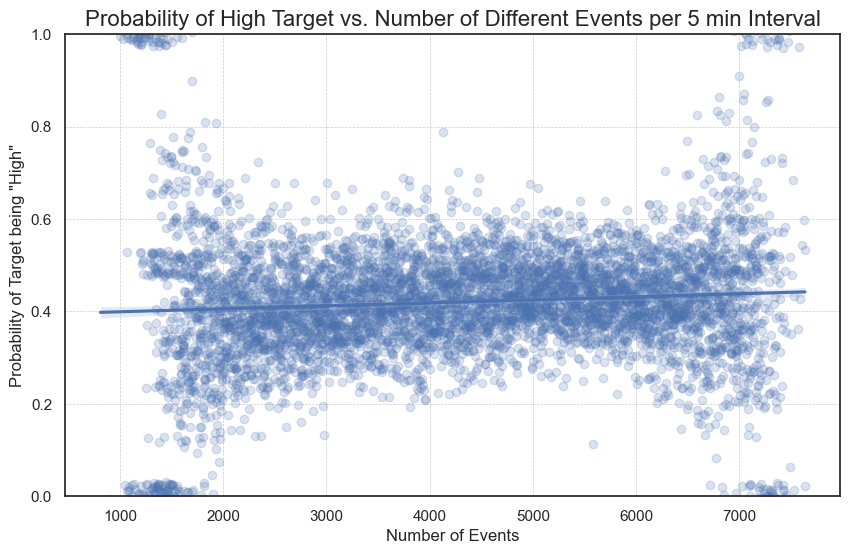

In [706]:
df_stat_nb_event = pd.concat([df_combined_condition.sum(axis=1), list_df[0]["target_cat"] == "high"], axis=1)
df_stat_nb_event.rename(columns={0: "nb_event"}, inplace=True)
# 1. Calculate the probability for each number of events
prob_df = df_stat_nb_event.groupby('nb_event')['target_cat'].mean().reset_index()
prob_df.rename(columns={'target_cat': 'probability_high'}, inplace=True)

""" # --- Seaborn Visualization ---
plt.figure(figsize=(12, 7))

# 2. Create the bar plot from the aggregated data
sns.scatterplot(x='nb_event', y='probability_high', data=prob_df, palette='viridis')

# --- Formatting the Plot ---
plt.title('Probability of High Target vs. Number of Concurrent Events', fontsize=16)
plt.xlabel('Number of Events', fontsize=12)
plt.ylabel('Probability of Target being "High"', fontsize=12)
plt.ylim(0, 1)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show() """

plt.figure(figsize=(10, 6))

# Use regplot with logistic=True to fit and plot a logistic regression model.
# y_jitter adds a small amount of vertical noise to the points for better visibility.
sns.regplot(x='nb_event', y='probability_high', data=prob_df,
            ci=95, # Show 95% confidence interval
            y_jitter=.03, # Add jitter to see density of points at 0 and 1
            scatter_kws={'alpha': 0.2}) # Make scatter points transparent

# --- Formatting the Plot ---
plt.title('Probability of High Target vs. Number of Different Events per 5 min Interval', fontsize=16)
plt.xlabel('Number of Events', fontsize=12)
plt.ylabel('Probability of Target being "High"', fontsize=12)
plt.ylim(0, 1) # Give a little space around the 0 and 1 lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

=>
- Mean probability is increasing with number of different event per 5 min interval
- With a selection of Events with p_min = 0.4, we increase the mean prob by 0.03 (+3%) 

In [676]:
prob_df

nb_event  probability_high
0          812          1.000000
1          843          0.000000
2          866          1.000000
3          897          0.000000
4          905          1.000000
...        ...               ...
6100      7582          0.428571
6101      7610          0.545455
6102      7628          0.571429
6103      7632          0.000000
6104      7634          0.533333

[6105 rows x 2 columns]

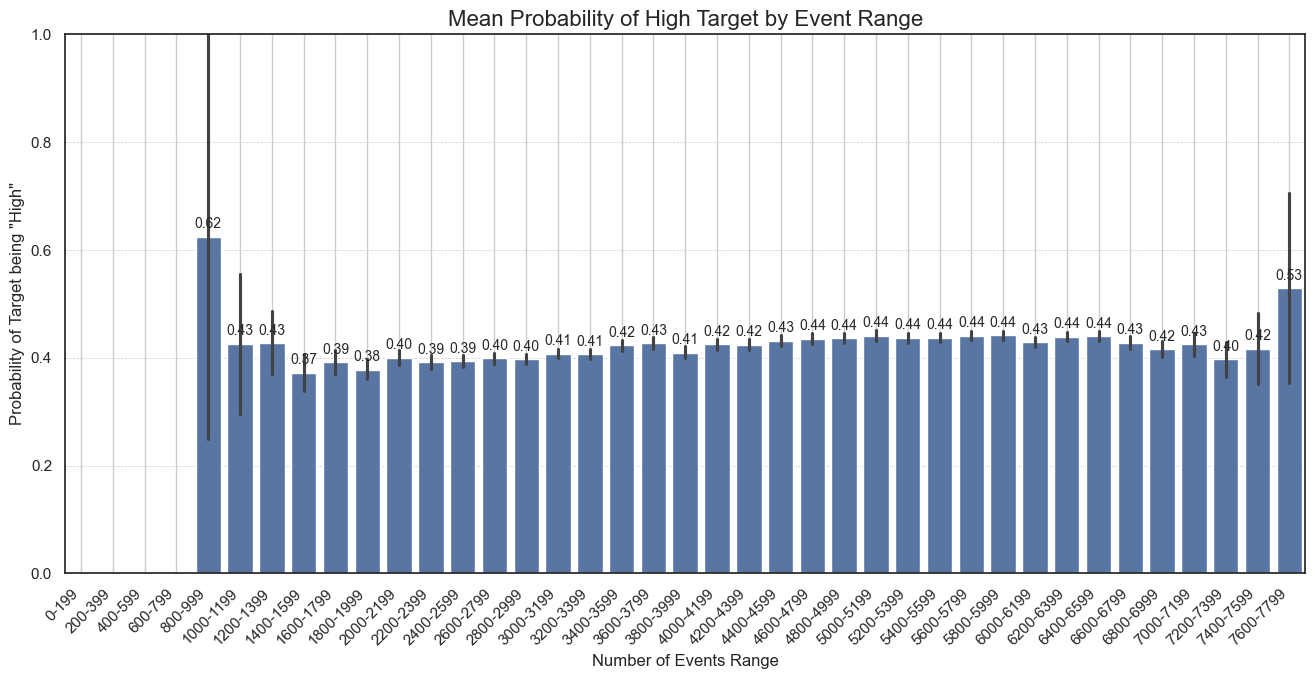

In [710]:
# 1. Define the bins for the number of events.
# We'll create bins of size 500, from 0 up to the maximum value.
max_events = df_stat_nb_event['nb_event'].max()
# Create bins like [0, 500, 1000, 1500, ...]
bins = np.arange(0, max_events + 200, 200)
# Create clear labels for the plot, like '0-499', '500-999', etc.
labels = [f'{int(bins[i])}-{int(bins[i+1]-1)}' for i in range(len(bins)-1)]


# 2. Use pandas.cut to segment the 'nb_event' column into these ranges.
df_stat_nb_event['event_range'] = pd.cut(df_stat_nb_event['nb_event'],
                                         bins=bins,
                                         labels=labels,
                                         right=False, # Makes intervals [0, 500), [500, 1000), etc.
                                         include_lowest=True) # Ensures 0 is included in the first bin

plt.figure(figsize=(16, 7))
ax = sns.barplot(data=df_stat_nb_event, y="target_cat", x="event_range")
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=10,
                xytext=(0, 9),
                textcoords='offset points')
# --- Formatting the Plot ---
plt.title('Mean Probability of High Target by Event Range', fontsize=16)
plt.xlabel('Number of Events Range', fontsize=12)
plt.ylabel('Probability of Target being "High"', fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
#plt.tight_layout() # Adjust plot to make sure labels don't get cut off
plt.xticks(rotation=45, ha='right')
ax = plt.gca()
ax.grid(True, 'both')
plt.show()

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_93901/2345260547.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


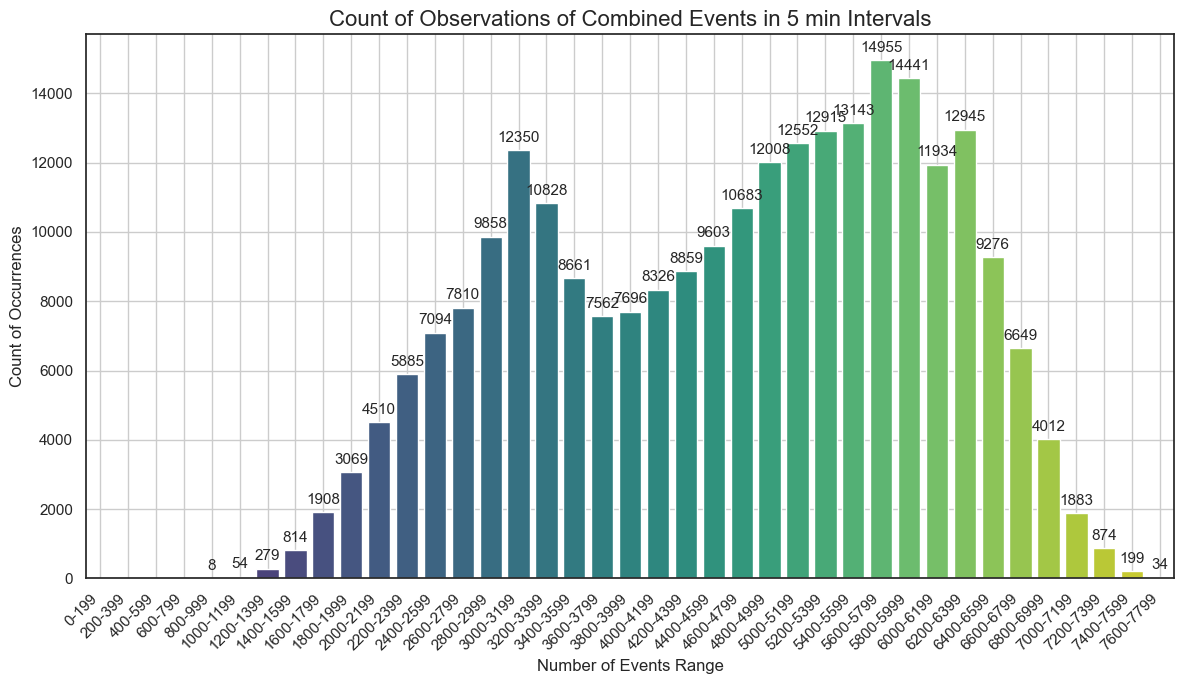

In [678]:
# --- Create the bar plot using seaborn.countplot ---
plt.figure(figsize=(12, 7))

# sns.countplot is the ideal function for this task.
# We use order to ensure the ranges are plotted in numerical order.
ax = sns.countplot(
    x='event_range',
    data=df_stat_nb_event,
    palette='viridis',
    order=labels # Use the generated labels to ensure correct sorting
)

# --- Add count labels on top of each bar for clarity ---
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=11,
                xytext=(0, 9),
                textcoords='offset points')

# --- Formatting the Plot ---
plt.title('Count of Observations of Combined Events in 5 min Intervals', fontsize=16)
plt.xlabel('Number of Events Range', fontsize=12)
plt.ylabel('Count of Occurrences', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.tight_layout()
ax.grid(True, 'both')
plt.show()

with : nb_event_min = 8000 & prob_min = 0.4:
- Low or high number of events in time range of 5 min is very low represented so not useful : prob to happened is low
- Most represented : Around 5600-5800 events lead to 40+4% proba = 44% to be high

In [679]:
df_stat_nb_event

nb_event  target_cat event_range
date_ETH                                             
2023-01-01 00:00:00      2944       False   2800-2999
2023-01-01 00:05:00      2562       False   2400-2599
2023-01-01 00:10:00      2520       False   2400-2599
2023-01-01 00:15:00      4021       False   4000-4199
2023-01-01 00:20:00      2678       False   2600-2799
...                       ...         ...         ...
2025-05-30 19:15:00      5669        True   5600-5799
2025-05-30 19:20:00      5883       False   5800-5999
2025-05-30 19:25:00      4577       False   4400-4599
2025-05-30 19:30:00      5384       False   5200-5399
2025-05-30 19:35:00      5923        True   5800-5999

[253677 rows x 3 columns]

In [680]:
list_df[0]["target_cat"] == "high"

date_ETH
2023-01-01 00:00:00    False
2023-01-01 00:05:00    False
2023-01-01 00:10:00    False
2023-01-01 00:15:00    False
2023-01-01 00:20:00    False
                       ...  
2025-05-30 19:15:00     True
2025-05-30 19:20:00    False
2025-05-30 19:25:00    False
2025-05-30 19:30:00    False
2025-05-30 19:35:00     True
Name: target_cat, Length: 253677, dtype: bool

In [681]:
global_event_by_day.describe()

count    881.000000
mean     287.942111
std        1.752287
min      236.000000
25%      288.000000
50%      288.000000
75%      288.000000
max      289.000000
dtype: float64

In [682]:
global_event_by_day.index.max()

Timestamp('2025-05-30 00:00:00')

In [683]:
fig = plt.figure(figsize=(10, 6))

sns.lineplot(global_event_by_day, markers="o")
# change x axis ticker format at 45°
# Rotate the x-axis tick labels to 45 degrees.
# Using ha='right' aligns the end of the label with the tick, which often looks better.
plt.xticks(rotation=45, ha='right')

# Adjust plot to make sure labels don't get cut off
plt.tight_layout()

# title
plt.title("Nb of Different Combined Event per day (count once per day)")
# Display the plot
plt.show()

In [684]:

sns.displot(global_event_by_day, height=5, aspect=1.5)
fig = plt.gcf()
ax = fig.gca()
ax.set_xlabel("Number of Events per Day")
ax.set_ylabel("Frequency")
plt.title("Distribution of Number of Events per Day")

Text(0.5, 1.0, 'Distribution of Number of Events per Day')

In [685]:
df_prob_comb_high_event

high    low  neutral    p_high     p_low  delta_prob  \
0       20487  16340     4502  0.495705  0.395364  933.967415   
13      16950  20295     4940  0.401802  0.481095 -600.833669   
20      21301  19625     9959  0.418611  0.385674  137.270977   
23      13680  13893     5343  0.415603  0.422074   -3.290828   
27      17019  13459     3819  0.496224  0.392425  831.655620   
...       ...    ...      ...       ...       ...         ...   
219202  13880  15828     4853  0.401609  0.457973 -255.466810   
219212  33440  31363    15247  0.417739  0.391793  133.139793   
219237  20915  17521     5701  0.473865  0.396969  599.398272   
219238  15856  17865     5395  0.405358  0.456718 -239.380861   
219239  49297  47518    22586  0.412869  0.397970   65.379146   

                    feat_0 feat_0_cat  lag_0              feat_1  ... lag_1  \
0           vwap_h_ETH_cat       high     64         Low_ETH_cat  ...    56   
13          vwap_h_ETH_cat        low     64         Low_ETH_cat  ...    56   
20          vwap_h_ETH_cat    neutral     64         Low_ETH_cat  ...    56   
23          vwap_h_ETH_cat    neutral     64         Low_ETH_cat  ...    56   
27          vwap_h_ETH_cat       high     64         Low_ETH_cat  ...    56   
...                    ...        ...    ...                 ...  ...   ...   
219202        High_ETH_cat        low     68  max_high_d_ETH_cat  ...    70   
219212        High_ETH_cat    neutral     68  max_high_d_ETH_cat  ...    70   
219237  max_high_d_ETH_cat    neutral     71  max_high_d_ETH_cat  ...    70   
219238  max_high_d_ETH_cat    neutral     71  max_high_d_ETH_cat  ...    70   
219239  max_high_d_ETH_cat    neutral     71  max_high_d_ETH_cat  ...    70   

                     feat_2 feat_2_cat lag_2  days_with_event  \
0       ichi_tenkan_ETH_cat       high    64              875   
13      ichi_tenkan_ETH_cat        low    64              870   
20      ichi_tenkan_ETH_cat    neutral    64              881   
23      ichi_tenkan_ETH_cat    neutral    64              880   
27        min_low_h_ETH_cat       high    56              873   
...                     ...        ...   ...              ...   
219202         Open_ETH_cat        low    68              868   
219212         Open_ETH_cat    neutral    68              874   
219237         Open_ETH_cat       high    68              872   
219238         Open_ETH_cat        low    68              868   
219239         Open_ETH_cat    neutral    68              875   

        weeks_with_event  months_with_event  ratio_days_with_event  \
0                    127                 29               0.993190   
13                   127                 29               0.987514   
20                   127                 29               1.000000   
23                   127                 29               0.998865   
27                   127                 29               0.990919   
...                  ...                ...                    ...   
219202               127                 29               0.985244   
219212               127                 29               0.992054   
219237               127                 29               0.989784   
219238               127                 29               0.985244   
219239               127                 29               0.993190   

        ratio_weeks_with_event  ratio_months_with_event  
0                          1.0                      1.0  
13                         1.0                      1.0  
20                         1.0                      1.0  
23                         1.0                      1.0  
27                         1.0                      1.0  
...                        ...                      ...  
219202                     1.0                      1.0  
219212                     1.0                      1.0  
219237                     1.0                      1.0  
219238                     1.0                      1.0  
219239             

In [686]:
list_df[0]

Close_ETH  Open_ETH  High_ETH   Low_ETH  \
date_ETH                                                       
2023-01-01 00:00:00        1.0  0.999782  1.000109  0.999774   
2023-01-01 00:05:00        1.0  0.999548  1.000008  0.999540   
2023-01-01 00:10:00        1.0  1.000084  1.000193  0.999841   
2023-01-01 00:15:00        1.0  1.000770  1.000770  0.999900   
2023-01-01 00:20:00        1.0  0.999330  1.000025  0.999330   
...                        ...       ...       ...       ...   
2025-05-30 19:15:00        1.0  0.998258  1.001698  0.997009   
2025-05-30 19:20:00        1.0  0.998554  1.001387  0.998451   
2025-05-30 19:25:00        1.0  1.004900  1.005056  0.999299   
2025-05-30 19:30:00        1.0  1.001168  1.001491  0.997621   
2025-05-30 19:35:00        1.0  1.012121  1.014171  0.998487   

                     ichi_cloud_a_ETH  ichi_cloud_b_ETH  ichi_kijun_ETH  \
date_ETH                                                                  
2023-01-01 00:00:00          0.999171          0.999736        0.998393   
2023-01-01 00:05:00          0.998785          0.999276        0.998113   
2023-01-01 00:10:00          0.998860          0.999351        0.998243   
2023-01-01 00:15:00          0.999669          1.000113        0.999003   
2023-01-01 00:20:00          0.999178          0.999443        0.998335   
...                               ...               ...             ...   
2025-05-30 19:15:00          1.009059          1.012239        1.000323   
2025-05-30 19:20:00          1.006895          1.010775        0.998877   
2025-05-30 19:25:00          1.011829          1.015728        1.003772   
2025-05-30 19:30:00          1.011492          1.015731        1.004944   
2025-05-30 19:35:00          1.023400          1.028043        1.011526   

                     ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
date_ETH                                                     
2023-01-01 00:00:00         0.999464              2.024261   
2023-01-01 00:05:00         0.999184              2.023329   
2023-01-01 00:10:00         0.999477              2.023482   
2023-01-01 00:15:00         1.000239              2.025023   
2023-01-01 00:20:00         0.999569              2.023668   
...                              ...                   ...   
2025-05-30 19:15:00         1.000559              1.043299   
2025-05-30 19:20:00         0.999113              1.041791   
2025-05-30 19:25:00         1.004009              1.046896   
2025-05-30 19:30:00         1.003987              1.048118   
2025-05-30 19:35:00         1.009147              1.060823   

                     ichi_cloud_b_day_ETH  ...  hour_cos_cat  hour_sin_cat  \
date_ETH                                   ...                               
2023-01-01 00:00:00              2.017807  ...       neutral          high   
2023-01-01 00:05:00              2.016878  ...       neutral          high   
2023-01-01 00:10:00              2.017030  ...       neutral          high   
2023-01-01 00:15:00              2.018567  ...       neutral          high   
2023-01-01 00:20:00              2.017215  ...       neutral          high   
...                                   ...  ...           ...           ...   
2025-05-30 19:15:00              1.026564  ...          high       neutral   
2025-05-30 19:20:00              1.025079  ...          high       neutral   
2025-05-30 19:25:00              1.030103  ...          high       neutral   
2025-05-30 19:30:00              1.031306  ...          high       neutral   
2025-05-30 19:35:00              1.043807  ...          high       neutral   

                     weekday_cos_cat  weekday_sin_cat  day_in_month_cos_cat  \
date_ETH                                                                      
2023-01-01 00:00:00          neutral          neutral                  high   
2023-01-01 00:05:00          neutral          neutral                  high   
2023-01-01 00:10:00          neutral          neutral                  hig

In [711]:
df_combined_condition

0      1      2      3      4      5      6      7      \
date_ETH                                                                      
2023-01-01 00:00:00  False  False  False  False  False  False  False  False   
2023-01-01 00:05:00  False  False  False  False  False  False  False  False   
2023-01-01 00:10:00  False  False  False  False  False  False  False  False   
2023-01-01 00:15:00  False  False  False  False  False  False  False  False   
2023-01-01 00:20:00  False  False  False  False  False  False  False  False   
...                    ...    ...    ...    ...    ...    ...    ...    ...   
2025-05-30 19:15:00  False  False   True  False  False  False  False   True   
2025-05-30 19:20:00  False  False   True  False  False  False  False   True   
2025-05-30 19:25:00   True  False  False  False  False  False  False  False   
2025-05-30 19:30:00   True  False  False  False  False  False  False  False   
2025-05-30 19:35:00   True  False  False  False   True  False  False  False   

                     8      9      ...  27650  27651  27652  27653  27654  \
date_ETH                           ...                                      
2023-01-01 00:00:00  False  False  ...  False  False  False  False  False   
2023-01-01 00:05:00  False  False  ...  False  False  False  False  False   
2023-01-01 00:10:00  False  False  ...  False  False  False  False  False   
2023-01-01 00:15:00  False  False  ...   True  False  False   True  False   
2023-01-01 00:20:00  False  False  ...   True  False  False   True  False   
...                    ...    ...  ...    ...    ...    ...    ...    ...   
2025-05-30 19:15:00  False  False  ...  False  False  False  False  False   
2025-05-30 19:20:00  False  False  ...  False  False  False  False  False   
2025-05-30 19:25:00  False   True  ...  False  False  False  False  False   
2025-05-30 19:30:00  False   True  ...  False  False  False  False  False   
2025-05-30 19:35:00  False   True  ...  False  False  False  False  False   

                     27655  27656  27657  27658  27659  
date_ETH                                                
2023-01-01 00:00:00  False  False  False  False   True  
2023-01-01 00:05:00  False  False  False  False   True  
2023-01-01 00:10:00  False  False  False  False   True  
2023-01-01 00:15:00  False   True  False  False   True  
2023-01-01 00:20:00  False   True  False  False   True  
...                    ...    ...    ...    ...    ...  
2025-05-30 19:15:00  False  False  False  False  False  
2025-05-30 19:20:00  False  False  False  False  False  
2025-05-30 19:25:00  False  False  False  False  False  
2025-05-30 19:30:00  False  False  False  False  False  
2025-05-30 19:35:00  False  False  False  False  False  

[253677 rows x 27660 columns]

In [712]:
df_prob_comb_high_event

high    low  neutral    p_high     p_low  delta_prob  \
0       20487  16340     4502  0.495705  0.395364  933.967415   
13      16950  20295     4940  0.401802  0.481095 -600.833669   
20      21301  19625     9959  0.418611  0.385674  137.270977   
23      13680  13893     5343  0.415603  0.422074   -3.290828   
27      17019  13459     3819  0.496224  0.392425  831.655620   
...       ...    ...      ...       ...       ...         ...   
219202  13880  15828     4853  0.401609  0.457973 -255.466810   
219212  33440  31363    15247  0.417739  0.391793  133.139793   
219237  20915  17521     5701  0.473865  0.396969  599.398272   
219238  15856  17865     5395  0.405358  0.456718 -239.380861   
219239  49297  47518    22586  0.412869  0.397970   65.379146   

                    feat_0 feat_0_cat  lag_0              feat_1  ... lag_1  \
0           vwap_h_ETH_cat       high     64         Low_ETH_cat  ...    56   
13          vwap_h_ETH_cat        low     64         Low_ETH_cat  ...    56   
20          vwap_h_ETH_cat    neutral     64         Low_ETH_cat  ...    56   
23          vwap_h_ETH_cat    neutral     64         Low_ETH_cat  ...    56   
27          vwap_h_ETH_cat       high     64         Low_ETH_cat  ...    56   
...                    ...        ...    ...                 ...  ...   ...   
219202        High_ETH_cat        low     68  max_high_d_ETH_cat  ...    70   
219212        High_ETH_cat    neutral     68  max_high_d_ETH_cat  ...    70   
219237  max_high_d_ETH_cat    neutral     71  max_high_d_ETH_cat  ...    70   
219238  max_high_d_ETH_cat    neutral     71  max_high_d_ETH_cat  ...    70   
219239  max_high_d_ETH_cat    neutral     71  max_high_d_ETH_cat  ...    70   

                     feat_2 feat_2_cat lag_2  days_with_event  \
0       ichi_tenkan_ETH_cat       high    64              875   
13      ichi_tenkan_ETH_cat        low    64              870   
20      ichi_tenkan_ETH_cat    neutral    64              881   
23      ichi_tenkan_ETH_cat    neutral    64              880   
27        min_low_h_ETH_cat       high    56              873   
...                     ...        ...   ...              ...   
219202         Open_ETH_cat        low    68              868   
219212         Open_ETH_cat    neutral    68              874   
219237         Open_ETH_cat       high    68              872   
219238         Open_ETH_cat        low    68              868   
219239         Open_ETH_cat    neutral    68              875   

        weeks_with_event  months_with_event  ratio_days_with_event  \
0                    127                 29               0.993190   
13                   127                 29               0.987514   
20                   127                 29               1.000000   
23                   127                 29               0.998865   
27                   127                 29               0.990919   
...                  ...                ...                    ...   
219202               127                 29               0.985244   
219212               127                 29               0.992054   
219237               127                 29               0.989784   
219238               127                 29               0.985244   
219239               127                 29               0.993190   

        ratio_weeks_with_event  ratio_months_with_event  
0                          1.0                      1.0  
13                         1.0                      1.0  
20                         1.0                      1.0  
23                         1.0                      1.0  
27                         1.0                      1.0  
...                        ...                      ...  
219202                     1.0                      1.0  
219212                     1.0                      1.0  
219237                     1.0                      1.0  
219238                     1.0                      1.0  
219239             

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# 1. Prepare the data for modeling
#X_comb = df_combined_condition
y_comb = (list_df[0]["target_cat"] == "high")
# 2. Use a Random Forest to find important features
print("--- Finding Important Events with Random Forest ---")
# class_weight='balanced' is useful if "high" targets are rare
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(df_combined_condition, y_comb)
# Get and plot feature importances
importances = pd.Series(rf_model.feature_importances_, index=df_combined_condition.columns).sort_values(ascending=False)
print("\nFeature Importances (most predictive individual events):")
print(importances)
# Plot the feature importances
plt.figure(figsize=(12, 7))
sns.barplot(x=importances.values, y=importances.index, palette='viridis')
plt.title('Feature Importance of Events for Predicting "High" Target', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Event', fontsize=12)
plt.show()

# TODO

In [ ]:
# DONE : optimize corr calculation
# DONE : evaluate value of target_14 in term of real variation % between high and low 
# DONE : cross : find cat combinaison with most prob diff between high and low (linked to chi2 not always but a little)
# DONE : change algo for target cat : buy/sell with TP/SL = 2 (if +0.1% TP => -0.05% SL)
# DONE : past history: select the lags exponentially on the past history (not linear: example 5 min ago, 10 min, 20 min, 40 min, 1h20, 2h40, 5h20 ago)
# DONE : cross best over all lags : find cat combinaison with most prob diff between high and low (linked to chi2 ?)
# DONE : check temporal repartition of interesting events
# DONE : maybe have a threshold on target instead of quantiles?
# DONE : test another target : maybe the max/min value on all targets to have ony 2 targets
# DONE : cross prob with selected features with best corr with targets
# DONE : cross prob with selected features with best chi2 with targets
# TODO : Take best cross prob (3 feat) and check when several occurs on same time to see if prob increase
# TODO : backtest strat on df_train data
# TODO : backtest strat on df_test data

# TODO : test with a 40/40/20 for feature cat : H/L/N instead of 10/10/80
# TODO : do a clustering on train data with normal features (no feat categories) to find clusters with high/low/neutral targets ?
# TODO : machine learning classification with selected features ?

# TODO : create a new exploration notebook for a target of daily trading : (currently : 6 hours history to predict next 1h)
#        - find good time frame / PAST_HISTORY / FUTURE_TARGET

In [269]:
len(list_col_select)

103

In [270]:
list_past

[71, 70, 68, 64, 56, 40, 8]

In [271]:
# how many combinaison of 3 elements in len(list_col_select) * nb lags
nb_elements = len(list_col_select) * len(list_past)
nb_comb = nb_elements * (nb_elements-1) * (nb_elements-2)
nb_comb


373247280

It s too much

In [272]:
# how many combinaison of 3 elements in 40 selected comb (feat / lag) 
# (20 high target /20 low target and with max or min delta_prob)
nb_elements = 40
print(nb_elements, " elements")
nb_comb = nb_elements * (nb_elements-1) * (nb_elements-2)
nb_comb

40  elements


59280

Ok 